# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [32]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

In [33]:
def read_image(image_path):
    """Reads and returns image."""
    return mpimg.imread(image_path)

def read_image_and_print_dims(image_path):
    """Reads and returns image.
    Helper function to examine how an image is represented.
    """
    #reading in an image
    image = mpimg.imread(image_path)
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
    return image

In [34]:
# Read and save test images to array
test_images = [read_image('test_images/' + i) for i in os.listdir('test_images/')]

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [35]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    # print("Hough lines: ", lines)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [36]:
def intersection_x(coef1, intercept1, coef2, intercept2):
    """Returns x-coordinate of intersection of two lines."""
    x = (intercept2-intercept1)/(coef1-coef2)
    return x

def draw_linear_regression_line(coef, intercept, intersection_x, img, imshape=[540,960], color=[255, 0, 0], thickness=2):
    
    # Get starting and ending points of regression line, ints.
    print("Coef: ", coef, "Intercept: ", intercept, 
          "intersection_x: ", intersection_x)
    point_one = (int(intersection_x), int(intersection_x * coef + intercept))
    if coef > 0:
        point_two = (imshape[1], int(imshape[1] * coef + intercept))
    elif coef < 0:
        point_two = (0, int(0 * coef + intercept))
    print("Point one: ", point_one, "Point two: ", point_two)
    
    # Draw line using cv2.line
    cv2.line(img, point_one, point_two, color, thickness)

In [37]:
def find_line_fit(slope_intercept):
    """slope_intercept is an array [[slope, intercept], [slope, intercept]...]."""

    # Initialise arrays
    kept_slopes = []
    kept_intercepts = []
    print("Slope & intercept: ", slope_intercept)
    if len(slope_intercept) == 1:
        return slope_intercept[0][0], slope_intercept[0][1]

    # Remove points with slope not within 1.5 standard deviations of the mean
    slopes = [pair[0] for pair in slope_intercept]
    mean_slope = np.mean(slopes)
    slope_std = np.std(slopes)
    for pair in slope_intercept:
        slope = pair[0]
        if slope - mean_slope < 1.5 * slope_std:
            kept_slopes.append(slope)
            kept_intercepts.append(pair[1])
    if not kept_slopes:
        kept_slopes = slopes
        kept_intercepts = [pair[1] for pair in slope_intercept]
    # Take estimate of slope, intercept to be the mean of remaining values
    slope = np.mean(kept_slopes)
    intercept = np.mean(kept_intercepts)
    print("Slope: ", slope, "Intercept: ", intercept)
    return slope, intercept

In [38]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # Image parameters (hard-coded. TODO: Make not hard-coded.)
    imshape = [540, 960]
    
    # Initialise arrays
    positive_slope_points = []
    negative_slope_points = []
    positive_slope_intercept = []
    negative_slope_intercept = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:            
            slope = (y1-y2)/(x1-x2)
            # print("Points: ", [x1, y1, x2, y2])
            length = math.sqrt((x1-x2)**2 + (y1-y2)**2)
            # print("Length: ", length)
            if not math.isnan(slope):
                if length > 50:
                    if slope > 0:
                        positive_slope_points.append([x1, y1])
                        positive_slope_points.append([x2, y2])
                        positive_slope_intercept.append([slope, y1-slope*x1])
                    elif slope < 0:
                        negative_slope_points.append([x1, y1])
                        negative_slope_points.append([x2, y2])
                        negative_slope_intercept.append([slope, y1-slope*x1])
        
    # If either array is empty, waive length requirement
    if not positive_slope_points:
        for line in lines:
            for x1,y1,x2,y2 in line:            
                slope = (y1-y2)/(x1-x2)
                if slope > 0:
                    positive_slope_points.append([x1, y1])
                    positive_slope_points.append([x2, y2])
                    positive_slope_intercept.append([slope, y1-slope*x1])
    if not negative_slope_points:
        for line in lines:
            for x1,y1,x2,y2 in line:            
                slope = (y1-y2)/(x1-x2)
                if slope < 0:
                    negative_slope_points.append([x1, y1])
                    negative_slope_points.append([x2, y2])
                    negative_slope_intercept.append([slope, y1-slope*x1])
    if not positive_slope_points:
        print("positive_slope_points still empty")
    if not negative_slope_points:
        print("negative_slope_points still empty")
    # Even though positive_slope_points is not used, I am keeping it for debugging purposes.
    positive_slope_points = np.array(positive_slope_points)
    negative_slope_points = np.array(negative_slope_points)
    # print("Positive slope line points: ", positive_slope_points)
    # print("Negative slope line points: ", negative_slope_points)
    # print("positive slope points dtype: ", positive_slope_points.dtype)

    # Get intercept and coefficient of fitted lines
    pos_coef, pos_intercept = find_line_fit(positive_slope_intercept)
    neg_coef, neg_intercept = find_line_fit(negative_slope_intercept)
    
    # Discarded Linear Regression Option:
    # Get intercept and coefficient of linear regression lines
    # pos_coef, pos_intercept = find_linear_regression_line(positive_slope_points)
    # neg_coef, neg_intercept = find_linear_regression_line(negative_slope_points)
    
    # Get intersection point
    intersection_x_coord = intersection_x(pos_coef, pos_intercept, neg_coef, neg_intercept)
    
    # Plot lines
    draw_linear_regression_line(pos_coef, pos_intercept, intersection_x_coord, img)
    draw_linear_regression_line(neg_coef, neg_intercept, intersection_x_coord, img)

In [39]:
# Not used
from sklearn.linear_model import LinearRegression

def find_linear_regression_line(points):
    # Separate points into X and y to fit LinearRegression model
    points_x = [[point[0]] for point in points]
    points_y = [point[1] for point in points]
    # points_x_print = [point[0] for point in points]
    # print("X points: ", points_x, "Length: ", len(points_x))
    # print("X points: ", points_x_print, "Length: ", len(points_x))
    # print("Y points: ", points_y, "Length: ", len(points_y))

    # Fit points to LinearRegression line
    clf = LinearRegression().fit(points_x, points_y)

    # Get parameters from line
    coef = clf.coef_[0]
    intercept = clf.intercept_
    print("Coefficients: ", coef, "Intercept: ", intercept)
    return coef, intercept

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [40]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 't1.png',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

### Pipeline

Steps:
1. Read in and grayscale the image
2. Define a kernel size and apply Gaussian smoothing
3. Define our parameters for Canny and apply to get edges image
4. Mask edges image using cv2.fillPoly() (ignore everything outside region of interest)
5. Define Hough transform parameters and run Hough transform on masked edge-detected image
6. Draw line segments
7. Draw lines extrapolated from line segments
8. Combine line image with original image to see how accurate the line annotations are.

Slope & intercept:  [[0.5535055350553506, 41.50553505535049], [0.5748299319727891, 33.874149659863974], [0.5774058577405857, 31.3305439330544], [0.5528455284552846, 41.097560975609724]]
Slope:  0.5646467133060025 Intercept:  36.95194740596965
Slope & intercept:  [[-0.8106508875739645, 698.7100591715977], [-0.7555555555555555, 671.5555555555555], [-0.7054263565891473, 653.6744186046512], [-0.7833333333333333, 688.6]]
Slope:  -0.7637415332630001 Intercept:  678.1350083329511
Coef:  0.5646467133060025 Intercept:  36.95194740596965 intersection_x:  482.67745712373363
Point one:  (482, 309) Point two:  (960, 579)
Coef:  -0.7637415332630001 Intercept:  678.1350083329511 intersection_x:  482.67745712373363
Point one:  (482, 309) Point two:  (0, 678)


array([[[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ...,
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 82, 118, 151]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ...,
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ...,
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       ...,

       [[ 68,  70,  76],
        [ 68,  70,  76],
        [ 68,  70,  76],
        ...,
        [ 65,  65,  73],
        [ 64,  64,  72],
        [ 63,  63,  71]],

       [[ 69,  69,  75],
        [ 69,  69,  75],
        [ 70,  70,  76],
        ...,
        [ 62,  64,  71],
        [ 62,  64,  71],
        [ 61,  63,  70]],

       [[ 67,  67,  74],
        [ 67,  67,  74],
        [ 67,  67,  74],
        ...,
        [ 61,  62,  72],
        [ 60,  62,  71],
        [ 59,  61,  70]]

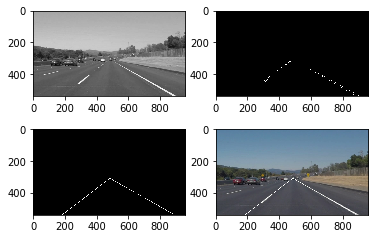

In [41]:
# Pipeline

def draw_lane_lines(image):
    """Draw lane lines in white on original image."""
    # Print image details
    # print("image.shape: ", image.shape)
    imshape = image.shape
    
    # Greyscale image
    greyscaled_image = grayscale(image)
    plt.subplot(2,2,1)
    plt.imshow(greyscaled_image, cmap="gray")
    
    # Gaussian Blur
    blurred_grey_image = gaussian_blur(greyscaled_image, 5)
    
    # Canny edge detection
    edges_image = canny(blurred_grey_image, 50, 150)
    
    # Mask edges image
    border = 0
    vertices = np.array([[(0,imshape[0]),(465, 320), (475, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    edges_image_with_mask = region_of_interest(edges_image, vertices)
    ## Plot masked edges image
    bw_edges_image_with_mask = cv2.cvtColor(edges_image_with_mask, cv2.COLOR_GRAY2BGR)
    plt.subplot(2,2,2)
    plt.imshow(bw_edges_image_with_mask)
    
    # Hough lines
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 45     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40 #minimum number of pixels making up a line
    max_line_gap = 100    # maximum gap in pixels between connectable line segments
    lines_image = hough_lines(edges_image_with_mask, rho, theta, threshold, min_line_len, max_line_gap)
    
    # Convert Hough from single channel to RGB to prep for weighted
    # TODO: Have it convert the lines to red, not white.
    hough_rgb_image = cv2.cvtColor(lines_image, cv2.COLOR_GRAY2BGR)
    # hough_rgb_image.dtype: uint8.  Shape: (540,960,3).
    # hough_rgb_image is like [[[0 0 0], [0 0 0],...] [[0 0 0], [0 0 0],...]]
    ## Plot Hough lines image
    plt.subplot(2,2,3)
    plt.imshow(hough_rgb_image)    
    
    # Combine lines image with original image
    final_image = weighted_img(hough_rgb_image, image)
    ## Plot final image
    plt.subplot(2,2,4)
    plt.imshow(final_image)
    return final_image

draw_lane_lines(test_images[0])

## Testing the Pipeline on the test_images

Slope & intercept:  [[0.5535055350553506, 41.50553505535049], [0.5748299319727891, 33.874149659863974], [0.5774058577405857, 31.3305439330544], [0.5528455284552846, 41.097560975609724]]
Slope:  0.5646467133060025 Intercept:  36.95194740596965
Slope & intercept:  [[-0.8106508875739645, 698.7100591715977], [-0.7555555555555555, 671.5555555555555], [-0.7054263565891473, 653.6744186046512], [-0.7833333333333333, 688.6]]
Slope:  -0.7637415332630001 Intercept:  678.1350083329511
Coef:  0.5646467133060025 Intercept:  36.95194740596965 intersection_x:  482.67745712373363
Point one:  (482, 309) Point two:  (960, 579)
Coef:  -0.7637415332630001 Intercept:  678.1350083329511 intersection_x:  482.67745712373363
Point one:  (482, 309) Point two:  (0, 678)


array([[[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ...,
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 82, 118, 151]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ...,
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ...,
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       ...,

       [[ 68,  70,  76],
        [ 68,  70,  76],
        [ 68,  70,  76],
        ...,
        [ 65,  65,  73],
        [ 64,  64,  72],
        [ 63,  63,  71]],

       [[ 69,  69,  75],
        [ 69,  69,  75],
        [ 70,  70,  76],
        ...,
        [ 62,  64,  71],
        [ 62,  64,  71],
        [ 61,  63,  70]],

       [[ 67,  67,  74],
        [ 67,  67,  74],
        [ 67,  67,  74],
        ...,
        [ 61,  62,  72],
        [ 60,  62,  71],
        [ 59,  61,  70]]

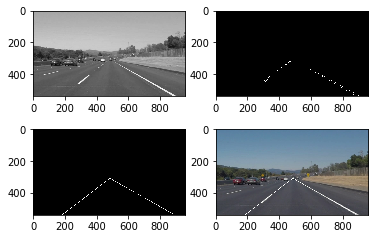

In [42]:
draw_lane_lines(test_images[0])

Slope & intercept:  [[0.6214285714285714, 7.921428571428578], [0.6512455516014235, -4.185053380782904], [0.6507177033492823, -4.545454545454504]]
Slope:  0.6411306087930924 Intercept:  -0.26969311826961
Slope & intercept:  [[-0.6713286713286714, 630.1118881118881], [-0.7222222222222222, 655.8333333333334], [-0.6733333333333333, 631.7333333333333], [-0.6973684210526315, 646.7631578947369]]
Slope:  -0.6910631619842146 Intercept:  641.1104281683229
Coef:  0.6411306087930924 Intercept:  -0.26969311826961 intersection_x:  481.4465698277216
Point one:  (481, 308) Point two:  (960, 615)
Coef:  -0.6910631619842146 Intercept:  641.1104281683229 intersection_x:  481.4465698277216
Point one:  (481, 308) Point two:  (0, 641)


array([[[144, 157, 167],
        [114, 129, 141],
        [107, 125, 143],
        ...,
        [109, 123, 142],
        [117, 127, 141],
        [149, 156, 168]],

       [[114, 129, 141],
        [114, 133, 147],
        [107, 128, 146],
        ...,
        [110, 127, 146],
        [114, 127, 143],
        [118, 129, 142]],

       [[105, 126, 143],
        [106, 129, 146],
        [102, 127, 150],
        ...,
        [103, 125, 148],
        [109, 126, 146],
        [107, 122, 141]],

       ...,

       [[ 96,  97, 100],
        [ 73,  74,  78],
        [ 66,  67,  71],
        ...,
        [ 70,  71,  74],
        [ 75,  76,  79],
        [ 96,  97, 100]],

       [[110, 111, 114],
        [ 84,  85,  88],
        [ 71,  72,  76],
        ...,
        [ 78,  78,  82],
        [ 87,  88,  91],
        [111, 112, 115]],

       [[144, 145, 148],
        [112, 113, 116],
        [ 94,  94,  98],
        ...,
        [ 98,  98, 100],
        [112, 113, 114],
        [143, 144, 146]]

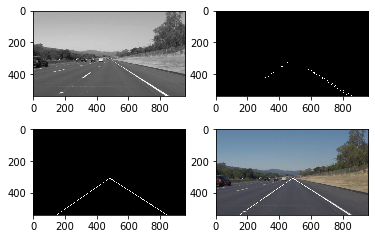

In [43]:
draw_lane_lines(test_images[1])

Slope & intercept:  [[0.6198347107438017, 16.107438016528874], [0.5798319327731093, 36.47058823529409]]
Slope:  0.5998333217584555 Intercept:  26.28901312591148
Slope & intercept:  [[-0.7536764705882353, 670.8933823529412], [-0.7019867549668874, 646.1059602649007], [-0.7708333333333334, 672.8958333333334], [-0.7788944723618091, 676.9447236180904], [-0.8057553956834532, 680.2589928057554], [-0.7320261437908496, 665.1176470588235], [-0.7030716723549488, 647.9761092150171]]
Slope:  -0.7494634632970738 Intercept:  665.7418069498374
Coef:  0.5998333217584555 Intercept:  26.28901312591148 intersection_x:  473.91559878178305
Point one:  (473, 310) Point two:  (960, 602)
Coef:  -0.7494634632970738 Intercept:  665.7418069498374 intersection_x:  473.91559878178305
Point one:  (473, 310) Point two:  (0, 665)


array([[[ 82, 125, 162],
        [ 82, 125, 162],
        [ 82, 125, 162],
        ...,
        [ 77, 122, 157],
        [ 75, 121, 155],
        [ 70, 116, 150]],

       [[ 82, 125, 160],
        [ 82, 125, 160],
        [ 82, 125, 160],
        ...,
        [ 77, 122, 157],
        [ 75, 121, 155],
        [ 70, 116, 150]],

       [[ 82, 126, 158],
        [ 82, 126, 158],
        [ 82, 126, 158],
        ...,
        [ 78, 122, 157],
        [ 77, 120, 155],
        [ 72, 115, 150]],

       ...,

       [[ 76,  80,  85],
        [ 76,  80,  85],
        [ 76,  80,  85],
        ...,
        [ 58,  63,  74],
        [ 58,  63,  74],
        [ 58,  63,  74]],

       [[ 76,  80,  85],
        [ 76,  80,  85],
        [ 76,  80,  85],
        ...,
        [ 57,  62,  73],
        [ 57,  62,  73],
        [ 57,  62,  73]],

       [[ 75,  79,  84],
        [ 75,  79,  84],
        [ 75,  79,  84],
        ...,
        [ 58,  62,  71],
        [ 58,  62,  71],
        [ 58,  62,  71]]

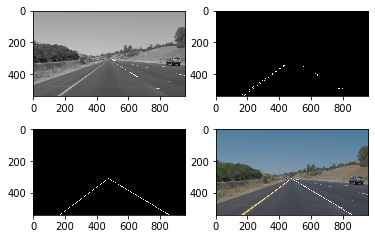

In [44]:
draw_lane_lines(test_images[2])

Slope & intercept:  [[0.6026490066225165, 25.145695364238406], [0.573170731707317, 38.04878048780489], [0.5777027027027027, 32.5101351351351], [0.5560344827586207, 49.504310344827616]]
Slope:  0.5689693057228801 Intercept:  40.021075322589205
Slope & intercept:  [[-0.7263513513513513, 655.2162162162163], [-0.7542372881355932, 671.9491525423729], [-0.7580645161290323, 673.6935483870968], [-0.7241379310344828, 653.1379310344828]]
Slope:  -0.7406977716626149 Intercept:  663.4992120450422
Coef:  0.5689693057228801 Intercept:  40.021075322589205 intersection_x:  476.0584941686938
Point one:  (476, 310) Point two:  (960, 586)
Coef:  -0.7406977716626149 Intercept:  663.4992120450422 intersection_x:  476.0584941686938
Point one:  (476, 310) Point two:  (0, 663)


array([[[ 83, 126, 162],
        [ 83, 126, 162],
        [ 83, 126, 162],
        ...,
        [ 78, 125, 160],
        [ 76, 123, 158],
        [ 74, 122, 157]],

       [[ 83, 126, 162],
        [ 83, 126, 162],
        [ 83, 126, 162],
        ...,
        [ 77, 124, 159],
        [ 75, 122, 158],
        [ 72, 121, 156]],

       [[ 82, 126, 161],
        [ 83, 126, 162],
        [ 82, 127, 162],
        ...,
        [ 75, 124, 159],
        [ 74, 122, 158],
        [ 72, 121, 156]],

       ...,

       [[ 82,  82,  88],
        [ 82,  82,  88],
        [ 82,  82,  88],
        ...,
        [ 62,  66,  74],
        [ 62,  66,  74],
        [ 62,  66,  74]],

       [[ 82,  81,  87],
        [ 82,  81,  87],
        [ 82,  81,  87],
        ...,
        [ 62,  66,  73],
        [ 62,  65,  72],
        [ 62,  65,  72]],

       [[ 79,  78,  85],
        [ 79,  78,  85],
        [ 79,  78,  85],
        ...,
        [ 62,  65,  72],
        [ 62,  65,  72],
        [ 62,  65,  72]]

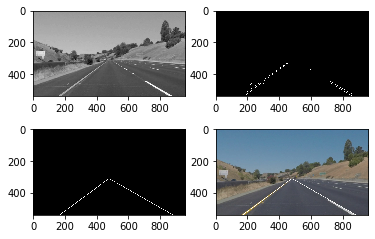

In [45]:
draw_lane_lines(test_images[3])

Slope & intercept:  [[0.6490384615384616, -4.8125], [0.5970873786407767, 22.883495145631116], [0.5786516853932584, 36.915730337078685]]
Slope:  0.6082591751908323 Intercept:  18.3289084942366
Slope & intercept:  [[-0.6743421052631579, 631.0592105263158], [-0.7246963562753036, 653.9676113360324], [-0.6888888888888889, 634.6444444444444], [-0.726027397260274, 653.7123287671233], [-0.6741935483870968, 630.7129032258065]]
Slope:  -0.6976296592149442 Intercept:  640.8192996599444
Coef:  0.6082591751908323 Intercept:  18.3289084942366 intersection_x:  476.6794651774183
Point one:  (476, 308) Point two:  (960, 602)
Coef:  -0.6976296592149442 Intercept:  640.8192996599444 intersection_x:  476.6794651774183
Point one:  (476, 308) Point two:  (0, 640)


array([[[147, 157, 168],
        [115, 127, 142],
        [106, 123, 142],
        ...,
        [102, 122, 141],
        [112, 129, 142],
        [146, 159, 171]],

       [[114, 126, 142],
        [115, 130, 147],
        [106, 125, 146],
        ...,
        [ 99, 123, 144],
        [110, 127, 144],
        [113, 128, 142]],

       [[105, 122, 141],
        [106, 125, 146],
        [100, 123, 147],
        ...,
        [ 94, 120, 145],
        [ 98, 120, 142],
        [100, 121, 139]],

       ...,

       [[103, 102, 107],
        [ 92,  91,  96],
        [ 88,  87,  92],
        ...,
        [ 66,  66,  74],
        [ 70,  70,  78],
        [ 95,  95, 103]],

       [[113, 112, 116],
        [100,  99, 103],
        [ 92,  91,  95],
        ...,
        [ 70,  70,  78],
        [ 85,  85,  91],
        [109, 109, 115]],

       [[141, 140, 144],
        [111, 110, 114],
        [102, 102, 106],
        ...,
        [ 95,  95, 102],
        [110, 110, 116],
        [146, 146, 153]]

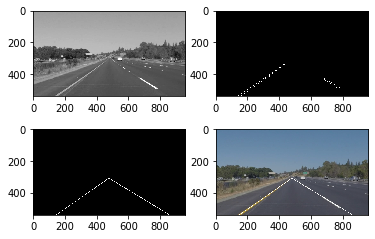

In [46]:
draw_lane_lines(test_images[4])

In [48]:
# draw_lane_lines(test_images[5])

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [49]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [50]:
def process_image(image):
    """Puts image through pipeline and returns 3-channel image for processing video below."""
    result = draw_lane_lines(image)
    print(result.shape)
    return result

Let's try the one with the solid white lane on the right first ...

t:   0%|                                                                             | 0/681 [00:00<?, ?it/s, now=None]

Slope & intercept:  [[0.6492890995260664, -6.199052132701468], [0.6989795918367347, -33.525510204081684], [0.6257668711656442, 9.662576687116541]]
Slope:  0.6580118541761485 Intercept:  -10.020661883222203
Slope & intercept:  [[-0.6028571428571429, 600.9028571428571], [-0.6274509803921569, 615.1764705882352], [-0.6013986013986014, 610.6573426573426], [-0.6018957345971564, 601.1990521327015], [-0.6475770925110133, 620.5947136563876], [-0.7213114754098361, 650.704918032787], [-0.6490384615384616, 621.6105769230769]]
Slope:  -0.6359327841006239 Intercept:  617.2637044476269
Coef:  0.6580118541761485 Intercept:  -10.020661883222203 intersection_x:  484.7845477888784
Point one:  (484, 308) Point two:  (960, 621)
Coef:  -0.6359327841006239 Intercept:  617.2637044476269 intersection_x:  484.7845477888784
Point one:  (484, 308) Point two:  (0, 617)
(540, 960, 3)
Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4

Slop

t:   1%|▌                                                                    | 5/681 [00:00<01:17,  8.76it/s, now=None]

Slope & intercept:  [[0.7004048582995951, -35.129554655870436], [0.6477732793522267, -5.299595141700422], [0.7008196721311475, -34.06557377049177]]
Slope:  0.6829992699276565 Intercept:  -24.831574522687543
Slope & intercept:  [[-0.628099173553719, 616.5206611570247], [-0.6028571428571429, 601.3], [-0.6276595744680851, 615.4255319148936], [-0.5918367346938775, 596.1020408163265], [-0.6183206106870229, 605.6641221374045]]
Slope:  -0.6192341253914925 Intercept:  609.7275788023308
Coef:  0.6829992699276565 Intercept:  -24.831574522687543 intersection_x:  487.2852712930939
Point one:  (487, 307) Point two:  (960, 630)
Coef:  -0.6192341253914925 Intercept:  609.7275788023308 intersection_x:  487.2852712930939
Point one:  (487, 307) Point two:  (0, 609)
(540, 960, 3)
Slope & intercept:  [[0.7016129032258065, -35.62096774193549], [0.6491935483870968, -6.673387096774206]]
Slope:  0.6754032258064516 Intercept:  -21.147177419354847
Slope & intercept:  [[-0.6023391812865497, 601.859649122807], [-

t:   2%|█                                                                   | 11/681 [00:00<00:50, 13.25it/s, now=None]

 621.215483040415 intersection_x:  489.24625449782803
Point one:  (489, 307) Point two:  (0, 621)
(540, 960, 3)
Slope & intercept:  [[0.6774193548387096, -22.83870967741933], [0.6470588235294118, -10.117647058823536]]
Slope:  0.6622390891840607 Intercept:  -16.478178368121434
Slope & intercept:  [[-0.6261398176291794, 612.7629179331307], [-0.6540284360189573, 628.611374407583], [-0.6463414634146342, 627.8414634146342], [-0.631578947368421, 614.4736842105262], [-0.782608695652174, 678.0434782608695]]
Slope:  -0.6681394720166731 Intercept:  632.3465836453487
Coef:  0.6622390891840607 Intercept:  -16.478178368121434 intersection_x:  487.69935185055374
Point one:  (487, 306) Point two:  (960, 619)
Coef:  -0.6681394720166731 Intercept:  632.3465836453487 intersection_x:  487.69935185055374
Point one:  (487, 306) Point two:  (0, 632)
(540, 960, 3)
Slope & intercept:  [[0.6666666666666666, -17.66666666666663], [0.6744186046511628, -27.767441860465112]]
Slope:  0.6705426356589147 Intercept:  -

t:   2%|█▋                                                                  | 17/681 [00:00<00:37, 17.72it/s, now=None]

Slope & intercept:  [[0.6285714285714286, -1.0285714285714107], [0.6721311475409836, -21.91803278688525], [0.6201550387596899, 5.286821705426348]]
Slope:  0.640285871624034 Intercept:  -5.886594170010103
Slope & intercept:  [[-0.65, 620.45], [-0.675, 636.2], [-0.6766666666666666, 635.44], [-0.65, 621.85], [-0.66, 621.06], [-0.6595744680851063, 622.0]]
Slope:  -0.6618735224586288 Intercept:  626.1666666666666
Coef:  0.640285871624034 Intercept:  -5.886594170010103 intersection_x:  485.38855051761277
Point one:  (485, 304) Point two:  (960, 608)
Coef:  -0.6618735224586288 Intercept:  626.1666666666666 intersection_x:  485.38855051761277
Point one:  (485, 304) Point two:  (0, 626)
(540, 960, 3)
Slope & intercept:  [[0.6733333333333333, -24.366666666666674], [0.6242038216560509, 2.2356687898089262], [0.6733333333333333, -23.693333333333328]]
Slope:  0.6569568294409058 Intercept:  -15.274777070063692
Slope & intercept:  [[-0.6748251748251748, 635.8496503496503], [-0.649390243902439, 620.173

t:   3%|█▉                                                                  | 20/681 [00:01<00:34, 18.95it/s, now=None]

Coef:  -0.6871530829020164 Intercept:  638.3027745249074 intersection_x:  481.5019359174326
Point one:  (481, 307) Point two:  (0, 638)
(540, 960, 3)
Slope & intercept:  [[0.6, 20.80000000000001], [0.6470588235294118, -5.823529411764753], [0.6195652173913043, 6.456521739130437]]
Slope:  0.6222080136402387 Intercept:  7.144330775788565
Slope & intercept:  [[-0.673992673992674, 631.2967032967033], [-0.7031802120141343, 646.9929328621909], [-0.6721311475409836, 629.4098360655738], [-0.7018181818181818, 647.4836363636364], [-0.6722689075630253, 630.4285714285714]]
Slope:  -0.6846782245857999 Intercept:  637.1223360033352
Coef:  0.6222080136402387 Intercept:  7.144330775788565 intersection_x:  482.04502182429894
Point one:  (482, 307) Point two:  (960, 604)
Coef:  -0.6846782245857999 Intercept:  637.1223360033352 intersection_x:  482.04502182429894
Point one:  (482, 307) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.5945945945945946, 20.621621621621614], [0.625, 7.375], [0.5981

t:   4%|██▌                                                                 | 26/681 [00:01<00:30, 21.24it/s, now=None]


Slope & intercept:  [[0.654320987654321, -13.123456790123441], [0.6078431372549019, 10.705882352941217]]
Slope:  0.6310820624546114 Intercept:  -1.2087872185911124
Slope & intercept:  [[-0.6741935483870968, 629.341935483871], [-0.703125, 645.125], [-0.6731391585760518, 628.200647249191], [-0.6885245901639344, 642.3934426229508], [-0.6792452830188679, 641.9245283018868]]
Slope:  -0.6836455160291901 Intercept:  637.3971107315799
Coef:  0.6310820624546114 Intercept:  -1.2087872185911124 intersection_x:  485.7324881605039
Point one:  (485, 305) Point two:  (960, 604)
Coef:  -0.6836455160291901 Intercept:  637.3971107315799 intersection_x:  485.7324881605039
Point one:  (485, 305) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.6458333333333334, -7.6875], [0.5967741935483871, 18.645161290322562], [0.627906976744186, 5.046511627906966]]
Slope:  0.6235048345419688 Intercept:  5.3347243060765095
Slope & intercept:  [[-0.7037037037037037, 645.3703703703703], [-0.6746031746031746, 63

t:   4%|██▉                                                                 | 29/681 [00:01<00:29, 22.16it/s, now=None]

 [[0.6487804878048781, -8.887804878048769], [0.625, -0.75], [0.5814977973568282, 32.312775330396505], [0.6751592356687898, -27.222929936305718], [0.6434782608695652, -12.426086956521715]]
Slope:  0.6347831563400123 Intercept:  -3.3948092880959395
Slope & intercept:  [[-0.6735751295336787, 632.3316062176166], [-0.7028112449799196, 648.3413654618474], [-0.7017543859649122, 648.8771929824561], [-0.6896551724137931, 634.1034482758621], [-0.6745098039215687, 632.1098039215686], [-0.6721311475409836, 630.0819672131147]]
Slope:  -0.6857394807258093 Intercept:  637.6408973454108
Coef:  0.6347831563400123 Intercept:  -3.3948092880959395 intersection_x:  485.4409069865528
Point one:  (485, 304) Point two:  (960, 605)
Coef:  -0.6857394807258093 Intercept:  637.6408973454108 intersection_x:  485.4409069865528
Point one:  (485, 304) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.6502242152466368, -12.390134529147986], [0.5983606557377049, 17.827868852459005], [0.6458333333333334, -8.041

t:   5%|███▍                                                                | 35/681 [00:01<00:27, 23.35it/s, now=None]

Coef:  -0.7446285456903623 Intercept:  662.0847830715683 intersection_x:  479.58112567229034
Point one:  (479, 304) Point two:  (0, 662)
(540, 960, 3)
Slope & intercept:  [[0.6239316239316239, 3.2649572649572747], [0.6, 17.400000000000034]]
Slope:  0.611965811965812 Intercept:  10.332478632478654
Slope & intercept:  [[-0.674074074074074, 634.3925925925926], [-0.7276995305164319, 657.6150234741784], [-0.7203389830508474, 648.6694915254237], [-0.6554054054054054, 628.6081081081081], [-0.6791044776119403, 633.9402985074627], [-0.6935483870967742, 637.0322580645161], [-0.75, 658.75], [-0.7446808510638298, 662.8085106382978]]
Slope:  -0.7127780433448425 Intercept:  647.6011678289244
Coef:  0.611965811965812 Intercept:  10.332478632478654 intersection_x:  481.05049639728674
Point one:  (481, 304) Point two:  (960, 597)
Coef:  -0.7127780433448425 Intercept:  647.6011678289244 intersection_x:  481.05049639728674
Point one:  (481, 304) Point two:  (0, 647)
(540, 960, 3)
Slope & intercept:  [[0.

t:   6%|███▊                                                                | 38/681 [00:01<00:27, 23.67it/s, now=None]


Slope & intercept:  [[0.6212121212121212, 3.6666666666666856], [0.5915492957746479, 17.633802816901436]]
Slope:  0.6063807084933845 Intercept:  10.650234741784061
Slope & intercept:  [[-0.7534883720930232, 665.1767441860466], [-0.7021276595744681, 641.5106382978723], [-0.7758620689655172, 667.9655172413793], [-0.7439024390243902, 662.2317073170732], [-0.78125, 675.78125], [-0.7228915662650602, 648.4578313253012]]
Slope:  -0.7554788892695982 Intercept:  663.92261001396
Coef:  0.6063807084933845 Intercept:  10.650234741784061 intersection_x:  479.6914280629619
Point one:  (479, 301) Point two:  (960, 592)
Coef:  -0.7554788892695982 Intercept:  663.92261001396 intersection_x:  479.6914280629619
Point one:  (479, 301) Point two:  (0, 663)
(540, 960, 3)
Slope & intercept:  [[0.5730337078651685, 30.516853932584297], [0.6219512195121951, 3.4878048780487916]]
Slope:  0.5974924636886818 Intercept:  17.002329405316544
Slope & intercept:  [[-0.7195121951219512, 645.390243902439], [-0.75518672199

t:   6%|████▍                                                               | 44/681 [00:01<00:26, 24.01it/s, now=None]

473.82960013227915
Point one:  (473, 302) Point two:  (0, 664)
(540, 960, 3)
Slope & intercept:  [[0.576, 28.81600000000003], [0.6260869565217392, -0.6869565217391482]]
Slope:  0.6010434782608696 Intercept:  14.064521739130441
Slope & intercept:  [[-0.7510204081632653, 662.9183673469388], [-0.7025089605734767, 639.2688172043011], [-0.7678571428571429, 665.6785714285714], [-0.7692307692307693, 663.0], [-0.7446808510638298, 659.6595744680851], [-0.7559055118110236, 662.7244094488188], [-0.7244897959183674, 644.8367346938776]]
Slope:  -0.7521974131740663 Intercept:  659.8029428977153
Coef:  0.6010434782608696 Intercept:  14.064521739130441 intersection_x:  477.17921121483647
Point one:  (477, 300) Point two:  (960, 591)
Coef:  -0.7521974131740663 Intercept:  659.8029428977153 intersection_x:  477.17921121483647
Point one:  (477, 300) Point two:  (0, 659)
(540, 960, 3)
Slope & intercept:  [[0.6197183098591549, 4.422535211267643], [0.5555555555555556, 47.0]]
Slope:  0.5876369327073552 Inter

t:   7%|████▋                                                               | 47/681 [00:02<00:26, 23.74it/s, now=None]


Slope & intercept:  [[0.578125, 32.34375]]
Slope & intercept:  [[-0.7, 638.9], [-0.7534883720930232, 664.0790697674419], [-0.7013888888888888, 639.7013888888889], [-0.7441860465116279, 660.2093023255813], [-0.7659574468085106, 666.2340425531916], [-0.7037037037037037, 639.2962962962963]]
Slope:  -0.7281207430009591 Intercept:  651.4033499719
Coef:  0.578125 Intercept:  32.34375 intersection_x:  473.9227693478848
Point one:  (473, 306) Point two:  (960, 587)
Coef:  -0.7281207430009591 Intercept:  651.4033499719 intersection_x:  473.9227693478848
Point one:  (473, 306) Point two:  (0, 651)
(540, 960, 3)
Slope & intercept:  [[0.6486486486486487, -11.675675675675677]]
Slope & intercept:  [[-0.702054794520548, 640.0958904109589], [-0.7547892720306514, 663.5402298850574], [-0.7169811320754716, 643.6603773584906], [-0.8333333333333334, 689.3333333333334], [-0.6804123711340206, 631.8144329896908], [-0.7777777777777778, 671.7777777777778]]
Slope:  -0.7442247801453005 Intercept:  656.7036736258

t:   8%|█████▎                                                              | 53/681 [00:02<00:27, 23.07it/s, now=None]


Slope & intercept:  [[0.6495726495726496, -12.495726495726501], [0.5802469135802469, 27.16049382716045]]
Slope:  0.6149097815764483 Intercept:  7.332383665716975
Slope & intercept:  [[-0.7006802721088435, 639.5986394557823], [-0.7558139534883721, 663.7093023255813], [-0.7016574585635359, 639.2209944751381], [-0.803921568627451, 677.6274509803922]]
Slope:  -0.7405183131970507 Intercept:  655.0390968092235
Coef:  0.6149097815764483 Intercept:  7.332383665716975 intersection_x:  477.8613602898223
Point one:  (477, 301) Point two:  (960, 597)
Coef:  -0.7405183131970507 Intercept:  655.0390968092235 intersection_x:  477.8613602898223
Point one:  (477, 301) Point two:  (0, 655)
(540, 960, 3)
Slope & intercept:  [[0.6453900709219859, -11.751773049645408], [0.5979381443298969, 13.969072164948443]]
Slope:  0.6216641076259414 Intercept:  1.1086495576515176
Slope & intercept:  [[-0.7238493723849372, 644.5690376569038], [-0.7560975609756098, 663.7560975609756], [-0.7586206896551724, 662.965517241

t:   8%|█████▌                                                              | 56/681 [00:02<00:28, 22.27it/s, now=None]

 [[0.5983263598326359, 14.267782426778297], [0.623574144486692, 3.5969581749049553], [0.625, 4.0], [0.6122448979591837, 1.6734693877550626]]
Slope:  0.6147863505696278 Intercept:  5.884552497359579
Slope & intercept:  [[-0.7536945812807881, 663.1182266009853], [-0.711864406779661, 640.8305084745763], [-0.7545787545787546, 662.7509157509157], [-0.7008547008547008, 638.2222222222222]]
Slope:  -0.7302481108734762 Intercept:  651.2304682621749
Coef:  0.6147863505696278 Intercept:  5.884552497359579 intersection_x:  479.7987964356064
Point one:  (479, 300) Point two:  (960, 596)
Coef:  -0.7302481108734762 Intercept:  651.2304682621749 intersection_x:  479.7987964356064
Point one:  (479, 300) Point two:  (0, 651)
(540, 960, 3)
Slope & intercept:  [[0.5769230769230769, 32.038461538461604], [0.6056338028169014, 18.929577464788736], [0.6181818181818182, 10.418181818181836], [0.6179775280898876, 10.011235955056236]]
Slope:  0.604679056502921 Intercept:  17.849364194122103
Slope & intercept:  [[-

t:   9%|█████▉                                                              | 59/681 [00:02<00:29, 20.77it/s, now=None]


Slope & intercept:  [[0.5785123966942148, 29.62809917355372]]
Slope & intercept:  [[-0.701067615658363, 636.8505338078292], [-0.7522123893805309, 660.858407079646], [-0.7666666666666667, 667.2666666666667], [-0.7524271844660194, 662.3155339805826], [-0.7510917030567685, 661.2270742358079], [-0.722972972972973, 644.6486486486486]]
Slope:  -0.7490741833085917 Intercept:  659.2632661222704
Coef:  0.5785123966942148 Intercept:  29.62809917355372 intersection_x:  474.2705119446038
Point one:  (474, 303) Point two:  (960, 585)
Coef:  -0.7490741833085917 Intercept:  659.2632661222704 intersection_x:  474.2705119446038
Point one:  (474, 303) Point two:  (0, 659)
(540, 960, 3)
Slope & intercept:  [[0.6071428571428571, 17.10714285714289], [0.5972222222222222, 18.680555555555543]]
Slope:  0.6021825396825397 Intercept:  17.893849206349216
Slope & intercept:  [[-0.7003610108303249, 637.4512635379061], [-0.75, 660.5], [-0.75, 661.75], [-0.6985815602836879, 638.2801418439716]]
Slope:  -0.72473564277

t:  10%|██████▍                                                             | 65/681 [00:02<00:28, 21.30it/s, now=None]

Slope & intercept:  [[0.609375, 18.09375], [0.5963302752293578, 19.18348623853211]]
Slope:  0.6028526376146789 Intercept:  18.638618119266056
Slope & intercept:  [[-0.6993006993006993, 635.9020979020979], [-0.7272727272727273, 653.6363636363636], [-0.7101449275362319, 645.8115942028985], [-0.6774193548387096, 629.741935483871], [-0.7142857142857143, 648.4285714285714]]
Slope:  -0.7127510170988433 Intercept:  645.9446567924829
Coef:  0.6028526376146789 Intercept:  18.638618119266056 intersection_x:  476.819927054562
Point one:  (476, 306) Point two:  (960, 597)
Coef:  -0.7127510170988433 Intercept:  645.9446567924829 intersection_x:  476.819927054562
Point one:  (476, 306) Point two:  (0, 645)
(540, 960, 3)
Slope & intercept:  [[0.5984848484848485, 18.106060606060566], [0.6220472440944882, 8.259842519685037]]
Slope:  0.6102660462896683 Intercept:  13.182951562872802
Slope & intercept:  [[-0.7295373665480427, 652.5373665480427], [-0.6976744186046512, 633.5813953488372], [-0.7, 636.1], [-

t:  10%|██████▊                                                             | 68/681 [00:03<00:28, 21.77it/s, now=None]

(540, 960, 3)
Slope & intercept:  [[0.6245487364620939, 7.758122743682293], [0.5967741935483871, 19.80645161290323], [0.578125, 34.453125]]
Slope:  0.5998159766701603 Intercept:  20.672566452195174
Slope & intercept:  [[-0.7257383966244726, 652.632911392405], [-0.6765676567656765, 630.013201320132], [-0.6756756756756757, 628.9729729729729], [-0.7541899441340782, 659.5307262569833], [-0.7269372693726938, 652.4022140221402]]
Slope:  -0.7118217885145194 Intercept:  644.7104051929267
Coef:  0.5998159766701603 Intercept:  20.672566452195174 intersection_x:  475.7699536448361
Point one:  (475, 306) Point two:  (960, 596)
Coef:  -0.7118217885145194 Intercept:  644.7104051929267 intersection_x:  475.7699536448361
Point one:  (475, 306) Point two:  (0, 644)
(540, 960, 3)
Slope & intercept:  [[0.5925925925925926, 23.629629629629676], [0.640625, -6.25], [0.6052631578947368, 24.13157894736844], [0.581081081081081, 33.29729729729735]]
Slope:  0.5929789438561368 Intercept:  27.019501958098488
Slope 

t:  11%|███████▍                                                            | 74/681 [00:03<00:27, 22.25it/s, now=None]

 [[0.5952380952380952, 27.02380952380952], [0.5757575757575758, 33.848484848484816]]
Slope:  0.5854978354978355 Intercept:  30.436147186147167
Slope & intercept:  [[-0.6769759450171822, 630.9312714776632], [-0.7240143369175627, 652.3942652329749], [-0.7265625, 654.34375], [-0.6826923076923077, 633.2115384615385], [-0.7266187050359713, 653.8057553956835]]
Slope:  -0.7073727589326048 Intercept:  644.937316113572
Coef:  0.5854978354978355 Intercept:  30.436147186147167 intersection_x:  475.29982627390217
Point one:  (475, 308) Point two:  (960, 592)
Coef:  -0.7073727589326048 Intercept:  644.937316113572 intersection_x:  475.29982627390217
Point one:  (475, 308) Point two:  (0, 644)
(540, 960, 3)
Slope & intercept:  [[0.6453488372093024, -4.494186046511629], [0.6462585034013606, -10.2789115646259]]
Slope:  0.6458036703053315 Intercept:  -7.386548805568765
Slope & intercept:  [[-0.6765676567656765, 630.7194719471947], [-0.7240143369175627, 652.3942652329749], [-0.7264957264957265, 654.4102

t:  11%|███████▋                                                            | 77/681 [00:03<00:27, 21.75it/s, now=None]


Slope & intercept:  [[0.6449704142011834, -2.5384615384614904], [0.5771812080536913, 36.73154362416102], [0.5760869565217391, 35.086956521739125], [0.5818181818181818, 32.27272727272731]]
Slope:  0.5783621154645374 Intercept:  34.69707580620915
Slope & intercept:  [[-0.6757679180887372, 632.2559726962457], [-0.6774193548387096, 631.483870967742], [-0.726027397260274, 654.9589041095891], [-0.7428571428571429, 658.8], [-0.7450980392156863, 656.7254901960785], [-0.7796610169491526, 671.4745762711865], [-0.7407407407407407, 656.7407407407408], [-0.7450980392156863, 658.6666666666666], [-0.7123287671232876, 649.3698630136986]]
Slope:  -0.7416873061945672 Intercept:  658.1051772854228
Coef:  0.5783621154645374 Intercept:  34.69707580620915 intersection_x:  472.26118299092394
Point one:  (472, 307) Point two:  (960, 589)
Coef:  -0.7416873061945672 Intercept:  658.1051772854228 intersection_x:  472.26118299092394
Point one:  (472, 307) Point two:  (0, 658)
(540, 960, 3)
Slope & intercept:  [[

t:  12%|████████▎                                                           | 83/681 [00:03<00:27, 22.09it/s, now=None]


Slope & intercept:  [[0.5981308411214953, 23.607476635514047], [0.6, 34.0], [0.6507936507936508, -5.603174603174637], [0.6709677419354839, -20.896774193548424], [0.6731707317073171, -24.13170731707322], [0.6729857819905213, -24.715639810426524]]
Slope:  0.6443414579247447 Intercept:  -2.9566365481181265
Slope & intercept:  [[-0.7250859106529209, 652.8384879725086], [-0.6994818652849741, 637.4766839378239], [-0.7262773722627737, 653.6459854014598], [-0.6938775510204082, 634.7551020408164], [-0.6990291262135923, 638.6019417475728], [-0.7073170731707317, 637.9024390243902]]
Slope:  -0.7085114831009002 Intercept:  642.5367733540953
Coef:  0.6443414579247447 Intercept:  -2.9566365481181265 intersection_x:  477.13494225975694
Point one:  (477, 304) Point two:  (960, 615)
Coef:  -0.7085114831009002 Intercept:  642.5367733540953 intersection_x:  477.13494225975694
Point one:  (477, 304) Point two:  (0, 642)
(540, 960, 3)
Slope & intercept:  [[0.5901639344262295, 29.86885245901641], [0.6166666

t:  13%|████████▌                                                           | 86/681 [00:03<00:27, 21.95it/s, now=None]

 Intercept:  13.926190476190499 intersection_x:  475.58270502920664
Point one:  (475, 305) Point two:  (960, 602)
Coef:  -0.7185283640078377 Intercept:  647.4120685407538 intersection_x:  475.58270502920664
Point one:  (475, 305) Point two:  (0, 647)
(540, 960, 3)
Slope & intercept:  [[0.6466666666666666, -3.353333333333296], [0.6474820143884892, -11.143884892086305], [0.6714285714285714, -25.242857142857133]]
Slope:  0.6551924174945757 Intercept:  -13.246691789425578
Slope & intercept:  [[-0.7264957264957265, 652.2905982905983], [-0.6731391585760518, 628.200647249191], [-0.7240143369175627, 650.4982078853046], [-0.71875, 643.75], [-0.6942148760330579, 633.2066115702479]]
Slope:  -0.7158687348615868 Intercept:  644.9363544365377
Coef:  0.6551924174945757 Intercept:  -13.246691789425578 intersection_x:  480.05374894830817
Point one:  (480, 301) Point two:  (960, 615)
Coef:  -0.7158687348615868 Intercept:  644.9363544365377 intersection_x:  480.05374894830817
Point one:  (480, 301) Point

t:  13%|████████▉                                                           | 89/681 [00:04<00:26, 22.10it/s, now=None]

 [[0.6666666666666666, -16.333333333333314], [0.5986842105263158, 22.342105263157862], [0.5815602836879432, 32.90780141843976]]
Slope:  0.6156370536269752 Intercept:  12.972191116088103
Slope & intercept:  [[-0.674496644295302, 626.3590604026846], [-0.7241379310344828, 648.7931034482758], [-0.7045454545454546, 644.1363636363636], [-0.6535947712418301, 620.5424836601308], [-0.6842105263157895, 635.7368421052631], [-0.6761565836298933, 627.576512455516]]
Slope:  -0.6861903185104586 Intercept:  633.8573942847057
Coef:  0.6156370536269752 Intercept:  12.972191116088103 intersection_x:  476.9335907795545
Point one:  (476, 306) Point two:  (960, 603)
Coef:  -0.6861903185104586 Intercept:  633.8573942847057 intersection_x:  476.9335907795545
Point one:  (476, 306) Point two:  (0, 633)
(540, 960, 3)
Slope & intercept:  [[0.6460674157303371, -3.4438202247191043], [0.6, 21.0], [0.6713286713286714, -20.097902097902136], [0.6388888888888888, -6.611111111111086]]
Slope:  0.6390712439869743 Intercep

t:  14%|█████████▍                                                          | 95/681 [00:04<00:26, 21.71it/s, now=None]

 [[0.603448275862069, 22.448275862068954], [0.6481481481481481, -3.2037037037036953], [0.6216216216216216, 6.1081081081081265], [0.6496062992125984, -3.421259842519646], [0.6224489795918368, 5.183673469387713]]
Slope:  0.6290546648872548 Intercept:  5.423018778668291
Slope & intercept:  [[-0.6754966887417219, 627.4900662251656], [-0.7024390243902439, 645.0682926829268], [-0.7027027027027027, 643.4054054054054], [-0.6891891891891891, 632.9324324324324], [-0.7017543859649122, 643.9649122807018], [-0.6851851851851852, 630.4259259259259], [-0.6745562130177515, 628.3136094674556]]
Slope:  -0.6901890555988153 Intercept:  635.9429492028592
Coef:  0.6290546648872548 Intercept:  5.423018778668291 intersection_x:  477.9404446904461
Point one:  (477, 306) Point two:  (960, 609)
Coef:  -0.6901890555988153 Intercept:  635.9429492028592 intersection_x:  477.9404446904461
Point one:  (477, 306) Point two:  (0, 635)
(540, 960, 3)
Slope & intercept:  [[0.6185567010309279, 9.13402061855669], [0.64772727

t:  14%|█████████▊                                                          | 98/681 [00:04<00:25, 22.46it/s, now=None]

Coef:  0.6003086419753086 Intercept:  26.27469135802471 intersection_x:  476.2277219086874
Point one:  (476, 312) Point two:  (960, 602)
Coef:  -0.6852418651630561 Intercept:  638.4894807710859 intersection_x:  476.2277219086874
Point one:  (476, 312) Point two:  (0, 638)
(540, 960, 3)
Slope & intercept:  [[0.5714285714285714, 40.71428571428572], [0.625, 14.375]]
Slope:  0.5982142857142857 Intercept:  27.54464285714286
Slope & intercept:  [[-0.7071428571428572, 648.6785714285714], [-0.6728971962616822, 631.1869158878504], [-0.684931506849315, 643.8493150684932], [-0.6743421052631579, 630.3848684210526], [-0.6607142857142857, 639.9285714285714], [-0.6862745098039216, 643.0196078431372], [-0.7285714285714285, 658.0428571428572]]
Slope:  -0.6878391270866641 Intercept:  642.1558153172191
Coef:  0.5982142857142857 Intercept:  27.54464285714286 intersection_x:  477.90485709414565
Point one:  (477, 313) Point two:  (960, 601)
Coef:  -0.6878391270866641 Intercept:  642.1558153172191 intersecti

t:  15%|██████████▏                                                        | 104/681 [00:04<00:25, 23.07it/s, now=None]

(540, 960, 3)
Slope & intercept:  [[0.6666666666666666, -13.333333333333314], [0.66875, -15.512499999999989], [0.654320987654321, -14.851851851851848], [0.6496350364963503, -9.430656934306569]]
Slope:  0.6598431727043346 Intercept:  -13.28208552987293
Slope & intercept:  [[-0.6740506329113924, 630.6708860759494], [-0.703862660944206, 647.8025751072961], [-0.7045454545454546, 646.8863636363636], [-0.6756756756756757, 629.8918918918919]]
Slope:  -0.6895336060191821 Intercept:  638.8129291778753
Coef:  0.6598431727043346 Intercept:  -13.28208552987293 intersection_x:  483.25643733443894
Point one:  (483, 305) Point two:  (960, 620)
Coef:  -0.6895336060191821 Intercept:  638.8129291778753 intersection_x:  483.25643733443894
Point one:  (483, 305) Point two:  (0, 638)
(540, 960, 3)
Slope & intercept:  [[0.5990990990990991, 24.504504504504496], [0.65, -3.8500000000000227], [0.5789473684210527, 38.15789473684208]]
Slope:  0.6093488225067173 Intercept:  19.60413308044885
Slope & intercept:  [[

t:  16%|██████████▌                                                        | 107/681 [00:04<00:24, 23.42it/s, now=None]

Point one:  (476, 308) Point two:  (960, 607)
Coef:  -0.6927794521201944 Intercept:  638.6813989472172 intersection_x:  476.1129752713103
Point one:  (476, 308) Point two:  (0, 638)
(540, 960, 3)
Slope & intercept:  [[0.6153846153846154, 11.846153846153811], [0.6666666666666666, -19.66666666666663], [0.6382978723404256, 6.297872340425499], [0.6464646464646465, -2.727272727272748]]
Slope:  0.6417034502140885 Intercept:  -1.0624783018400166
Slope & intercept:  [[-0.6712328767123288, 629.054794520548], [-0.7003610108303249, 644.4548736462094], [-0.6687898089171974, 626.9490445859873], [-0.7028112449799196, 646.5301204819277], [-0.6745762711864407, 628.7186440677966], [-0.7608695652173914, 669.304347826087]]
Slope:  -0.6964401296406004 Intercept:  640.8353041880927
Coef:  0.6417034502140885 Intercept:  -1.0624783018400166 intersection_x:  479.6927565572876
Point one:  (479, 306) Point two:  (960, 614)
Coef:  -0.6964401296406004 Intercept:  640.8353041880927 intersection_x:  479.69275655728

t:  17%|███████████                                                        | 113/681 [00:05<00:25, 22.08it/s, now=None]

Slope & intercept:  [[0.5769230769230769, 36.692307692307736], [0.6530612244897959, -4.877551020408134]]
Slope:  0.6149921507064364 Intercept:  15.9073783359498
Slope & intercept:  [[-0.7037037037037037, 647.1851851851852], [-0.6745762711864407, 630.0677966101695], [-0.6699029126213593, 630.1553398058253], [-0.684931506849315, 644.1232876712329], [-0.7222222222222222, 653.3888888888889], [-0.7051282051282052, 647.1923076923077]]
Slope:  -0.693410803618541 Intercept:  642.0188009756016
Coef:  0.6149921507064364 Intercept:  15.9073783359498 intersection_x:  478.5310370708167
Point one:  (478, 310) Point two:  (960, 606)
Coef:  -0.693410803618541 Intercept:  642.0188009756016 intersection_x:  478.5310370708167
Point one:  (478, 310) Point two:  (0, 642)
(540, 960, 3)
Slope & intercept:  [[0.6517857142857143, -4.133928571428555], [0.6206896551724138, 8.896551724137908], [0.5982905982905983, 24.34188034188037]]
Slope:  0.6235886559162421 Intercept:  9.70150116486324
Slope & intercept:  [[-0

t:  17%|███████████▍                                                       | 116/681 [00:05<00:25, 22.39it/s, now=None]

 [[0.6214689265536724, 7.169491525423723], [0.6727272727272727, -20.836363636363615], [0.6534090909090909, -5.522727272727309]]
Slope:  0.6492017633966786 Intercept:  -6.396533127889067
Slope & intercept:  [[-0.6739811912225705, 631.3354231974922], [-0.7021276595744681, 648.2340425531914], [-0.672, 630.064], [-0.7016574585635359, 648.8618784530387], [-0.7142857142857143, 651.0], [-0.6944444444444444, 638.4722222222222], [-0.6885245901639344, 642.7704918032787]]
Slope:  -0.6924315797506669 Intercept:  641.5340083184603
Coef:  0.6492017633966786 Intercept:  -6.396533127889067 intersection_x:  482.941591125311
Point one:  (482, 307) Point two:  (960, 616)
Coef:  -0.6924315797506669 Intercept:  641.5340083184603 intersection_x:  482.941591125311
Point one:  (482, 307) Point two:  (0, 641)
(540, 960, 3)
Slope & intercept:  [[0.6475770925110133, -4.233480176211458], [0.6488888888888888, -3.9733333333333007], [0.6227272727272727, 5.327272727272771], [0.6502242152466368, -4.3766816143497635]]


t:  18%|████████████                                                       | 122/681 [00:05<00:23, 23.60it/s, now=None]


Slope & intercept:  [[0.6506024096385542, -5.301204819277075], [0.6746987951807228, -25.397590361445737], [0.6448598130841121, -2.7663551401868745], [0.6666666666666666, -21.333333333333314]]
Slope:  0.659206921142514 Intercept:  -13.69962091356075
Slope & intercept:  [[-0.6728971962616822, 631.1869158878504], [-0.7239819004524887, 655.0316742081448], [-0.6721311475409836, 630.0819672131147], [-0.717391304347826, 648.2391304347826], [-0.7528089887640449, 661.5056179775281], [-0.6857142857142857, 645.3428571428572], [-0.7142857142857143, 645.2857142857142], [-0.7513812154696132, 659.5248618784531]]
Slope:  -0.7113239691045798 Intercept:  647.0248423785556
Coef:  0.659206921142514 Intercept:  -13.69962091356075 intersection_x:  482.0938134221797
Point one:  (482, 304) Point two:  (960, 619)
Coef:  -0.7113239691045798 Intercept:  647.0248423785556 intersection_x:  482.0938134221797
Point one:  (482, 304) Point two:  (0, 647)
(540, 960, 3)
Slope & intercept:  [[0.6504065040650406, -5.4796

t:  19%|████████████▌                                                      | 128/681 [00:05<00:23, 23.11it/s, now=None]

(540, 960, 3)
Slope & intercept:  [[0.5961538461538461, 23.05769230769232], [0.6456692913385826, -2.346456692913364]]
Slope:  0.6209115687462143 Intercept:  10.355617807389478
Slope & intercept:  [[-0.7231833910034602, 655.4325259515571], [-0.680672268907563, 633.8151260504202], [-0.6753246753246753, 634.2207792207793], [-0.6549295774647887, 627.6197183098592], [-0.7232472324723247, 656.309963099631], [-0.6765799256505576, 633.0743494423791]]
Slope:  -0.688989511803895 Intercept:  640.0787436791044
Coef:  0.6209115687462143 Intercept:  10.355617807389478 intersection_x:  480.7409774845402
Point one:  (480, 308) Point two:  (960, 606)
Coef:  -0.688989511803895 Intercept:  640.0787436791044 intersection_x:  480.7409774845402
Point one:  (480, 308) Point two:  (0, 640)
(540, 960, 3)
Slope & intercept:  [[0.6462585034013606, -3.258503401360599], [0.5769230769230769, 38.34615384615387], [0.647887323943662, -11.535211267605632]]
Slope:  0.6236896347560331 Intercept:  7.850813059062546
Slope 

t:  19%|████████████▉                                                      | 131/681 [00:05<00:23, 23.44it/s, now=None]

(540, 960, 3)
Slope & intercept:  [[0.6006944444444444, 21.40277777777777], [0.6479400749063671, -4.973782771535582], [0.671875, -21.671875], [0.5954198473282443, 26.53435114503816]]
Slope:  0.628982341669764 Intercept:  5.322867787820087
Slope & intercept:  [[-0.7269503546099291, 658.2198581560284], [-0.6935483870967742, 639.2903225806451], [-0.6944444444444444, 638.4722222222222], [-0.7162162162162162, 649.2837837837837], [-0.7244444444444444, 658.3155555555555], [-0.7254901960784313, 653.7450980392157], [-0.7115384615384616, 640.75]]
Slope:  -0.713233214918386 Intercept:  648.2966914767786
Coef:  0.628982341669764 Intercept:  5.322867787820087 intersection_x:  479.0391681373209
Point one:  (479, 306) Point two:  (960, 609)
Coef:  -0.713233214918386 Intercept:  648.2966914767786 intersection_x:  479.0391681373209
Point one:  (479, 306) Point two:  (0, 648)
(540, 960, 3)
Slope & intercept:  [[0.5957446808510638, 25.063829787234056], [0.6222222222222222, 15.95555555555552], [0.61971830

t:  20%|█████████████▍                                                     | 137/681 [00:06<00:24, 22.23it/s, now=None]

 [[0.6515151515151515, -6.363636363636374], [0.6206896551724138, 7.448275862068954]]
Slope:  0.6361024033437827 Intercept:  0.5423197492162899
Slope & intercept:  [[-0.7240143369175627, 656.7383512544802], [-0.6942148760330579, 640.5619834710744], [-0.6929824561403509, 637.8070175438596], [-0.7083333333333334, 644.7916666666667], [-0.6728395061728395, 633.5432098765432], [-0.7407407407407407, 664.5925925925926], [-0.6938775510204082, 639.5510204081633]]
Slope:  -0.7038575429083276 Intercept:  645.36940597334
Coef:  0.6361024033437827 Intercept:  0.5423197492162899 intersection_x:  481.22862778676
Point one:  (481, 306) Point two:  (960, 611)
Coef:  -0.7038575429083276 Intercept:  645.36940597334 intersection_x:  481.22862778676
Point one:  (481, 306) Point two:  (0, 645)
(540, 960, 3)
Slope & intercept:  [[0.6494252873563219, -4.431034482758662], [0.6227544910179641, 6.916167664670638], [0.6692913385826772, -23.267716535433067]]
Slope:  0.6471570389856544 Intercept:  -6.92752778450703


t:  21%|█████████████▊                                                     | 140/681 [00:06<00:26, 20.66it/s, now=None]

 [[0.5954198473282443, 24.610687022900777], [0.627906976744186, 8.860465116279045], [0.6229508196721312, 12.918032786885249]]
Slope:  0.6154258812481872 Intercept:  15.46306164202169
Slope & intercept:  [[-0.6739130434782609, 634.7173913043479], [-0.7248322147651006, 658.5973154362416], [-0.6796875, 635.3359375], [-0.6782608695652174, 636.6695652173913]]
Slope:  -0.6891734069521448 Intercept:  641.3300523644951
Coef:  0.6154258812481872 Intercept:  15.46306164202169 intersection_x:  479.73887183845096
Point one:  (479, 310) Point two:  (960, 606)
Coef:  -0.6891734069521448 Intercept:  641.3300523644951 intersection_x:  479.73887183845096
Point one:  (479, 310) Point two:  (0, 641)
(540, 960, 3)
Slope & intercept:  [[0.6477987421383647, -4.119496855345915], [0.6, 21.0], [0.6496815286624203, -4.171974522292999]]
Slope:  0.6324934236002617 Intercept:  4.2361762074536955
Slope & intercept:  [[-0.7248322147651006, 658.0469798657718], [-0.6728395061728395, 634.8888888888889], [-0.69536423841

t:  21%|██████████████                                                     | 143/681 [00:06<00:27, 19.71it/s, now=None]


Slope & intercept:  [[0.5993150684931506, 21.390410958904113], [0.6505576208178439, -6.167286245353125], [0.6481481481481481, -5.148148148148152], [0.5869565217391305, 33.21739130434776]]
Slope:  0.6212443397995683 Intercept:  10.823091967437648
Slope & intercept:  [[-0.7252747252747253, 657.2197802197802], [-0.695906432748538, 640.5497076023391], [-0.6941176470588235, 637.5647058823529], [-0.6944444444444444, 639.1388888888889], [-0.7142857142857143, 643.0]]
Slope:  -0.7048057927624491 Intercept:  643.4946165186723
Coef:  0.6212443397995683 Intercept:  10.823091967437648 intersection_x:  477.10980830632025
Point one:  (477, 307) Point two:  (960, 607)
Coef:  -0.7048057927624491 Intercept:  643.4946165186723 intersection_x:  477.10980830632025
Point one:  (477, 307) Point two:  (0, 643)
(540, 960, 3)
Slope & intercept:  [[0.5942028985507246, 23.739130434782624], [0.5993031358885017, 22.0], [0.6274509803921569, 12.333333333333314], [0.5758928571428571, 42.73214285714289], [0.6476190476

t:  21%|██████████████▎                                                    | 146/681 [00:06<00:28, 19.06it/s, now=None]

(540, 960, 3)
Slope & intercept:  [[0.5789473684210527, 33.15789473684208], [0.6752136752136753, -19.846153846153868]]
Slope:  0.627080521817364 Intercept:  6.655870445344107
Slope & intercept:  [[-0.7241379310344828, 656.7586206896551], [-0.696078431372549, 640.1764705882352], [-0.6964285714285714, 638.2857142857142], [-0.7142857142857143, 643.4285714285714], [-0.711864406779661, 646.3728813559322], [-0.7243816254416962, 658.2862190812721], [-0.6781609195402298, 633.9540229885057], [-0.6935483870967742, 638.8870967741935]]
Slope:  -0.7086750096342069 Intercept:  646.0279391719392
Coef:  0.627080521817364 Intercept:  6.655870445344107 intersection_x:  478.65949544808313
Point one:  (478, 306) Point two:  (960, 608)
Coef:  -0.7086750096342069 Intercept:  646.0279391719392 intersection_x:  478.65949544808313
Point one:  (478, 306) Point two:  (0, 646)
(540, 960, 3)
Slope & intercept:  [[0.6486486486486487, -5.378378378378386], [0.6190476190476191, 8.333333333333314], [0.6015625, 24.46875

t:  22%|██████████████▊                                                    | 151/681 [00:06<00:27, 19.51it/s, now=None]

 [[0.6448598130841121, -1.317757009345769], [0.6190476190476191, 7.857142857142833], [0.6666666666666666, -16.0]]
Slope:  0.643524699599466 Intercept:  -3.153538050734312
Slope & intercept:  [[-0.7262357414448669, 657.3764258555133], [-0.6769759450171822, 633.639175257732], [-0.6758241758241759, 633.967032967033], [-0.6571428571428571, 624.3428571428572], [-0.6292134831460674, 614.2134831460673], [-0.6097560975609756, 608.8536585365854], [-0.6808510638297872, 638.5106382978723]]
Slope:  -0.6743738777341561 Intercept:  633.6749354445126
Coef:  0.643524699599466 Intercept:  -3.153538050734312 intersection_x:  483.21508532445716
Point one:  (483, 307) Point two:  (960, 614)
Coef:  -0.6743738777341561 Intercept:  633.6749354445126 intersection_x:  483.21508532445716
Point one:  (483, 307) Point two:  (0, 633)
(540, 960, 3)
Slope & intercept:  [[0.5816326530612245, 32.0], [0.6446280991735537, -2.347107438016508]]
Slope:  0.6131303761173891 Intercept:  14.826446280991746
Slope & intercept:  

t:  23%|███████████████▏                                                   | 155/681 [00:07<00:27, 19.47it/s, now=None]


Slope & intercept:  [[0.6228571428571429, 4.319999999999993], [0.6160714285714286, 17.464285714285666], [0.5796460176991151, 35.5], [0.6129032258064516, 20.741935483870975]]
Slope:  0.6078694537335345 Intercept:  19.50655529953916
Slope & intercept:  [[-0.7291666666666666, 658.5833333333334], [-0.6765676567656765, 634.7491749174917], [-0.676056338028169, 633.6901408450705], [-0.7278911564625851, 660.9251700680272]]
Slope:  -0.7024204544807743 Intercept:  646.9869547909807
Coef:  0.6078694537335345 Intercept:  19.50655529953916 intersection_x:  478.8866918364542
Point one:  (478, 310) Point two:  (960, 603)
Coef:  -0.7024204544807743 Intercept:  646.9869547909807 intersection_x:  478.8866918364542
Point one:  (478, 310) Point two:  (0, 646)
(540, 960, 3)
Slope & intercept:  [[0.6475095785440613, -5.43295019157091], [0.6014760147601476, 18.542435424354267], [0.6013071895424836, 19.686274509803923], [0.6714975845410628, -25.68599033816423]]
Slope:  0.6304475918469388 Intercept:  1.777442

t:  23%|███████████████▌                                                   | 158/681 [00:07<00:26, 20.08it/s, now=None]


Slope & intercept:  [[0.627906976744186, 8.67441860465118], [0.5686274509803921, 46.70588235294122], [0.53125, 61.28125], [0.5967741935483871, 26.35483870967738]]
Slope:  0.5811396553182413 Intercept:  35.754097416817444
Slope & intercept:  [[-0.6728971962616822, 636.9158878504672], [-0.7016574585635359, 651.9723756906077], [-0.75, 666.0], [-0.7037037037037037, 655.5185185185185], [-0.6067415730337079, 610.8202247191011], [-0.625, 619.75], [-0.6582278481012658, 629.2025316455696], [-0.7281879194630873, 660.7919463087248]]
Slope:  -0.691382018013325 Intercept:  645.7358942876983
Coef:  0.5811396553182413 Intercept:  35.754097416817444 intersection_x:  479.34884698183447
Point one:  (479, 314) Point two:  (960, 593)
Coef:  -0.691382018013325 Intercept:  645.7358942876983 intersection_x:  479.34884698183447
Point one:  (479, 314) Point two:  (0, 645)
(540, 960, 3)
Slope & intercept:  [[0.6176470588235294, 14.294117647058783], [0.5793650793650794, 32.76190476190476]]
Slope:  0.59850606909

t:  24%|███████████████▊                                                   | 161/681 [00:07<00:25, 20.52it/s, now=None]

Slope & intercept:  [[0.5966386554621849, 27.02521008403363], [0.6020408163265306, 24.653061224489818], [0.5825242718446602, 31.456310679611647]]
Slope:  0.5937345812111252 Intercept:  27.711527329378367
Slope & intercept:  [[-0.6741071428571429, 639.1785714285714], [-0.7010309278350515, 655.3917525773196], [-0.6788990825688074, 641.8715596330276], [-0.7093023255813954, 658.953488372093], [-0.6904761904761905, 656.7619047619048], [-0.7483443708609272, 671.225165562914], [-0.7263513513513513, 663.9324324324324]]
Slope:  -0.704073055932981 Intercept:  655.3306963954661
Coef:  0.5937345812111252 Intercept:  27.711527329378367 intersection_x:  483.5995344018754
Point one:  (483, 314) Point two:  (960, 597)
Coef:  -0.704073055932981 Intercept:  655.3306963954661 intersection_x:  483.5995344018754
Point one:  (483, 314) Point two:  (0, 655)
(540, 960, 3)
Slope & intercept:  [[0.5849056603773585, 36.43396226415098], [0.5581395348837209, 48.55813953488371], [0.5785123966942148, 33.561983471074

t:  24%|████████████████▎                                                  | 166/681 [00:07<00:28, 18.09it/s, now=None]


Slope & intercept:  [[0.6219512195121951, 10.597560975609781], [0.5798816568047337, 31.72781065088759], [0.6227544910179641, 8.766467065868255], [0.6, 18.80000000000001]]
Slope:  0.6061468418337232 Intercept:  17.47295967309141
Slope & intercept:  [[-0.7275747508305648, 665.5980066445183], [-0.7006802721088435, 647.6054421768707], [-0.6956521739130435, 647.5652173913044], [-0.7257142857142858, 663.5485714285714], [-0.6745562130177515, 639.7396449704142], [-0.6776556776556777, 641.7545787545788]]
Slope:  -0.7003055622066944 Intercept:  650.9685768943763
Coef:  0.6061468418337232 Intercept:  17.47295967309141 intersection_x:  484.89758621293515
Point one:  (484, 311) Point two:  (960, 599)
Coef:  -0.7003055622066944 Intercept:  650.9685768943763 intersection_x:  484.89758621293515
Point one:  (484, 311) Point two:  (0, 650)
(540, 960, 3)
Slope & intercept:  [[0.6243654822335025, 8.360406091370578], [0.5533980582524272, 50.11650485436894], [0.5309734513274337, 69.3097345132743], [0.64900

t:  25%|████████████████▋                                                  | 170/681 [00:07<00:27, 18.65it/s, now=None]

 [[0.5752508361204013, 34.65551839464888], [0.60431654676259, 20.517985611510767], [0.5846153846153846, 37.56923076923073], [0.6243386243386243, 6.756613756613774], [0.5574468085106383, 48.10638297872339]]
Slope:  0.5804073940022536 Intercept:  35.21227943852844
Slope & intercept:  [[-0.7285223367697594, 664.7628865979382], [-0.7004405286343612, 648.8061674008811], [-0.6964285714285714, 646.9464285714286], [-0.7558139534883721, 676.9651162790698], [-0.7797619047619048, 683.3690476190476], [-0.7251655629139073, 665.1788079470199]]
Slope:  -0.7310221429994793 Intercept:  664.3380757358975
Coef:  0.5804073940022536 Intercept:  35.21227943852844 intersection_x:  479.72519952212866
Point one:  (479, 313) Point two:  (960, 592)
Coef:  -0.7310221429994793 Intercept:  664.3380757358975 intersection_x:  479.72519952212866
Point one:  (479, 313) Point two:  (0, 664)
(540, 960, 3)
Slope & intercept:  [[0.6036036036036037, 20.7117117117117], [0.5714285714285714, 36.285714285714334], [0.56140350877

t:  25%|█████████████████                                                  | 173/681 [00:08<00:25, 19.80it/s, now=None]

 [[0.6470588235294118, -11.823529411764753], [0.5779816513761468, 34.63302752293578], [0.6185567010309279, 3.5876288659793545]]
Slope:  0.6145323919788288 Intercept:  8.799042325716792
Slope & intercept:  [[-0.696551724137931, 648.0551724137931], [-0.7276995305164319, 667.5305164319249], [-0.7235772357723578, 659.6341463414634], [-0.7298387096774194, 667.2903225806451], [-0.711864406779661, 652.8813559322034], [-0.726027397260274, 659.7808219178082], [-0.7272727272727273, 657.3636363636364], [-0.7802197802197802, 687.1428571428571]]
Slope:  -0.7278814389545729 Intercept:  662.4598536405415
Coef:  0.6145323919788288 Intercept:  8.799042325716792 intersection_x:  486.92943729604156
Point one:  (486, 308) Point two:  (960, 598)
Coef:  -0.7278814389545729 Intercept:  662.4598536405415 intersection_x:  486.92943729604156
Point one:  (486, 308) Point two:  (0, 662)
(540, 960, 3)
Slope & intercept:  [[0.5735294117647058, 32.57352941176475], [0.578125, 34.078125]]
Slope:  0.5758272058823529 In

t:  26%|█████████████████▌                                                 | 179/681 [00:08<00:22, 21.92it/s, now=None]

Slope & intercept:  [[0.6218487394957983, 4.025210084033631], [0.5538461538461539, 43.923076923076906]]
Slope:  0.5878474466709761 Intercept:  23.97414350355527
Slope & intercept:  [[-0.7529411764705882, 675.7882352941176], [-0.7003610108303249, 652.1588447653429], [-0.7546296296296297, 677.3796296296297], [-0.7542372881355932, 670.457627118644], [-0.7483443708609272, 666.7350993377484], [-0.7045454545454546, 651.3181818181818]]
Slope:  -0.7358431550787529 Intercept:  665.6396029939441
Coef:  0.5878474466709761 Intercept:  23.97414350355527 intersection_x:  484.7548654060089
Point one:  (484, 308) Point two:  (960, 588)
Coef:  -0.7358431550787529 Intercept:  665.6396029939441 intersection_x:  484.7548654060089
Point one:  (484, 308) Point two:  (0, 665)
(540, 960, 3)
Slope & intercept:  [[0.5955056179775281, 22.202247191011224], [0.5562913907284768, 41.437086092715276], [0.5343511450381679, 58.44274809160305], [0.5818181818181818, 31.400000000000034], [0.5148514851485149, 75.5643564356

t:  27%|█████████████████▉                                                 | 182/681 [00:08<00:22, 22.22it/s, now=None]

(478, 312) Point two:  (960, 577)
Coef:  -0.7710487749087114 Intercept:  681.5199297570716 intersection_x:  478.45203522096097
Point one:  (478, 312) Point two:  (0, 681)
(540, 960, 3)
Slope & intercept:  [[0.5333333333333333, 59.73333333333335], [0.5416666666666666, 54.291666666666686]]
Slope:  0.5375 Intercept:  57.01250000000002
Slope & intercept:  [[-0.781021897810219, 687.1751824817518], [-0.75, 670.25], [-0.7457627118644068, 667.4406779661017], [-0.78125, 689.15625], [-0.7838827838827839, 689.5054945054945], [-0.7259786476868327, 662.1423487544484]]
Slope:  -0.7683834787114818 Intercept:  680.7055209906696
Coef:  0.5375 Intercept:  57.01250000000002 intersection_x:  477.60235209198675
Point one:  (477, 313) Point two:  (960, 573)
Coef:  -0.7683834787114818 Intercept:  680.7055209906696 intersection_x:  477.60235209198675
Point one:  (477, 313) Point two:  (0, 680)
(540, 960, 3)
Slope & intercept:  [[0.5132743362831859, 70.54867256637169], [0.5327102803738317, 59.906542056074784]]

t:  28%|██████████████████▍                                                | 188/681 [00:08<00:22, 22.34it/s, now=None]

 [[0.553921568627451, 47.69607843137254], [0.5755395683453237, 28.258992805755383], [0.6183206106870229, 1.8396946564885184]]
Slope:  0.5825939158865993 Intercept:  25.931588631205482
Slope & intercept:  [[-0.7838827838827839, 688.5054945054945], [-0.75, 670.5], [-0.75, 668.0], [-0.7535211267605634, 681.1338028169014], [-0.7678571428571429, 673.4464285714286], [-0.865546218487395, 707.9579831932773], [-0.7692307692307693, 683.6923076923077], [-0.75, 669.5], [-0.785, 690.505]]
Slope:  -0.7750042268020727 Intercept:  681.471224086601
Coef:  0.5825939158865993 Intercept:  25.931588631205482 intersection_x:  482.86721588843955
Point one:  (482, 307) Point two:  (960, 585)
Coef:  -0.7750042268020727 Intercept:  681.471224086601 intersection_x:  482.86721588843955
Point one:  (482, 307) Point two:  (0, 681)
(540, 960, 3)
Slope & intercept:  [[0.5416666666666666, 51.83333333333337], [0.5575221238938053, 46.787610619469035]]
Slope:  0.549594395280236 Intercept:  49.3104719764012
Slope & interc

t:  28%|██████████████████▊                                                | 191/681 [00:08<00:21, 22.47it/s, now=None]


Slope & intercept:  [[0.5772727272727273, 34.109090909090924], [0.5519125683060109, 45.81420765027326], [0.5714285714285714, 29.85714285714289], [0.510989010989011, 73.7802197802198], [0.5763546798029556, 33.679802955665025]]
Slope:  0.5575915115598551 Intercept:  43.44809283047838
Slope & intercept:  [[-0.7528089887640449, 670.3033707865168], [-0.7847222222222222, 688.5416666666666], [-0.7526132404181185, 668.9547038327526], [-0.782608695652174, 689.8260869565217], [-0.7647058823529411, 683.2941176470588], [-0.7841726618705036, 689.3453237410072]]
Slope:  -0.7702719485466675 Intercept:  681.7108782717539
Coef:  0.5575915115598551 Intercept:  43.44809283047838 intersection_x:  480.6689879018687
Point one:  (480, 311) Point two:  (960, 578)
Coef:  -0.7702719485466675 Intercept:  681.7108782717539 intersection_x:  480.6689879018687
Point one:  (480, 311) Point two:  (0, 681)
(540, 960, 3)
Slope & intercept:  [[0.5545851528384279, 44.056768558952], [0.575091575091575, 35.622710622710656]

t:  29%|███████████████████▍                                               | 197/681 [00:09<00:21, 22.44it/s, now=None]

Coef:  -0.7667780606918436 Intercept:  678.4587344981472 intersection_x:  476.45479008438286
Point one:  (476, 313) Point two:  (0, 678)
(540, 960, 3)
Slope & intercept:  [[0.5339805825242718, 61.951456310679646], [0.5238095238095238, 63.85714285714283]]
Slope:  0.5288950531668979 Intercept:  62.90429958391124
Slope & intercept:  [[-0.7535211267605634, 667.6056338028169], [-0.7853658536585366, 688.0048780487805], [-0.73125, 661.9125], [-0.775, 682.95], [-0.6811594202898551, 641.4782608695652], [-0.7959183673469388, 690.8163265306123], [-0.7283950617283951, 661.9629629629629], [-0.8074074074074075, 694.0222222222222]]
Slope:  -0.7681225452716915 Intercept:  678.1820747953421
Coef:  0.5288950531668979 Intercept:  62.90429958391124 intersection_x:  474.3788950528745
Point one:  (474, 313) Point two:  (960, 570)
Coef:  -0.7681225452716915 Intercept:  678.1820747953421 intersection_x:  474.3788950528745
Point one:  (474, 313) Point two:  (0, 678)
(540, 960, 3)
Slope & intercept:  [[0.529411

t:  29%|███████████████████▋                                               | 200/681 [00:09<00:21, 22.88it/s, now=None]

 [[0.5555555555555556, 50.0], [0.5130434782608696, 71.31304347826085]]
Slope:  0.5342995169082125 Intercept:  60.656521739130426
Slope & intercept:  [[-0.7300884955752213, 660.9203539823009], [-0.8100558659217877, 695.4357541899442], [-0.8023255813953488, 691.2441860465117], [-0.7526501766784452, 666.7031802120141], [-0.8344827586206897, 701.648275862069], [-0.75, 667.5], [-0.8074534161490683, 694.0931677018633]]
Slope:  -0.7838651849057945 Intercept:  682.5064168563861
Coef:  0.5342995169082125 Intercept:  60.656521739130426 intersection_x:  471.7543219458767
Point one:  (471, 312) Point two:  (960, 573)
Coef:  -0.7838651849057945 Intercept:  682.5064168563861 intersection_x:  471.7543219458767
Point one:  (471, 312) Point two:  (0, 682)
(540, 960, 3)
Slope & intercept:  [[0.5725806451612904, 39.362903225806406], [0.5462962962962963, 51.703703703703695], [0.5531914893617021, 45.61702127659572]]
Slope:  0.5573561436064297 Intercept:  45.561209402035274
Slope & intercept:  [[-0.75367647

t:  30%|███████████████████▉                                               | 203/681 [00:09<00:20, 22.95it/s, now=None]

Slope & intercept:  [[0.5511811023622047, 50.03149606299212], [0.576, 39.74400000000003], [0.5757575757575758, 37.333333333333314], [0.5564516129032258, 45.153225806451644]]
Slope:  0.5648475727557516 Intercept:  43.065513800694276
Slope & intercept:  [[-0.7521367521367521, 665.4615384615385], [-0.8092485549132948, 692.7341040462428], [-0.7569444444444444, 678.7916666666666], [-0.7511737089201878, 664.4460093896714], [-0.7848101265822784, 684.0126582278481], [-0.8059701492537313, 689.7164179104477], [-0.8097560975609757, 692.2]]
Slope:  -0.7814342619730948 Intercept:  681.0517706717736
Coef:  0.5648475727557516 Intercept:  43.065513800694276 intersection_x:  473.8875920431443
Point one:  (473, 310) Point two:  (960, 585)
Coef:  -0.7814342619730948 Intercept:  681.0517706717736 intersection_x:  473.8875920431443
Point one:  (473, 310) Point two:  (0, 681)
(540, 960, 3)
Slope & intercept:  [[0.5993150684931506, 22.390410958904113], [0.5558912386706949, 47.5921450151057], [0.5333333333333

t:  31%|████████████████████▌                                              | 209/681 [00:09<00:23, 20.46it/s, now=None]


Slope & intercept:  [[0.554140127388535, 52.29299363057328], [0.5555555555555556, 47.55555555555554], [0.5984848484848485, 25.818181818181813], [0.5555555555555556, 48.44444444444446], [0.5970149253731343, 28.611940298507477]]
Slope:  0.5721502024715258 Intercept:  40.54462314945251
Slope & intercept:  [[-0.7272727272727273, 658.1818181818182], [-0.7802197802197802, 683.1208791208792], [-0.7813620071684588, 684.1146953405018], [-0.7286432160804021, 657.1758793969849], [-0.6805555555555556, 649.5833333333334], [-0.8, 693.0]]
Slope:  -0.7634995461482736 Intercept:  675.1186544080368
Coef:  0.5721502024715258 Intercept:  40.54462314945251 intersection_x:  475.10511787564417
Point one:  (475, 312) Point two:  (960, 589)
Coef:  -0.7634995461482736 Intercept:  675.1186544080368 intersection_x:  475.10511787564417
Point one:  (475, 312) Point two:  (0, 675)
(540, 960, 3)
Slope & intercept:  [[0.5094339622641509, 75.58490566037739], [0.577922077922078, 38.76623376623377]]
Slope:  0.5436780200

t:  31%|████████████████████▊                                              | 212/681 [00:09<00:22, 20.72it/s, now=None]

 [[0.528, 65.21600000000001], [0.5785123966942148, 38.85950413223145]]
Slope:  0.5532561983471074 Intercept:  52.03775206611573
Slope & intercept:  [[-0.7281879194630873, 656.9664429530201], [-0.7537688442211056, 674.9396984924623], [-0.7741935483870968, 680.7741935483871], [-0.7407407407407407, 669.0740740740741], [-0.8068965517241379, 690.1034482758621], [-0.7291666666666666, 656.125], [-0.7288135593220338, 664.4915254237288], [-0.7547169811320755, 675.3584905660377]]
Slope:  -0.7520606014571181 Intercept:  670.9791091666966
Coef:  0.5532561983471074 Intercept:  52.03775206611573 intersection_x:  474.1694561760113
Point one:  (474, 314) Point two:  (960, 583)
Coef:  -0.7520606014571181 Intercept:  670.9791091666966 intersection_x:  474.1694561760113
Point one:  (474, 314) Point two:  (0, 670)
(540, 960, 3)
Slope & intercept:  [[0.5968992248062015, 28.240310077519382], [0.5347222222222222, 61.73611111111114], [0.6181818181818182, 13.381818181818176]]
Slope:  0.5832677550700806 Interce

t:  32%|█████████████████████▏                                             | 215/681 [00:09<00:22, 20.43it/s, now=None]

 31.54809863339277
Slope & intercept:  [[-0.7261146496815286, 654.452229299363], [-0.7567567567567568, 674.4594594594595], [-0.7564575645756457, 673.1623616236162], [-0.7530864197530864, 666.641975308642], [-0.7407407407407407, 659.1481481481482], [-0.7032967032967034, 649.0769230769231]]
Slope:  -0.7466312263015515 Intercept:  665.5728347678457
Coef:  0.5880867498514557 Intercept:  31.54809863339277 intersection_x:  475.02524687789975
Point one:  (475, 310) Point two:  (960, 596)
Coef:  -0.7466312263015515 Intercept:  665.5728347678457 intersection_x:  475.02524687789975
Point one:  (475, 310) Point two:  (0, 665)
(540, 960, 3)
Slope & intercept:  [[0.5551470588235294, 51.43382352941177], [0.5983606557377049, 29.270491803278674], [0.5756302521008403, 36.82773109243698], [0.5983606557377049, 26.09836065573768]]
Slope:  0.5818746555999449 Intercept:  35.907601770216274
Slope & intercept:  [[-0.7213114754098361, 654.0819672131147], [-0.7563636363636363, 672.6327272727273], [-0.7555555555

t:  32%|█████████████████████▍                                             | 218/681 [00:10<00:22, 20.78it/s, now=None]

 [[0.5959595959595959, 32.03030303030306], [0.5540540540540541, 54.97297297297297], [0.5779816513761468, 36.1559633027523], [0.5729166666666666, 38.3125], [0.5769230769230769, 36.076923076923094], [0.5303030303030303, 63.28787878787881]]
Slope:  0.5680230125470951 Intercept:  43.47275686180504
Slope & intercept:  [[-0.7014925373134329, 644.5820895522388], [-0.7518518518518519, 670.5740740740741], [-0.7238095238095238, 652.2666666666667], [-0.7777777777777778, 674.8888888888889], [-0.7272727272727273, 651.0], [-0.7407407407407407, 655.9259259259259], [-0.726027397260274, 653.8082191780823], [-0.8071428571428572, 686.6285714285714], [-0.7024221453287197, 647.0899653979238], [-0.7545126353790613, 670.0397111913358]]
Slope:  -0.7413050193876967 Intercept:  660.6804112303707
Coef:  0.5680230125470951 Intercept:  43.47275686180504 intersection_x:  471.39268335721727
Point one:  (471, 311) Point two:  (960, 588)
Coef:  -0.7413050193876967 Intercept:  660.6804112303707 intersection_x:  471.392

t:  33%|██████████████████████                                             | 224/681 [00:10<00:21, 21.10it/s, now=None]


Slope & intercept:  [[0.62, 15.920000000000016], [0.5465116279069767, 54.59302325581399]]
Slope:  0.5832558139534884 Intercept:  35.256511627907
Slope & intercept:  [[-0.7003257328990228, 643.7491856677525], [-0.7289719626168224, 663.3831775700935], [-0.7315436241610739, 662.5234899328859], [-0.65625, 630.3125], [-0.711864406779661, 647.9830508474577], [-0.6571428571428571, 632.6], [-0.711864406779661, 652.9322033898304], [-0.7288135593220338, 662.6271186440678], [-0.72, 650.96]]
Slope:  -0.7190548132226107 Intercept:  654.8797465788697
Coef:  0.5832558139534884 Intercept:  35.256511627907 intersection_x:  475.7875901654429
Point one:  (475, 312) Point two:  (960, 595)
Coef:  -0.7190548132226107 Intercept:  654.8797465788697 intersection_x:  475.7875901654429
Point one:  (475, 312) Point two:  (0, 654)
(540, 960, 3)
Slope & intercept:  [[0.6194690265486725, 15.345132743362853], [0.5897435897435898, 27.948717948717956]]
Slope:  0.6046063081461311 Intercept:  21.646925346040405
Slope & 

t:  33%|██████████████████████▎                                            | 227/681 [00:10<00:21, 21.13it/s, now=None]

Coef:  -0.7472678128135675 Intercept:  666.6977736174831 intersection_x:  475.3499141223539
Point one:  (475, 311) Point two:  (0, 666)
(540, 960, 3)
Slope & intercept:  [[0.6231884057971014, 12.1159420289855], [0.5806451612903226, 34.64516129032256], [0.5771144278606966, 35.66169154228851]]
Slope:  0.5936493316493735 Intercept:  27.474264953865525
Slope & intercept:  [[-0.7553191489361702, 670.4255319148936], [-0.7006578947368421, 645.2006578947369], [-0.7262569832402235, 653.8156424581006], [-0.7833333333333333, 682.55]]
Slope:  -0.7413918400616423 Intercept:  662.9979580669328
Coef:  0.5936493316493735 Intercept:  27.474264953865525 intersection_x:  476.0330292275311
Point one:  (476, 310) Point two:  (960, 597)
Coef:  -0.7413918400616423 Intercept:  662.9979580669328 intersection_x:  476.0330292275311
Point one:  (476, 310) Point two:  (0, 662)
(540, 960, 3)
Slope & intercept:  [[0.6020408163265306, 17.530612244897952], [0.624, 10.800000000000011], [0.5773584905660377, 35.720754716

t:  34%|██████████████████████▉                                            | 233/681 [00:10<00:21, 21.22it/s, now=None]

 [[0.6240875912408759, 10.00729927007302], [0.5990783410138248, 18.198156682027673], [0.6467661691542289, -9.223880597014954], [0.5965909090909091, 21.767045454545496]]
Slope:  0.6166307526249597 Intercept:  10.187155202407808
Slope & intercept:  [[-0.7536945812807881, 669.423645320197], [-0.7003257328990228, 643.7491856677525], [-0.7058823529411765, 644.5882352941177], [-0.725, 661.975], [-0.7375, 663.5875], [-0.7523809523809524, 667.6571428571428]]
Slope:  -0.7291306032503234 Intercept:  658.496784856535
Coef:  0.6166307526249597 Intercept:  10.187155202407808 intersection_x:  481.7418978660349
Point one:  (481, 307) Point two:  (960, 602)
Coef:  -0.7291306032503234 Intercept:  658.496784856535 intersection_x:  481.7418978660349
Point one:  (481, 307) Point two:  (0, 658)
(540, 960, 3)
Slope & intercept:  [[0.5465116279069767, 61.98837209302326], [0.6060606060606061, 24.060606060606062], [0.5802469135802469, 32.4444444444444], [0.6129032258064516, 17.774193548387075], [0.6, 23.0]]
Sl

t:  35%|███████████████████████▏                                           | 236/681 [00:10<00:20, 21.76it/s, now=None]

 [[0.5757575757575758, 35.090909090909065], [0.6, 25.0]]
Slope:  0.5878787878787879 Intercept:  30.045454545454533
Slope & intercept:  [[-0.7266187050359713, 658.6187050359713], [-0.6995708154506438, 642.2103004291846], [-0.6984126984126984, 642.8730158730159], [-0.7166666666666667, 644.35], [-0.7169811320754716, 644.9056603773585]]
Slope:  -0.7116500035282903 Intercept:  646.5915363431061
Coef:  0.5878787878787879 Intercept:  30.045454545454533 intersection_x:  474.43818549805275
Point one:  (474, 308) Point two:  (960, 594)
Coef:  -0.7116500035282903 Intercept:  646.5915363431061 intersection_x:  474.43818549805275
Point one:  (474, 308) Point two:  (0, 646)
(540, 960, 3)
Slope & intercept:  [[0.6176470588235294, 16.235294117647072], [0.6, 21.600000000000023], [0.6444444444444445, -1.3111111111111313]]
Slope:  0.6206971677559913 Intercept:  12.174727668845321
Slope & intercept:  [[-0.7272727272727273, 659.4545454545455], [-0.7007874015748031, 644.9606299212599], [-0.6951219512195121,

t:  36%|███████████████████████▊                                           | 242/681 [00:11<00:20, 21.90it/s, now=None]

(540, 960, 3)
Slope & intercept:  [[0.6216216216216216, 10.756756756756772], [0.5792349726775956, 33.8360655737705], [0.5972222222222222, 19.291666666666686], [0.5561224489795918, 48.35204081632651]]
Slope:  0.5885503163752579 Intercept:  28.059132453380116
Slope & intercept:  [[-0.7286245353159851, 658.4944237918215], [-0.6745762711864407, 634.464406779661], [-0.6774193548387096, 632.9032258064516], [-0.74, 659.36], [-0.7227722772277227, 650.6336633663366], [-0.6593406593406593, 627.5164835164835], [-0.631578947368421, 621.2631578947369], [-0.6513761467889908, 626.3669724770642]]
Slope:  -0.6857110240083661 Intercept:  638.8752917040694
Coef:  0.5885503163752579 Intercept:  28.059132453380116 intersection_x:  479.34920403910183
Point one:  (479, 310) Point two:  (960, 593)
Coef:  -0.6857110240083661 Intercept:  638.8752917040694 intersection_x:  479.34920403910183
Point one:  (479, 310) Point two:  (0, 638)
(540, 960, 3)
Slope & intercept:  [[0.6488095238095238, -9.369047619047649], [

t:  36%|████████████████████████                                           | 245/681 [00:11<00:19, 22.41it/s, now=None]

Coef:  0.5715552983268442 Intercept:  39.61986635799224 intersection_x:  474.890057337689
Point one:  (474, 311) Point two:  (960, 588)
Coef:  -0.7203642903360716 Intercept:  653.1396338938079 intersection_x:  474.890057337689
Point one:  (474, 311) Point two:  (0, 653)
(540, 960, 3)
Slope & intercept:  [[0.6210526315789474, 9.515789473684208], [0.5702479338842975, 39.37190082644628], [0.5825242718446602, 30.466019417475763], [0.5737704918032787, 38.70491803278691], [0.5510204081632653, 58.06122448979596]]
Slope:  0.5693907764238754 Intercept:  41.65101569162623
Slope & intercept:  [[-0.7269503546099291, 658.2198581560284], [-0.6753246753246753, 634.5714285714286], [-0.6775956284153005, 634.3387978142076], [-0.7272727272727273, 659.1818181818182], [-0.75, 663.5]]
Slope:  -0.7114286771245265 Intercept:  649.9623805446965
Coef:  0.5693907764238754 Intercept:  41.65101569162623 intersection_x:  474.93919862615707
Point one:  (474, 312) Point two:  (960, 588)
Coef:  -0.7114286771245265 Int

t:  36%|████████████████████████▍                                          | 248/681 [00:11<00:19, 21.80it/s, now=None]

[[0.5333333333333333, 63.0], [0.5957446808510638, 28.65957446808511]]
Slope:  0.5645390070921985 Intercept:  45.829787234042556
Slope & intercept:  [[-0.6774193548387096, 635.9032258064516], [-0.7285714285714285, 659.9428571428572], [-0.6754098360655738, 635.9344262295082], [-0.7255639097744361, 658.4436090225564], [-0.6792452830188679, 634.7735849056603]]
Slope:  -0.6972419624538031 Intercept:  644.9995406214067
Coef:  0.5645390070921985 Intercept:  45.829787234042556 intersection_x:  474.8603504481051
Point one:  (474, 313) Point two:  (960, 587)
Coef:  -0.6972419624538031 Intercept:  644.9995406214067 intersection_x:  474.8603504481051
Point one:  (474, 313) Point two:  (0, 644)
(540, 960, 3)
Slope & intercept:  [[0.5346534653465347, 62.21782178217819], [0.6236559139784946, 11.978494623655934]]
Slope:  0.5791546896625146 Intercept:  37.09815820291706
Slope & intercept:  [[-0.6751592356687898, 634.5477707006369], [-0.7269503546099291, 658.9468085106383], [-0.7263157894736842, 658.568

t:  37%|████████████████████████▋                                          | 251/681 [00:11<00:21, 20.45it/s, now=None]


Slope & intercept:  [[0.6216216216216216, 13.945945945945937], [0.5743243243243243, 38.54729729729729], [0.6456692913385826, -2.63779527559052]]
Slope:  0.6138717457615096 Intercept:  16.618482655884236
Slope & intercept:  [[-0.6762820512820513, 634.7083333333334], [-0.7027027027027027, 652.1351351351351], [-0.7013888888888888, 650.5833333333333], [-0.7288732394366197, 659.2640845070423], [-0.675, 633.475], [-0.7222222222222222, 652.0]]
Slope:  -0.7010781840887476 Intercept:  647.0276477181407
Coef:  0.6138717457615096 Intercept:  16.618482655884236 intersection_x:  479.4168589628699
Point one:  (479, 310) Point two:  (960, 605)
Coef:  -0.7010781840887476 Intercept:  647.0276477181407 intersection_x:  479.4168589628699
Point one:  (479, 310) Point two:  (0, 647)
(540, 960, 3)
Slope & intercept:  [[0.6206896551724138, 13.586206896551687], [0.5581395348837209, 49.67441860465118], [0.5958904109589042, 23.34246575342462]]
Slope:  0.5915732003383463 Intercept:  28.86769708487583
Slope & in

t:  38%|█████████████████████████▎                                         | 257/681 [00:11<00:20, 21.13it/s, now=None]

Slope & intercept:  [[0.5765765765765766, 38.68468468468467], [0.60625, 26.11250000000001], [0.5778443113772455, 38.58682634730542], [0.5875, 42.14999999999998], [0.6476683937823834, -3.8756476683937535]]
Slope:  0.5870427219884555 Intercept:  36.38350275799752
Slope & intercept:  [[-0.7286432160804021, 661.4120603015076], [-0.6748251748251748, 637.1993006993007], [-0.6792452830188679, 635.8490566037735], [-0.632183908045977, 622.7126436781609], [-0.6764705882352942, 633.8235294117646], [-0.7424242424242424, 659.8787878787879], [-0.6544117647058824, 631.1102941176471], [-0.7441860465116279, 663.5116279069767], [-0.803921568627451, 686.9019607843137], [-0.8343949044585988, 700.6369426751593]]
Slope:  -0.7170706696933518 Intercept:  653.3036204057391
Coef:  0.5870427219884555 Intercept:  36.38350275799752 intersection_x:  473.05711419169666
Point one:  (473, 314) Point two:  (960, 599)
Coef:  -0.7170706696933518 Intercept:  653.3036204057391 intersection_x:  473.05711419169666
Point one:

t:  38%|█████████████████████████▌                                         | 260/681 [00:12<00:19, 21.60it/s, now=None]

Coef:  -0.7372377638860106 Intercept:  660.2595429840683 intersection_x:  476.9623347993505
Point one:  (476, 308) Point two:  (0, 660)
(540, 960, 3)
Slope & intercept:  [[0.6209150326797386, 14.464052287581694], [0.6029411764705882, 19.323529411764753]]
Slope:  0.6119281045751634 Intercept:  16.893790849673223
Slope & intercept:  [[-0.7039106145251397, 645.9944134078212], [-0.752895752895753, 669.0733590733591], [-0.72, 651.0], [-0.8071428571428572, 679.85], [-0.678391959798995, 639.2110552763819], [-0.8376068376068376, 683.0683760683761]]
Slope:  -0.7499913369949304 Intercept:  661.3662006376563
Coef:  0.6119281045751634 Intercept:  16.893790849673223 intersection_x:  473.20890657453333
Point one:  (473, 306) Point two:  (960, 604)
Coef:  -0.7499913369949304 Intercept:  661.3662006376563 intersection_x:  473.20890657453333
Point one:  (473, 306) Point two:  (0, 661)
(540, 960, 3)
Slope & intercept:  [[0.5411764705882353, 57.60000000000002], [0.6277777777777778, 9.48888888888888], [0.

t:  39%|██████████████████████████▏                                        | 266/681 [00:12<00:18, 22.25it/s, now=None]


Slope & intercept:  [[0.6212121212121212, 13.46969696969694], [0.6030534351145038, 19.877862595419856]]
Slope:  0.6121327781633126 Intercept:  16.673779782558398
Slope & intercept:  [[-0.7003257328990228, 644.7491856677525], [-0.7508771929824561, 668.1508771929824], [-0.7534246575342466, 670.5616438356165], [-0.7023411371237458, 643.7558528428094], [-0.72, 660.84], [-0.7302631578947368, 661.078947368421]]
Slope:  -0.7262053130723681 Intercept:  658.1894178179303
Coef:  0.6121327781633126 Intercept:  16.673779782558398 intersection_x:  479.3375024117141
Point one:  (479, 310) Point two:  (960, 604)
Coef:  -0.7262053130723681 Intercept:  658.1894178179303 intersection_x:  479.3375024117141
Point one:  (479, 310) Point two:  (0, 658)
(540, 960, 3)
Slope & intercept:  [[0.6227544910179641, 12.221556886227518], [0.6, 20.19999999999999], [0.6013071895424836, 20.25490196078431]]
Slope:  0.6080205601868159 Intercept:  17.558819615670604
Slope & intercept:  [[-0.6996699669966997, 642.250825082

t:  40%|██████████████████████████▍                                        | 269/681 [00:12<00:18, 22.61it/s, now=None]

 [[0.6224489795918368, 10.785714285714278], [0.6007462686567164, 18.164179104477626], [0.5991561181434599, 17.932489451476783], [0.645933014354067, -5.181818181818187], [0.6484018264840182, -9.899543378995418]]
Slope:  0.6233372414460197 Intercept:  6.360204256171016
Slope & intercept:  [[-0.7298245614035088, 660.340350877193], [-0.7006578947368421, 642.6973684210526], [-0.700374531835206, 643.1685393258427], [-0.7166666666666667, 658.0666666666666], [-0.6904761904761905, 654.0], [-0.7311827956989247, 660.4193548387098]]
Slope:  -0.7115304401362232 Intercept:  653.1153800215774
Coef:  0.6233372414460197 Intercept:  6.360204256171016 intersection_x:  484.50882787033675
Point one:  (484, 308) Point two:  (960, 604)
Coef:  -0.7115304401362232 Intercept:  653.1153800215774 intersection_x:  484.50882787033675
Point one:  (484, 308) Point two:  (0, 653)
(540, 960, 3)
Slope & intercept:  [[0.6241379310344828, 9.35517241379307], [0.5769230769230769, 36.65384615384619], [0.6459143968871596, -6.

t:  40%|███████████████████████████                                        | 275/681 [00:12<00:18, 22.10it/s, now=None]


Slope & intercept:  [[0.5976331360946746, 24.11834319526622], [0.5714285714285714, 36.14285714285717]]
Slope:  0.584530853761623 Intercept:  30.130600169061694
Slope & intercept:  [[-0.6983471074380165, 644.9380165289256], [-0.7268292682926829, 662.2878048780487], [-0.7272727272727273, 660.9090909090909], [-0.7, 644.7], [-0.7111111111111111, 645.9111111111112]]
Slope:  -0.7127120428229077 Intercept:  651.7492046854352
Coef:  0.584530853761623 Intercept:  30.130600169061694 intersection_x:  479.1844350452897
Point one:  (479, 310) Point two:  (960, 591)
Coef:  -0.7127120428229077 Intercept:  651.7492046854352 intersection_x:  479.1844350452897
Point one:  (479, 310) Point two:  (0, 651)
(540, 960, 3)
Slope & intercept:  [[0.5979381443298969, 25.13402061855669], [0.5833333333333334, 28.333333333333314]]
Slope:  0.5906357388316151 Intercept:  26.733676975945002
Slope & intercept:  [[-0.7279411764705882, 663.2058823529412], [-0.6771929824561403, 639.7368421052631], [-0.6745562130177515, 6

t:  41%|███████████████████████████▎                                       | 278/681 [00:12<00:18, 21.72it/s, now=None]


Slope & intercept:  [[0.6013071895424836, 22.470588235294144], [0.5333333333333333, 61.866666666666674], [0.5344827586206896, 59.29310344827587]]
Slope:  0.5563744271655021 Intercept:  47.87678611674556
Slope & intercept:  [[-0.7293233082706767, 662.3834586466165], [-0.698051948051948, 644.8019480519481], [-0.7005649717514124, 657.4011299435028], [-0.7003257328990228, 646.1498371335505], [-0.7532467532467533, 671.2467532467533]]
Slope:  -0.7163025428439627 Intercept:  656.3966254044742
Coef:  0.5563744271655021 Intercept:  47.87678611674556 intersection_x:  478.14162873019
Point one:  (478, 313) Point two:  (960, 581)
Coef:  -0.7163025428439627 Intercept:  656.3966254044742 intersection_x:  478.14162873019
Point one:  (478, 313) Point two:  (0, 656)
(540, 960, 3)
Slope & intercept:  [[0.5743243243243243, 32.81081081081078], [0.620253164556962, 8.87341772151899], [0.5976331360946746, 23.16568047337273]]
Slope:  0.5974035416586537 Intercept:  21.616636335234166
Slope & intercept:  [[-0.

t:  42%|███████████████████████████▉                                       | 284/681 [00:13<00:17, 22.47it/s, now=None]


Slope & intercept:  [[0.5742574257425742, 34.02970297029708], [0.574468085106383, 34.7659574468085], [0.6, 25.600000000000023], [0.6, 23.400000000000034], [0.5757575757575758, 35.21212121212119], [0.6006493506493507, 24.64610389610391], [0.5862068965517241, 33.379310344827616]]
Slope:  0.5873341905439439 Intercept:  30.14759941002262
Slope & intercept:  [[-0.7262357414448669, 662.912547528517], [-0.7003257328990228, 646.1498371335505], [-0.7012987012987013, 644.5974025974026], [-0.698051948051948, 644.1038961038961], [-0.75, 670.0], [-0.7524752475247525, 672.1287128712871], [-0.7006802721088435, 645.6054421768707]]
Slope:  -0.7184382347611622 Intercept:  655.0711197730749
Coef:  0.5873341905439439 Intercept:  30.14759941002262 intersection_x:  478.5853248639655
Point one:  (478, 311) Point two:  (960, 593)
Coef:  -0.7184382347611622 Intercept:  655.0711197730749 intersection_x:  478.5853248639655
Point one:  (478, 311) Point two:  (0, 655)
(540, 960, 3)
Slope & intercept:  [[0.5555555

t:  42%|████████████████████████████▏                                      | 287/681 [00:13<00:17, 22.29it/s, now=None]

 [[0.5544041450777202, 50.393782383419705], [0.5779816513761468, 42.16513761467888], [0.5761904761904761, 42.60000000000002], [0.013333333333333334, 394.81333333333333]]
Slope:  0.43047740149441915 Intercept:  132.493063332858
Slope & intercept:  [[-0.7019867549668874, 648.5099337748344], [-0.7526501766784452, 670.7137809187279], [-0.7323943661971831, 664.8450704225352], [-0.7413793103448276, 663.551724137931], [-0.6776859504132231, 638.3471074380166], [-0.6986754966887417, 646.294701986755], [-0.7290836653386454, 665.3187250996016]]
Slope:  -0.7260282950357885 Intercept:  659.8723227233976
Coef:  0.43047740149441915 Intercept:  132.493063332858 intersection_x:  456.0109483012517
Point one:  (456, 328) Point two:  (960, 545)
Coef:  -0.7260282950357885 Intercept:  659.8723227233976 intersection_x:  456.0109483012517
Point one:  (456, 328) Point two:  (0, 659)
(540, 960, 3)
Slope & intercept:  [[0.5486725663716814, 53.362831858407105], [0.5801526717557252, 40.122137404580144], [0.5514705

t:  43%|████████████████████████████▌                                      | 290/681 [00:13<00:17, 22.24it/s, now=None]

451.24314848330084
Point one:  (451, 331) Point two:  (0, 660)
(540, 960, 3)
Slope & intercept:  [[0.5974025974025974, 32.89610389610391], [0.5741626794258373, 40.97129186602871], [0.03418803418803419, 443.64957264957263], [0.01834862385321101, 445.908256880734], [0.5955056179775281, 31.314606741573016]]
Slope:  0.3639215105694416 Intercept:  198.94796640680244
Slope & intercept:  [[-0.7009966777408638, 647.3554817275748], [-0.7258064516129032, 662.7096774193549], [-0.726530612244898, 664.3755102040816], [-0.72, 652.2], [-0.7954545454545454, 679.7954545454545], [-0.013888888888888888, 457.6111111111111], [-0.8053691275167785, 682.4630872483222], [-0.7012987012987013, 648.4935064935065]]
Slope:  -0.7393508736955272 Intercept:  662.4846739483277
Coef:  0.3639215105694416 Intercept:  198.94796640680244 intersection_x:  420.1471133987882
Point one:  (420, 351) Point two:  (960, 548)
Coef:  -0.7393508736955272 Intercept:  662.4846739483277 intersection_x:  420.1471133987882
Point one:  (420

t:  43%|█████████████████████████████                                      | 296/681 [00:13<00:17, 21.54it/s, now=None]

 [[0.5777027027027027, 38.19594594594594], [0.6006825938566553, 30.658703071672335], [0.5751445086705202, 41.65028901734104], [0.5925925925925926, 38.44444444444446], [0.020134228187919462, 529.6912751677852], [0.5559701492537313, 56.764925373134304], [0.6181818181818182, 18.890909090909076], [0.017857142857142856, 534.625], [0.6181818181818182, 17.03636363636366], [0.5909090909090909, 38.636363636363626], [0.018518518518518517, 531.4629629629629]]
Slope:  0.4350795603556827 Intercept:  170.55065294062933
Slope & intercept:  [[-0.6987179487179487, 645.6025641025641], [-0.7535714285714286, 671.6285714285714], [-0.7536764705882353, 672.6617647058823], [-0.6986301369863014, 645.2876712328767], [-0.7263157894736842, 657.7368421052631], [-0.7832699619771863, 685.8212927756654]]
Slope:  -0.7356969560524641 Intercept:  663.1231177251371
Coef:  0.4350795603556827 Intercept:  170.55065294062933 intersection_x:  420.7228774076223
Point one:  (420, 353) Point two:  (960, 588)
Coef:  -0.7356969560

t:  44%|█████████████████████████████▍                                     | 299/681 [00:13<00:17, 21.25it/s, now=None]

 [[0.5987654320987654, 24.67901234567904], [0.6185567010309279, 17.87628865979383]]
Slope:  0.6086610665648466 Intercept:  21.277650502736435
Slope & intercept:  [[-0.75390625, 671.48828125], [-0.7, 645.8], [-0.7529411764705882, 672.0470588235294], [-0.7019867549668874, 645.8079470198676], [-0.7738095238095238, 674.1190476190477], [-0.7678571428571429, 673.6785714285714]]
Slope:  -0.7417501413506904 Intercept:  663.823484356836
Coef:  0.6086610665648466 Intercept:  21.277650502736435 intersection_x:  475.81494443156924
Point one:  (475, 310) Point two:  (960, 605)
Coef:  -0.7417501413506904 Intercept:  663.823484356836 intersection_x:  475.81494443156924
Point one:  (475, 310) Point two:  (0, 663)
(540, 960, 3)
Slope & intercept:  [[0.5747663551401869, 39.5], [0.6009389671361502, 26.906103286384962], [0.6224489795918368, 14.98979591836735]]
Slope:  0.5993847672893913 Intercept:  27.131966401584105
Slope & intercept:  [[-0.7544642857142857, 671.4732142857142], [-0.7009966777408638, 645.

t:  44%|█████████████████████████████▋                                     | 302/681 [00:13<00:17, 21.36it/s, now=None]

 [[0.5757575757575758, 38.96969696969694], [0.6234567901234568, 15.43827160493828], [0.5987261146496815, 25.490445859872636]]
Slope:  0.599313493510238 Intercept:  26.63280481150262
Slope & intercept:  [[-0.7007575757575758, 647.939393939394], [-0.7254098360655737, 664.9467213114754], [-0.8383838383838383, 703.5959595959596], [-0.7407407407407407, 667.1851851851852], [-0.7023411371237458, 647.8628762541806], [-0.75, 672.0]]
Slope:  -0.7429388546785791 Intercept:  667.2550227143659
Coef:  0.599313493510238 Intercept:  26.63280481150262 intersection_x:  477.2740526528367
Point one:  (477, 312) Point two:  (960, 601)
Coef:  -0.7429388546785791 Intercept:  667.2550227143659 intersection_x:  477.2740526528367
Point one:  (477, 312) Point two:  (0, 667)
(540, 960, 3)
Slope & intercept:  [[0.5778894472361809, 38.29648241206036], [0.6223404255319149, 15.781914893617], [0.6666666666666666, -13.333333333333314], [0.6060606060606061, 19.787878787878753]]
Slope:  0.602096826276234 Intercept:  24.6

t:  45%|██████████████████████████████▎                                    | 308/681 [00:14<00:17, 21.44it/s, now=None]

 30.022285090272632 intersection_x:  472.0055567788288
Point one:  (472, 311) Point two:  (960, 602)
Coef:  -0.7482970490688923 Intercept:  664.8664779782409 intersection_x:  472.0055567788288
Point one:  (472, 311) Point two:  (0, 664)
(540, 960, 3)
Slope & intercept:  [[0.624390243902439, 15.760975609756088], [0.57847533632287, 40.511210762331814], [0.576271186440678, 40.22033898305085], [0.6057692307692307, 17.644230769230774], [0.6466666666666666, -6.653333333333308]]
Slope:  0.6063145328203768 Intercept:  21.496684558207242
Slope & intercept:  [[-0.6996587030716723, 645.0477815699659], [-0.7547169811320755, 670.7924528301887], [-0.7553956834532374, 669.68345323741], [-0.7480916030534351, 660.9083969465648], [-0.7216494845360825, 652.6288659793814]]
Slope:  -0.7449634380437077 Intercept:  663.5032922483863
Coef:  0.6063145328203768 Intercept:  21.496684558207242 intersection_x:  475.11068894258915
Point one:  (475, 309) Point two:  (960, 603)
Coef:  -0.7449634380437077 Intercept:  

t:  46%|██████████████████████████████▌                                    | 311/681 [00:14<00:17, 21.41it/s, now=None]

(540, 960, 3)
Slope & intercept:  [[0.6470588235294118, -2.5294117647059124], [0.5773809523809523, 34.160714285714334]]
Slope:  0.6122198879551821 Intercept:  15.815651260504211
Slope & intercept:  [[-0.6983606557377049, 642.055737704918], [-0.7536764705882353, 667.6617647058823], [-0.7536231884057971, 667.1159420289855], [-0.7003367003367004, 643.4511784511784]]
Slope:  -0.7264992537671094 Intercept:  655.0711557227411
Coef:  0.6122198879551821 Intercept:  15.815651260504211 intersection_x:  477.51278407793643
Point one:  (477, 308) Point two:  (960, 603)
Coef:  -0.7264992537671094 Intercept:  655.0711557227411 intersection_x:  477.51278407793643
Point one:  (477, 308) Point two:  (0, 655)
(540, 960, 3)
Slope & intercept:  [[0.6224489795918368, 11.030612244897952], [0.5679012345679012, 40.320987654321016]]
Slope:  0.595175107079869 Intercept:  25.675799949609484
Slope & intercept:  [[-0.6986754966887417, 641.4039735099337], [-0.7441860465116279, 663.0232558139535], [-0.731034482758620

t:  47%|███████████████████████████████▏                                   | 317/681 [00:14<00:16, 21.55it/s, now=None]

(540, 960, 3)
Slope & intercept:  [[0.5952380952380952, 22.452380952380963], [0.6242038216560509, 10.942675159235705], [0.5773809523809523, 36.398809523809575]]
Slope:  0.5989409564250329 Intercept:  23.264621878475413
Slope & intercept:  [[-0.7311827956989247, 658.0645161290322], [-0.7007874015748031, 640.8346456692914], [-0.728744939271255, 657.9716599190283], [-0.7073170731707317, 643.780487804878], [-0.6931818181818182, 638.5113636363636], [-0.6796875, 635.1015625], [-0.7011494252873564, 653.4022988505748], [-0.7797619047619048, 673.1964285714286], [-0.75, 665.0]]
Slope:  -0.7190903175496438 Intercept:  651.7625514533997
Coef:  0.5989409564250329 Intercept:  23.264621878475413 intersection_x:  476.8459914305491
Point one:  (476, 308) Point two:  (960, 598)
Coef:  -0.7190903175496438 Intercept:  651.7625514533997 intersection_x:  476.8459914305491
Point one:  (476, 308) Point two:  (0, 651)
(540, 960, 3)
Slope & intercept:  [[0.5989304812834224, 20.81283422459893], [0.64971751412429

t:  47%|███████████████████████████████▍                                   | 320/681 [00:14<00:16, 21.53it/s, now=None]

 [[0.5775075987841946, 37.72340425531911], [0.6222222222222222, 12.844444444444434], [0.6206896551724138, 11.275862068965523], [0.6232876712328768, 11.321917808219155], [0.577639751552795, 38.54037267080747], [0.5735294117647058, 36.64705882352945]]
Slope:  0.5991460517882014 Intercept:  24.725510011880857
Slope & intercept:  [[-0.6929824561403509, 639.8684210526316], [-0.7288135593220338, 660.7118644067797], [-0.728448275862069, 658.9224137931035], [-0.7218543046357616, 650.2251655629138], [-0.7115384615384616, 646.0], [-0.782608695652174, 680.304347826087], [-0.695906432748538, 642.5497076023391], [-0.7263157894736842, 659.2947368421053]]
Slope:  -0.7235584969216342 Intercept:  654.7345821357451
Coef:  0.5991460517882014 Intercept:  24.725510011880857 intersection_x:  476.3037011843456
Point one:  (476, 310) Point two:  (960, 599)
Coef:  -0.7235584969216342 Intercept:  654.7345821357451 intersection_x:  476.3037011843456
Point one:  (476, 310) Point two:  (0, 654)
(540, 960, 3)
Slope

t:  47%|███████████████████████████████▊                                   | 323/681 [00:14<00:17, 19.98it/s, now=None]

 [[0.6022099447513812, 24.602209944751394], [0.5802469135802469, 32.09876543209873]]
Slope:  0.5912284291658141 Intercept:  28.350487688425062
Slope & intercept:  [[-0.7003484320557491, 640.9512195121952], [-0.7534246575342466, 666.7945205479452], [-0.7325581395348837, 661.3372093023256], [-0.7142857142857143, 646.2857142857142], [-0.703125, 641.890625], [-0.6793478260869565, 636.9673913043479], [-0.7268518518518519, 659.3842592592592]]
Slope:  -0.7217656325437409 Intercept:  652.7739246512399
Coef:  0.5912284291658141 Intercept:  28.350487688425062 intersection_x:  475.5721714002255
Point one:  (475, 309) Point two:  (960, 595)
Coef:  -0.7217656325437409 Intercept:  652.7739246512399 intersection_x:  475.5721714002255
Point one:  (475, 309) Point two:  (0, 652)
(540, 960, 3)
Slope & intercept:  [[0.6039603960396039, 23.237623762376245], [0.5510204081632653, 50.53061224489801]]
Slope:  0.5774904021014347 Intercept:  36.88411800363713
Slope & intercept:  [[-0.6983606557377049, 641.65901

t:  48%|████████████████████████████████                                   | 326/681 [00:15<00:20, 17.64it/s, now=None]

Slope & intercept:  [[0.5789473684210527, 33.63157894736838], [0.6013513513513513, 24.871621621621614]]
Slope:  0.590149359886202 Intercept:  29.251600284494998
Slope & intercept:  [[-0.7023411371237458, 641.5418060200669], [-0.7282051282051282, 658.1538461538462], [-0.7142857142857143, 650.7142857142858], [-0.726775956284153, 658.6448087431694], [-0.7209302325581395, 654.3720930232557], [-0.7202797202797203, 648.2797202797203]]
Slope:  -0.7220953503225711 Intercept:  654.0329507828556
Coef:  0.590149359886202 Intercept:  29.251600284494998 intersection_x:  476.11649385041926
Point one:  (476, 310) Point two:  (960, 595)
Coef:  -0.7220953503225711 Intercept:  654.0329507828556 intersection_x:  476.11649385041926
Point one:  (476, 310) Point two:  (0, 654)
(540, 960, 3)
Slope & intercept:  [[0.622093023255814, 14.912790697674438], [0.5783132530120482, 34.87951807228916], [0.6227544910179641, 13.089820359281418], [0.5730337078651685, 39.269662921348356]]
Slope:  0.5990486187877486 Interc

t:  48%|████████████████████████████████▍                                  | 330/681 [00:15<00:21, 16.48it/s, now=None]

Slope & intercept:  [[0.5791505791505791, 35.783783783783804], [0.6229508196721312, 12.868852459016352], [0.6234817813765182, 14.554655870445345], [0.5767790262172284, 38.692883895131104]]
Slope:  0.6005905516041142 Intercept:  25.47504400209415
Slope & intercept:  [[-0.7006802721088435, 641.8027210884354], [-0.7295373665480427, 659.1032028469751], [-0.7295597484276729, 660.1069182389937], [-0.7101449275362319, 650.4927536231885]]
Slope:  -0.7174805786551978 Intercept:  652.8763989493982
Coef:  0.6005905516041142 Intercept:  25.47504400209415 intersection_x:  475.9996183391648
Point one:  (475, 311) Point two:  (960, 602)
Coef:  -0.7174805786551978 Intercept:  652.8763989493982 intersection_x:  475.9996183391648
Point one:  (475, 311) Point two:  (0, 652)
(540, 960, 3)
Slope & intercept:  [[0.6018518518518519, 29.65740740740739], [0.5795795795795796, 38.24324324324323], [0.5772870662460567, 38.26498422712933], [0.5816993464052288, 47.045751633986924], [0.6048780487804878, 26.0341463414

t:  49%|████████████████████████████████▋                                  | 332/681 [00:15<00:20, 16.76it/s, now=None]

 [[0.5714285714285714, 42.57142857142861], [0.6282051282051282, 8.166666666666686], [0.5569620253164557, 52.303797468354446], [0.6451612903225806, -4.1290322580645125], [0.5303030303030303, 64.75757575757575], [0.6666666666666666, -17.333333333333314], [0.5783132530120482, 36.493975903614455]]
Slope:  0.5850622164313024 Intercept:  33.360735351595906
Slope & intercept:  [[-0.6983471074380165, 639.7644628099174], [-0.7352941176470589, 659.5882352941177], [-0.7263157894736842, 656.3894736842105], [-0.6781609195402298, 634.9770114942529], [-0.6842105263157895, 635.2631578947369]]
Slope:  -0.7044656920829558 Intercept:  645.196468235447
Coef:  0.5850622164313024 Intercept:  33.360735351595906 intersection_x:  474.4649021119546
Point one:  (474, 310) Point two:  (960, 595)
Coef:  -0.7044656920829558 Intercept:  645.196468235447 intersection_x:  474.4649021119546
Point one:  (474, 310) Point two:  (0, 645)
(540, 960, 3)
Slope & intercept:  [[0.5752212389380531, 37.02654867256638], [0.6209677

t:  50%|█████████████████████████████████▎                                 | 338/681 [00:15<00:17, 19.08it/s, now=None]

 [[0.6467661691542289, -0.8407960199005515], [0.5945945945945946, 25.10810810810807]]
Slope:  0.6206803818744118 Intercept:  12.133656044103759
Slope & intercept:  [[-0.6741214057507987, 631.0287539936103], [-0.726962457337884, 654.5870307167236], [-0.6759581881533101, 631.1811846689895], [-0.7272727272727273, 656.5454545454545], [-0.7044334975369458, 648.35960591133]]
Slope:  -0.7017496552103332 Intercept:  644.3404059672216
Coef:  0.6206803818744118 Intercept:  12.133656044103759 intersection_x:  478.0644209479676
Point one:  (478, 308) Point two:  (960, 607)
Coef:  -0.7017496552103332 Intercept:  644.3404059672216 intersection_x:  478.0644209479676
Point one:  (478, 308) Point two:  (0, 644)
(540, 960, 3)
Slope & intercept:  [[0.6454545454545455, -0.7090909090909463], [0.6230769230769231, 15.261538461538464], [0.578125, 37.390625]]
Slope:  0.6155521561771562 Intercept:  17.314357517482506
Slope & intercept:  [[-0.6751592356687898, 632.171974522293], [-0.704225352112676, 648.38028169

t:  50%|█████████████████████████████████▍                                 | 340/681 [00:15<00:17, 19.28it/s, now=None]

(540, 960, 3)
Slope & intercept:  [[0.6260162601626016, 13.211382113821173], [0.5966850828729282, 24.425414364640858], [0.5984251968503937, 25.259842519685037], [0.5982142857142857, 24.803571428571445]]
Slope:  0.5977748551458691 Intercept:  24.829609437632445
Slope & intercept:  [[-0.7027972027972028, 647.3391608391609], [-0.6740088105726872, 630.977973568282], [-0.6740506329113924, 630.6708860759494], [-0.6741573033707865, 641.056179775281]]
Slope:  -0.6812534874130172 Intercept:  637.5110500646683
Coef:  0.5977748551458691 Intercept:  24.829609437632445 intersection_x:  479.0210038671039
Point one:  (479, 311) Point two:  (960, 598)
Coef:  -0.6812534874130172 Intercept:  637.5110500646683 intersection_x:  479.0210038671039
Point one:  (479, 311) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.6241830065359477, 13.934640522875839], [0.6008583690987125, 22.266094420600837], [0.6475095785440613, -1.4827586206896513], [0.6476868327402135, -2.875444839857664]]
Slope:  0.630059

t:  51%|██████████████████████████████████                                 | 346/681 [00:16<00:16, 20.29it/s, now=None]


Slope & intercept:  [[0.6230769230769231, 14.392307692307668], [0.6470588235294118, -4.6470588235294485]]
Slope:  0.6350678733031674 Intercept:  4.87262443438911
Slope & intercept:  [[-0.6996466431095406, 647.1448763250884], [-0.6761904761904762, 631.6380952380953], [-0.6704545454545454, 629.1818181818181], [-0.6991150442477876, 640.7079646017698], [-0.6568627450980392, 625.9607843137255]]
Slope:  -0.6804538908200778 Intercept:  634.9267077320994
Coef:  0.6350678733031674 Intercept:  4.87262443438911 intersection_x:  478.93854779181254
Point one:  (478, 309) Point two:  (960, 614)
Coef:  -0.6804538908200778 Intercept:  634.9267077320994 intersection_x:  478.93854779181254
Point one:  (478, 309) Point two:  (0, 634)
(540, 960, 3)
Slope & intercept:  [[0.5569620253164557, 49.24050632911394], [0.644927536231884, 0.7391304347826235]]
Slope:  0.6009447807741699 Intercept:  24.989818381948282
Slope & intercept:  [[-0.7003484320557491, 646.5540069686411], [-0.6740506329113924, 630.6708860759

t:  51%|██████████████████████████████████▎                                | 349/681 [00:16<00:16, 19.78it/s, now=None]

 [[0.6161616161616161, 12.71717171717171], [0.6442307692307693, 1.6057692307692264]]
Slope:  0.6301961926961928 Intercept:  7.161470473970468
Slope & intercept:  [[-0.6720257234726688, 631.7395498392283], [-0.7018181818181818, 648.8872727272727], [-0.6740088105726872, 632.9559471365639], [-0.7007299270072993, 648.1167883211679], [-0.6888888888888889, 633.7555555555556]]
Slope:  -0.6874943063519453 Intercept:  639.0910227159577
Coef:  0.6301961926961928 Intercept:  7.161470473970468 intersection_x:  479.5735817314271
Point one:  (479, 309) Point two:  (960, 612)
Coef:  -0.6874943063519453 Intercept:  639.0910227159577 intersection_x:  479.5735817314271
Point one:  (479, 309) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.6461538461538462, 0.07692307692303757], [0.559322033898305, 50.10169491525426], [0.6239316239316239, 8.102564102564088]]
Slope:  0.609802501327925 Intercept:  19.42706069824713
Slope & intercept:  [[-0.7003610108303249, 647.956678700361], [-0.674267100977198

t:  52%|██████████████████████████████████▋                                | 353/681 [00:16<00:16, 19.35it/s, now=None]


Slope & intercept:  [[0.6, 24.0], [0.6481481481481481, -0.8888888888888573], [0.6266666666666667, 13.599999999999966], [0.625, 13.625]]
Slope:  0.6249537037037036 Intercept:  12.584027777777777
Slope & intercept:  [[-0.7030075187969925, 649.7781954887218], [-0.6753246753246753, 632.5454545454545], [-0.6743421052631579, 633.4078947368421], [-0.7, 647.7]]
Slope:  -0.6881685748462065 Intercept:  640.8578861927547
Coef:  0.6249537037037036 Intercept:  12.584027777777777 intersection_x:  478.45799943991807
Point one:  (478, 311) Point two:  (960, 612)
Coef:  -0.6881685748462065 Intercept:  640.8578861927547 intersection_x:  478.45799943991807
Point one:  (478, 311) Point two:  (0, 640)
(540, 960, 3)
Slope & intercept:  [[0.625, 14.125], [0.5985915492957746, 23.97887323943661], [0.6666666666666666, -17.0], [0.6, 27.0], [0.6015625, 20.7109375], [0.6428571428571429, 1.928571428571388]]
Slope:  0.6136022384305835 Intercept:  17.5486764336016
Slope & intercept:  [[-0.6743421052631579, 632.73355

t:  53%|███████████████████████████████████▎                               | 359/681 [00:16<00:15, 20.68it/s, now=None]

Slope & intercept:  [[0.6521739130434783, -7.217391304347871], [0.5961538461538461, 27.096153846153868], [0.6198347107438017, 15.768595041322271], [0.5981308411214953, 23.64485981308411]]
Slope:  0.6047064660063811 Intercept:  22.169869566853418
Slope & intercept:  [[-0.6748251748251748, 632.5979020979021], [-0.698744769874477, 649.1004184100418], [-0.7044334975369458, 649.1576354679803], [-0.6743421052631579, 632.0592105263158]]
Slope:  -0.6880863868749388 Intercept:  640.72879162556
Coef:  0.6047064660063811 Intercept:  22.169869566853418 intersection_x:  478.4671578900592
Point one:  (478, 311) Point two:  (960, 602)
Coef:  -0.6880863868749388 Intercept:  640.72879162556 intersection_x:  478.4671578900592
Point one:  (478, 311) Point two:  (0, 640)
(540, 960, 3)
Slope & intercept:  [[0.5340909090909091, 61.46590909090912], [0.6231884057971014, 14.101449275362313]]
Slope:  0.5786396574440053 Intercept:  37.78367918313572
Slope & intercept:  [[-0.6744186046511628, 632.7441860465117], 

t:  53%|███████████████████████████████████▌                               | 362/681 [00:17<00:15, 20.49it/s, now=None]


Slope & intercept:  [[0.556390977443609, 50.56390977443613], [0.6470588235294118, -0.5882352941176805], [0.5934959349593496, 26.79674796747969]]
Slope:  0.5989819119774568 Intercept:  25.590807482599377
Slope & intercept:  [[-0.7028112449799196, 647.6385542168674], [-0.65, 625.1], [-0.653179190751445, 624.9479768786127], [-0.7009345794392523, 641.6168224299065]]
Slope:  -0.6767312537926542 Intercept:  634.8258383813467
Coef:  0.5989819119774568 Intercept:  25.590807482599377 intersection_x:  477.56427325963176
Point one:  (477, 311) Point two:  (960, 600)
Coef:  -0.6767312537926542 Intercept:  634.8258383813467 intersection_x:  477.56427325963176
Point one:  (477, 311) Point two:  (0, 634)
(540, 960, 3)
Slope & intercept:  [[0.5986394557823129, 23.952380952380963], [0.65, -3.150000000000034], [0.6219512195121951, 15.60975609756099]]
Slope:  0.6235302250981695 Intercept:  12.137379016647307
Slope & intercept:  [[-0.7008196721311475, 647.327868852459], [-0.6743119266055045, 631.67431192

t:  54%|███████████████████████████████████▉                               | 365/681 [00:17<00:15, 19.95it/s, now=None]

 0.6324334336137982 Intercept:  7.2008675589246085
Slope & intercept:  [[-0.6728395061728395, 632.320987654321], [-0.7030567685589519, 649.0829694323144], [-0.6590909090909091, 628.9545454545455], [-0.6896551724137931, 636.2068965517242], [-0.8130841121495327, 687.0654205607477], [-0.811965811965812, 690.3247863247864], [-0.6765676567656765, 631.7194719471947], [-0.6923076923076923, 648.0769230769231], [-0.7522123893805309, 660.2035398230089]]
Slope:  -0.718975557645082 Intercept:  651.5506156472851
Coef:  0.6324334336137982 Intercept:  7.2008675589246085 intersection_x:  476.79847644651846
Point one:  (476, 308) Point two:  (960, 614)
Coef:  -0.718975557645082 Intercept:  651.5506156472851 intersection_x:  476.79847644651846
Point one:  (476, 308) Point two:  (0, 651)
(540, 960, 3)
Slope & intercept:  [[0.6, 23.400000000000034], [0.6498054474708171, -3.3929961089494327], [0.5779816513761468, 41.23853211009174], [0.5770491803278689, 41.12786885245902]]
Slope:  0.5850102772346718 Interc

t:  54%|████████████████████████████████████▌                              | 371/681 [00:17<00:14, 20.84it/s, now=None]

Intercept:  29.452115474520795
Slope & intercept:  [[-0.6770833333333334, 634.1458333333334], [-0.7259615384615384, 657.6730769230769], [-0.7058823529411765, 643.1176470588235], [-0.6761565836298933, 634.6903914590747], [-0.8026315789473685, 686.9736842105264], [-0.75, 660.25], [-0.7027027027027027, 651.6756756756756]]
Slope:  -0.7200597271451447 Intercept:  652.64661552293
Coef:  0.5947171575502571 Intercept:  29.452115474520795 intersection_x:  473.99258939115475
Point one:  (473, 311) Point two:  (960, 600)
Coef:  -0.7200597271451447 Intercept:  652.64661552293 intersection_x:  473.99258939115475
Point one:  (473, 311) Point two:  (0, 652)
(540, 960, 3)
Slope & intercept:  [[0.6, 28.600000000000023], [0.5569620253164557, 50.03797468354429], [0.5737704918032787, 38.68852459016398]]
Slope:  0.5769108390399115 Intercept:  39.1088330912361
Slope & intercept:  [[-0.673992673992674, 634.3809523809524], [-0.7285067873303167, 658.4751131221719], [-0.75, 660.25], [-0.7777777777777778, 675.88

t:  55%|████████████████████████████████████▊                              | 374/681 [00:17<00:14, 21.48it/s, now=None]

435.26571164827175
Point one:  (435, 338) Point two:  (960, 564)
Coef:  -0.7131806321523829 Intercept:  648.8315683064324 intersection_x:  435.26571164827175
Point one:  (435, 338) Point two:  (0, 648)
(540, 960, 3)
Slope & intercept:  [[0.6231884057971014, 15.202898550724626], [0.5948275862068966, 26.275862068965523], [0.5801526717557252, 36.7786259541985]]
Slope:  0.5993895545865744 Intercept:  26.08579552462955
Slope & intercept:  [[-0.7311320754716981, 658.1745283018868], [-0.6742424242424242, 634.4166666666666], [-0.7272727272727273, 650.7272727272727], [-0.6544117647058824, 628.6397058823529], [-0.6796116504854369, 633.3106796116505], [-0.7536231884057971, 664.6086956521739], [-0.18666666666666668, 682.8133333333333], [-0.7286821705426356, 650.5193798449612], [-0.15151515151515152, 648.0909090909091], [-0.6851851851851852, 635.6666666666666]]
Slope:  -0.7042701482889733 Intercept:  644.5079494192039
Coef:  0.5993895545865744 Intercept:  26.08579552462955 intersection_x:  474.3739

t:  55%|█████████████████████████████████████                              | 377/681 [00:17<00:13, 21.90it/s, now=None]


Slope & intercept:  [[0.6254545454545455, 15.261818181818171], [0.599250936329588, 24.808988764044955], [0.6022304832713755, 24.386617100371723], [0.6254545454545455, 14.636363636363626]]
Slope:  0.6130976276275136 Intercept:  19.77344692064962
Slope & intercept:  [[-0.7, 639.2], [-0.7322834645669292, 656.740157480315], [-0.7064220183486238, 651.9908256880734], [-0.71875, 641.78125], [-0.6973684210526315, 650.9736842105262], [-0.7142857142857143, 651.7142857142858], [-0.703125, 639.453125]]
Slope:  -0.7103192311791283 Intercept:  647.4076182990286
Coef:  0.6130976276275136 Intercept:  19.77344692064962 intersection_x:  474.25281550692387
Point one:  (474, 310) Point two:  (960, 608)
Coef:  -0.7103192311791283 Intercept:  647.4076182990286 intersection_x:  474.25281550692387
Point one:  (474, 310) Point two:  (0, 647)
(540, 960, 3)
Slope & intercept:  [[0.6472868217054264, -1.065891472868259], [0.6006493506493507, 23.844155844155864], [0.6761904761904762, -25.61904761904765], [0.556122

t:  56%|█████████████████████████████████████▋                             | 383/681 [00:18<00:13, 21.68it/s, now=None]

Slope & intercept:  [[0.6016949152542372, 22.652542372881385], [0.5974025974025974, 30.337662337662323]]
Slope:  0.5995487563284173 Intercept:  26.495102355271854
Slope & intercept:  [[-0.7282229965156795, 653.0592334494773], [-0.7, 637.9], [-0.695364238410596, 634.5629139072847], [-0.7275985663082437, 653.9605734767025], [-0.6974358974358974, 636.5948717948718]]
Slope:  -0.7097243397340833 Intercept:  643.2155185256672
Coef:  0.5995487563284173 Intercept:  26.495102355271854 intersection_x:  471.0403184981928
Point one:  (471, 308) Point two:  (960, 602)
Coef:  -0.7097243397340833 Intercept:  643.2155185256672 intersection_x:  471.0403184981928
Point one:  (471, 308) Point two:  (0, 643)
(540, 960, 3)
Slope & intercept:  [[0.5357142857142857, 62.571428571428555], [0.6227544910179641, 15.922155688622752], [0.5568181818181818, 52.113636363636374], [0.6, 24.400000000000034]]
Slope:  0.5788217396376079 Intercept:  38.75180515592193
Slope & intercept:  [[-0.6742671009771987, 630.3745928338

t:  57%|█████████████████████████████████████▉                             | 386/681 [00:18<00:13, 21.81it/s, now=None]

Coef:  -0.7104005585464966 Intercept:  645.9406219866769 intersection_x:  472.31412044346024
Point one:  (472, 310) Point two:  (0, 645)
(540, 960, 3)
Slope & intercept:  [[0.5796178343949044, 37.382165605095565], [0.6495726495726496, -1.0598290598290987], [0.5579710144927537, 53.0], [0.6242038216560509, 16.78980891719749]]
Slope:  0.6028413300290897 Intercept:  26.52803636561599
Slope & intercept:  [[-0.6755852842809364, 628.5284280936455], [-0.7241379310344828, 651.9655172413793], [-0.65234375, 624.4609375], [-0.7261146496815286, 654.3949044585987], [-0.6753731343283582, 629.5], [-0.7142857142857143, 649.4285714285714], [-0.7527472527472527, 660.4230769230769], [-0.7413793103448276, 658.8620689655172]]
Slope:  -0.7156604681004429 Intercept:  647.5860810158271
Coef:  0.6028413300290897 Intercept:  26.52803636561599 intersection_x:  471.0331419579884
Point one:  (471, 310) Point two:  (960, 605)
Coef:  -0.7156604681004429 Intercept:  647.5860810158271 intersection_x:  471.0331419579884

t:  58%|██████████████████████████████████████▌                            | 392/681 [00:18<00:12, 22.33it/s, now=None]

Slope & intercept:  [[0.6275862068965518, 14.337931034482722], [0.5782312925170068, 41.612244897959215], [0.5909090909090909, 33.18181818181813], [0.5993485342019544, 24.35830618892504], [0.5770609318996416, 43.035842293906796], [0.6491228070175439, -2.0701754385964932]]
Slope:  0.594627211284849 Intercept:  31.30522851941838
Slope & intercept:  [[-0.70625, 645.98125], [-0.6757679180887372, 628.877133105802], [-0.6716417910447762, 638.4477611940299], [-0.7039473684210527, 644.4407894736842], [-0.7244897959183674, 650.5714285714286], [-0.6744186046511628, 627.6976744186046], [-0.6909090909090909, 641.7454545454545], [-0.7222222222222222, 651.5555555555555]]
Slope:  -0.6962058489069262 Intercept:  641.1646308580699
Coef:  0.594627211284849 Intercept:  31.30522851941838 intersection_x:  472.4541237331236
Point one:  (472, 312) Point two:  (960, 602)
Coef:  -0.6962058489069262 Intercept:  641.1646308580699 intersection_x:  472.4541237331236
Point one:  (472, 312) Point two:  (0, 641)
(540,

t:  58%|███████████████████████████████████████▏                           | 398/681 [00:18<00:12, 23.44it/s, now=None]

Coef:  -0.6845583753583198 Intercept:  635.5517446848992 intersection_x:  476.26795872099603
Point one:  (476, 309) Point two:  (0, 635)
(540, 960, 3)
Slope & intercept:  [[0.6271186440677966, 14.525423728813564], [0.6039603960396039, 23.653465346534688], [0.6428571428571429, 5.14285714285711]]
Slope:  0.6246453943215146 Intercept:  14.44058207273512
Slope & intercept:  [[-0.7049180327868853, 645.5081967213115], [-0.6745762711864407, 629.0915254237289], [-0.6779661016949152, 640.5254237288136], [-0.673202614379085, 627.5359477124183], [-0.6805555555555556, 642.125], [-0.6746031746031746, 638.3015873015873]]
Slope:  -0.6809702917010094 Intercept:  637.1812801479766
Coef:  0.6246453943215146 Intercept:  14.44058207273512 intersection_x:  476.97090709164337
Point one:  (476, 312) Point two:  (960, 614)
Coef:  -0.6809702917010094 Intercept:  637.1812801479766 intersection_x:  476.97090709164337
Point one:  (476, 312) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.59836065573770

t:  59%|███████████████████████████████████████▍                           | 401/681 [00:18<00:12, 23.08it/s, now=None]

Slope & intercept:  [[0.6262626262626263, 10.565656565656525], [0.6470588235294118, 3.2941176470587834], [0.671875, -12.109375]]
Slope:  0.648398816597346 Intercept:  0.5834664042384361
Slope & intercept:  [[-0.7006802721088435, 644.5034013605442], [-0.6504065040650406, 619.9837398373984], [-0.6718146718146718, 627.2702702702703], [-0.6027397260273972, 617.9178082191781], [-0.7763157894736842, 666.1315789473684], [-0.6521739130434783, 622.1739130434783], [-0.6060606060606061, 617.8181818181818]]
Slope:  -0.6657416403705317 Intercept:  630.8284133566314
Coef:  0.648398816597346 Intercept:  0.5834664042384361 intersection_x:  479.58720364378695
Point one:  (479, 311) Point two:  (960, 623)
Coef:  -0.6657416403705317 Intercept:  630.8284133566314 intersection_x:  479.58720364378695
Point one:  (479, 311) Point two:  (0, 630)
(540, 960, 3)
Slope & intercept:  [[0.6748768472906403, -14.059113300492584], [0.6260504201680672, 10.802521008403346], [0.6456692913385826, 4.54330708661422], [0.697

t:  60%|████████████████████████████████████████                           | 407/681 [00:19<00:11, 23.18it/s, now=None]


Slope & intercept:  [[0.6190476190476191, 14.714285714285722], [0.65, 2.9499999999999886], [0.672566371681416, -13.858407079646042], [0.6274509803921569, 10.25490196078431], [0.6693548387096774, -10.435483870967744]]
Slope:  0.6476839619661738 Intercept:  0.7250593448912468
Slope & intercept:  [[-0.7003257328990228, 643.3485342019544], [-0.6726190476190477, 628.6428571428571], [-0.7232142857142857, 653.3392857142858], [-0.6666666666666666, 625.6666666666666], [-0.6351351351351351, 618.7432432432432], [-0.6991150442477876, 642.8672566371681], [-0.7142857142857143, 649.4285714285714], [-0.6510903426791277, 622.3395638629283], [-0.6904761904761905, 640.952380952381]]
Slope:  -0.6897241280734804 Intercept:  638.3231395758517
Coef:  0.6476839619661738 Intercept:  0.7250593448912468 intersection_x:  476.74160563217134
Point one:  (476, 309) Point two:  (960, 622)
Coef:  -0.6897241280734804 Intercept:  638.3231395758517 intersection_x:  476.74160563217134
Point one:  (476, 309) Point two:  (

t:  60%|████████████████████████████████████████▎                          | 410/681 [00:19<00:11, 22.59it/s, now=None]


Slope & intercept:  [[0.6272727272727273, 9.881818181818176], [0.6507936507936508, 2.2857142857142776], [0.6015037593984962, 27.01503759398497]]
Slope:  0.6265233791549581 Intercept:  13.060856687172475
Slope & intercept:  [[-0.6509433962264151, 622.622641509434], [-0.6976744186046512, 644.4651162790698], [-0.65, 620.1], [-0.6993865030674846, 645.6319018404909], [-0.7115384615384616, 646.9038461538462], [-0.6534653465346535, 622.6732673267327]]
Slope:  -0.6771680209952776 Intercept:  633.7327955182623
Coef:  0.6265233791549581 Intercept:  13.060856687172475 intersection_x:  476.0880824707169
Point one:  (476, 311) Point two:  (960, 614)
Coef:  -0.6771680209952776 Intercept:  633.7327955182623 intersection_x:  476.0880824707169
Point one:  (476, 311) Point two:  (0, 633)
(540, 960, 3)
Slope & intercept:  [[0.6220472440944882, 13.496062992125985], [0.6506849315068494, 2.3424657534246194], [0.6506849315068494, 1.6917808219178028]]
Slope:  0.641139035702729 Intercept:  5.843436522489469
S

t:  61%|████████████████████████████████████████▋                          | 413/681 [00:19<00:12, 21.69it/s, now=None]

Slope & intercept:  [[0.6968085106382979, -31.212765957446777], [0.6484848484848484, -6.92727272727268], [0.7248322147651006, -52.697986577181155], [0.6451612903225806, 1.8387096774193878]]
Slope:  0.6788217160527068 Intercept:  -22.249828896120306
Slope & intercept:  [[-0.6518987341772152, 622.746835443038], [-0.698961937716263, 644.5432525951558], [-0.6528925619834711, 621.4132231404959], [-0.6666666666666666, 626.0], [-0.6666666666666666, 625.6666666666666]]
Slope:  -0.6674173134420565 Intercept:  628.0739955690713
Coef:  0.6788217160527068 Intercept:  -22.249828896120306 intersection_x:  483.06713014348935
Point one:  (483, 305) Point two:  (960, 629)
Coef:  -0.6674173134420565 Intercept:  628.0739955690713 intersection_x:  483.06713014348935
Point one:  (483, 305) Point two:  (0, 628)
(540, 960, 3)
Slope & intercept:  [[0.6728624535315985, -15.037174721189558], [0.6474820143884892, -8.352517985611485], [0.6956521739130435, -33.086956521739125], [0.6715328467153284, -24.02919708029

t:  61%|████████████████████████████████████████▉                          | 416/681 [00:19<00:20, 12.82it/s, now=None]

(540, 960, 3)
Slope & intercept:  [[0.620253164556962, 10.392405063291164], [0.5957446808510638, 30.61702127659578], [0.646551724137931, 1.0948275862068613], [0.6666666666666666, -16.66666666666663]]
Slope:  0.6323040590531559 Intercept:  6.359396814856794
Slope & intercept:  [[-0.6737588652482269, 628.822695035461], [-0.7007299270072993, 646.6204379562043], [-0.7013422818791947, 645.3053691275168], [-0.6688741721854304, 629.3443708609271], [-0.660377358490566, 625.1698113207547], [-0.6741071428571429, 629.6517857142858], [-0.7010309278350515, 646.2577319587629]]
Slope:  -0.6828886679289875 Intercept:  635.8817431391304
Coef:  0.6323040590531559 Intercept:  6.359396814856794 intersection_x:  478.65406598528176
Point one:  (478, 309) Point two:  (960, 613)
Coef:  -0.6828886679289875 Intercept:  635.8817431391304 intersection_x:  478.65406598528176
Point one:  (478, 309) Point two:  (0, 635)
(540, 960, 3)
Slope & intercept:  [[0.55, 53.099999999999966], [0.6041666666666666, 25.9791666666

t:  61%|█████████████████████████████████████████                          | 418/681 [00:20<00:34,  7.63it/s, now=None]

(540, 960, 3)
Slope & intercept:  [[0.5987261146496815, 24.101910828025495], [0.6493506493506493, 0.051948051948045304], [0.6231884057971014, 11.028985507246375]]
Slope:  0.6237550565991441 Intercept:  11.727614795739973
Slope & intercept:  [[-0.7027027027027027, 647.2162162162163], [-0.668918918918919, 628.6351351351351], [-0.6714285714285714, 630.5142857142857], [-0.6862745098039216, 630.8235294117648], [-0.7142857142857143, 653.2857142857142], [-0.6875, 634.25]]
Slope:  -0.6885184028566381 Intercept:  637.4541467938526
Coef:  0.6237550565991441 Intercept:  11.727614795739973 intersection_x:  476.82632570928473
Point one:  (476, 309) Point two:  (960, 610)
Coef:  -0.6885184028566381 Intercept:  637.4541467938526 intersection_x:  476.82632570928473
Point one:  (476, 309) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.6470588235294118, 1.2941176470587834], [0.6243386243386243, 9.98941798941803], [0.6023391812865497, 22.06432748538009]]
Slope:  0.624578876384862 Intercept:  

t:  62%|█████████████████████████████████████████▎                         | 420/681 [00:20<00:40,  6.52it/s, now=None]


Slope & intercept:  [[0.6504854368932039, -0.5145631067961176], [0.6190476190476191, 12.666666666666629], [0.6666666666666666, -12.0]]
Slope:  0.6453999075358299 Intercept:  0.05070118662350372
Slope & intercept:  [[-0.7, 647.2], [-0.6690647482014388, 631.1007194244604], [-0.6708333333333333, 630.5833333333333], [-0.6695652173913044, 629.3913043478261], [-0.7007299270072993, 648.3138686131387]]
Slope:  -0.6820386451866752 Intercept:  637.3178451437518
Coef:  0.6453999075358299 Intercept:  0.05070118662350372 intersection_x:  480.07280084650824
Point one:  (480, 309) Point two:  (960, 619)
Coef:  -0.6820386451866752 Intercept:  637.3178451437518 intersection_x:  480.07280084650824
Point one:  (480, 309) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.6495726495726496, 0.3846153846153584], [0.5769230769230769, 39.84615384615387], [0.6722689075630253, -15.40336134453787], [0.6220472440944882, 11.251968503937007]]
Slope:  0.63020296953831 Intercept:  9.01984409754209
Slope & in

t:  62%|█████████████████████████████████████████▌                         | 422/681 [00:21<00:48,  5.37it/s, now=None]

(540, 960, 3)
Slope & intercept:  [[0.5815602836879432, 36.5602836879433], [0.6470588235294118, 0.8823529411764639]]
Slope:  0.6143095536086776 Intercept:  18.72131831455988
Slope & intercept:  [[-0.7031802120141343, 647.9929328621909], [-0.6702702702702703, 630.3243243243244], [-0.6736842105263158, 630.1157894736842], [-0.6818181818181818, 631.5], [-0.6875, 640.875]]
Slope:  -0.6832905749257804 Intercept:  636.1616093320399
Coef:  0.6143095536086776 Intercept:  18.72131831455988 intersection_x:  475.83248293511855
Point one:  (475, 311) Point two:  (960, 608)
Coef:  -0.6832905749257804 Intercept:  636.1616093320399 intersection_x:  475.83248293511855
Point one:  (475, 311) Point two:  (0, 636)


t:  62%|█████████████████████████████████████████▌                         | 423/681 [00:21<00:55,  4.68it/s, now=None]

(540, 960, 3)
Slope & intercept:  [[0.5989583333333334, 25.96354166666663], [0.6521739130434783, -2.2608695652173765], [0.5827338129496403, 36.0], [0.6729559748427673, -18.528301886792406]]
Slope:  0.6267055085423048 Intercept:  10.293592553664212
Slope & intercept:  [[-0.7025089605734767, 647.8888888888889], [-0.6746031746031746, 630.1984126984128], [-0.6736111111111112, 631.8611111111111], [-0.6503267973856209, 624.4934640522875], [-0.7142857142857143, 649.1428571428571], [-0.6549707602339181, 624.3216374269006], [-0.7013888888888888, 646.7152777777778]]
Slope:  -0.6816707724402722 Intercept:  636.3745212997479
Coef:  0.6267055085423048 Intercept:  10.293592553664212 intersection_x:  478.51748602160797
Point one:  (478, 310) Point two:  (960, 611)
Coef:  -0.6816707724402722 Intercept:  636.3745212997479 intersection_x:  478.51748602160797
Point one:  (478, 310) Point two:  (0, 636)


t:  62%|█████████████████████████████████████████▊                         | 425/681 [00:21<00:53,  4.75it/s, now=None]

(540, 960, 3)
Slope & intercept:  [[0.6255924170616114, 7.417061611374379], [0.6481481481481481, -0.2962962962963047], [0.647887323943662, -9.394366197183103], [0.6736111111111112, -16.52777777777783], [0.6744186046511628, -31.116279069767415]]
Slope:  0.6539315209831391 Intercept:  -9.983531545930054
Slope & intercept:  [[-0.7022058823529411, 647.8419117647059], [-0.6501650165016502, 624.4719471947195], [-0.6535947712418301, 624.0784313725491], [-0.7254901960784313, 651.8431372549019], [-0.6996336996336996, 646.4432234432235], [-0.7083333333333334, 647.0833333333334], [-0.65, 621.7], [-0.6283185840707964, 616.6106194690266]]
Slope:  -0.6772176854015852 Intercept:  635.0090754790575
Coef:  0.6539315209831391 Intercept:  -9.983531545930054 intersection_x:  484.53817493286624
Point one:  (484, 306) Point two:  (960, 617)
Coef:  -0.6772176854015852 Intercept:  635.0090754790575 intersection_x:  484.53817493286624
Point one:  (484, 306) Point two:  (0, 635)
(540, 960, 3)
Slope & intercept:

t:  63%|██████████████████████████████████████████                         | 428/681 [00:22<00:40,  6.24it/s, now=None]


Slope & intercept:  [[0.6052631578947368, 22.71052631578948], [0.6486486486486487, -0.027027027027031636], [0.6, 26.19999999999999], [0.6741573033707865, -17.13483146067415]]
Slope:  0.632017277478543 Intercept:  7.937166957022072
Slope & intercept:  [[-0.7028985507246377, 648.6521739130435], [-0.672645739910314, 631.4170403587444], [-0.673202614379085, 630.5555555555555], [-0.7457627118644068, 665.5593220338983], [-0.6896551724137931, 642.8620689655172], [-0.6742424242424242, 630.9924242424242]]
Slope:  -0.6930678689224434 Intercept:  641.6730975115306
Coef:  0.632017277478543 Intercept:  7.937166957022072 intersection_x:  478.26053463490604
Point one:  (478, 310) Point two:  (960, 614)
Coef:  -0.6930678689224434 Intercept:  641.6730975115306 intersection_x:  478.26053463490604
Point one:  (478, 310) Point two:  (0, 641)
(540, 960, 3)
Slope & intercept:  [[0.6226415094339622, 9.132075471698158], [0.6534653465346535, -2.069306930693074], [0.6508474576271186, -0.9016949152542111], [0.6

t:  64%|██████████████████████████████████████████▋                        | 434/681 [00:22<00:24,  9.96it/s, now=None]

(540, 960, 3)
Slope & intercept:  [[0.6709677419354839, -13.703225806451655], [0.6503496503496503, -7.3496503496503465]]
Slope:  0.6606586961425671 Intercept:  -10.526438078051001
Slope & intercept:  [[-0.7017543859649122, 646.7719298245614], [-0.6765676567656765, 631.013201320132], [-0.7048192771084337, 647.2831325301205], [-0.6720647773279352, 630.4615384615385], [-0.6865671641791045, 644.4477611940299]]
Slope:  -0.6883546522692123 Intercept:  639.9955126660765
Coef:  0.6606586961425671 Intercept:  -10.526438078051001 intersection_x:  482.22054400721834
Point one:  (482, 308) Point two:  (960, 623)
Coef:  -0.6883546522692123 Intercept:  639.9955126660765 intersection_x:  482.22054400721834
Point one:  (482, 308) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.6466666666666666, -5.879999999999939], [0.6701570680628273, -14.60732984293196], [0.6504854368932039, -1.213592233009706]]
Slope:  0.6557697238742327 Intercept:  -7.233640691980535
Slope & intercept:  [[-0.67441860465

t:  64%|███████████████████████████████████████████▏                       | 439/681 [00:22<00:17, 13.70it/s, now=None]

 [[0.624113475177305, 7.751773049645408], [0.675, -17.600000000000023], [0.6708074534161491, -15.956521739130437], [0.5989304812834224, 26.176470588235304]]
Slope:  0.6422128524692192 Intercept:  0.09293047468756299
Slope & intercept:  [[-0.6745562130177515, 630.3609467455622], [-0.7021276595744681, 646.4255319148937], [-0.7006802721088435, 645.204081632653], [-0.6875, 631.375], [-0.6743119266055045, 629.651376146789], [-0.6875, 629.75]]
Slope:  -0.6877793452177613 Intercept:  635.4611560733164
Coef:  0.6422128524692192 Intercept:  0.09293047468756299 intersection_x:  477.7232728910832
Point one:  (477, 306) Point two:  (960, 616)
Coef:  -0.6877793452177613 Intercept:  635.4611560733164 intersection_x:  477.7232728910832
Point one:  (477, 306) Point two:  (0, 635)
(540, 960, 3)
Slope & intercept:  [[0.6966292134831461, -32.98876404494382], [0.6225490196078431, 9.99509803921569], [0.5833333333333334, 36.25], [0.6484018264840182, 0.6986301369863099], [0.601123595505618, 23.37640449438203

t:  65%|███████████████████████████████████████████▍                       | 441/681 [00:22<00:15, 15.07it/s, now=None]

 [[0.6718146718146718, -19.606177606177596], [0.6244343891402715, 5.981900452488674], [0.6752136752136753, -20.87179487179492], [0.6237623762376238, 13.534653465346537], [0.6, 24.600000000000023]]
Slope:  0.6390450224812485 Intercept:  0.7277162879725438
Slope & intercept:  [[-0.7023411371237458, 644.4581939799331], [-0.6743295019157088, 628.7049808429119], [-0.6689655172413793, 626.303448275862], [-0.7003367003367004, 644.4511784511784], [-0.696, 636.76]]
Slope:  -0.6883945713235068 Intercept:  636.1355603099771
Coef:  0.6390450224812485 Intercept:  0.7277162879725438 intersection_x:  478.6717580125629
Point one:  (478, 306) Point two:  (960, 614)
Coef:  -0.6883945713235068 Intercept:  636.1355603099771 intersection_x:  478.6717580125629
Point one:  (478, 306) Point two:  (0, 636)
(540, 960, 3)
Slope & intercept:  [[0.5913978494623656, 29.139784946236546], [0.6451612903225806, 0.5806451612903629], [0.6, 23.80000000000001], [0.6428571428571429, -1.071428571428612], [0.6458333333333334,

t:  66%|███████████████████████████████████████████▉                       | 447/681 [00:22<00:12, 18.92it/s, now=None]

Slope & intercept:  [[0.644808743169399, 0.5136612021857445], [0.6219512195121951, 8.865853658536594]]
Slope:  0.633379981340797 Intercept:  4.689757430361169
Slope & intercept:  [[-0.6983606557377049, 641.6590163934426], [-0.6710526315789473, 625.5657894736842], [-0.6708860759493671, 624.873417721519], [-0.6891891891891891, 633.3648648648648], [-0.6226415094339622, 617.8679245283018], [-0.7115384615384616, 645.6730769230769]]
Slope:  -0.688205402798734 Intercept:  634.2272330753174
Coef:  0.633379981340797 Intercept:  4.689757430361169 intersection_x:  476.35021028538443
Point one:  (476, 306) Point two:  (960, 612)
Coef:  -0.688205402798734 Intercept:  634.2272330753174 intersection_x:  476.35021028538443
Point one:  (476, 306) Point two:  (0, 634)
(540, 960, 3)
Slope & intercept:  [[0.625, 13.75], [0.5794392523364486, 35.78504672897196], [0.6428571428571429, 2.2857142857142776]]
Slope:  0.6157654650645304 Intercept:  17.273587004895415
Slope & intercept:  [[-0.7029702970297029, 643.

t:  67%|████████████████████████████████████████████▌                      | 453/681 [00:23<00:10, 20.87it/s, now=None]


Slope & intercept:  [[0.578125, 38.671875], [0.6493055555555556, -1.9236111111111427], [0.6256684491978609, 7.3743315508021965], [0.6020942408376964, 21.633507853403103]]
Slope:  0.6137983113977783 Intercept:  16.43902582327354
Slope & intercept:  [[-0.7009966777408638, 642.7475083056479], [-0.6721991701244814, 625.3734439834025], [-0.6540880503144654, 622.069182389937], [-0.7073170731707317, 638.2682926829268], [-0.75, 651.25], [-0.6986754966887417, 641.4039735099337], [-0.6935483870967742, 634.258064516129]]
Slope:  -0.7037894674702655 Intercept:  638.88354716634
Coef:  0.6137983113977783 Intercept:  16.43902582327354 intersection_x:  472.4121848472338
Point one:  (472, 306) Point two:  (960, 605)
Coef:  -0.7037894674702655 Intercept:  638.88354716634 intersection_x:  472.4121848472338
Point one:  (472, 306) Point two:  (0, 638)
(540, 960, 3)
Slope & intercept:  [[0.6486486486486487, -2.594594594594639], [0.5983263598326359, 23.937238493723896]]
Slope:  0.6234875042406423 Intercept:

t:  67%|████████████████████████████████████████████▊                      | 456/681 [00:23<00:10, 20.50it/s, now=None]


Slope & intercept:  [[0.6504854368932039, -4.970873786407765], [0.6666666666666666, -19.333333333333314], [0.6, 22.600000000000023]]
Slope:  0.6390507011866235 Intercept:  -0.5680690399136855
Slope & intercept:  [[-0.698744769874477, 639.3179916317991], [-0.6711111111111111, 624.5644444444445], [-0.7, 641.2], [-0.691358024691358, 628.4197530864197], [-0.6530612244897959, 619.6326530612245], [-0.6704545454545454, 624.965909090909], [-0.6875, 628.125]]
Slope:  -0.6865280751885819 Intercept:  631.0988497089287
Coef:  0.6390507011866235 Intercept:  -0.5680690399136855 intersection_x:  476.52159947531385
Point one:  (476, 303) Point two:  (960, 612)
Coef:  -0.6865280751885819 Intercept:  631.0988497089287 intersection_x:  476.52159947531385
Point one:  (476, 303) Point two:  (0, 631)
(540, 960, 3)
Slope & intercept:  [[0.65, -4.650000000000034], [0.6262626262626263, 3.2525252525252313]]
Slope:  0.6381313131313131 Intercept:  -0.6987373737374014
Slope & intercept:  [[-0.7, 640.5], [-0.65326

t:  67%|█████████████████████████████████████████████▏                     | 459/681 [00:23<00:12, 17.52it/s, now=None]

Slope & intercept:  [[0.6744186046511628, -19.418604651162752], [0.6232876712328768, 13.027397260273915], [0.5945945945945946, 24.891891891891873]]
Slope:  0.6307669568262114 Intercept:  6.166894833667679
Slope & intercept:  [[-0.6524590163934426, 618.9049180327869], [-0.6956521739130435, 640.0434782608695], [-0.6973684210526315, 639.421052631579], [-0.6510638297872341, 619.3829787234042], [-0.722972972972973, 646.8648648648649], [-0.7441860465116279, 662.1395348837209]]
Slope:  -0.6939504101051588 Intercept:  637.7928045662043
Coef:  0.6307669568262114 Intercept:  6.166894833667679 intersection_x:  476.80050514900455
Point one:  (476, 306) Point two:  (960, 611)
Coef:  -0.6939504101051588 Intercept:  637.7928045662043 intersection_x:  476.80050514900455
Point one:  (476, 306) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.6422018348623854, 2.357798165137581], [0.6265060240963856, 5.626506024096386], [0.6506024096385542, -7.048192771084302], [0.6039603960396039, 20.78217821

t:  68%|█████████████████████████████████████████████▎                     | 461/681 [00:23<00:13, 15.89it/s, now=None]

 478.6291027946997
Point one:  (478, 310) Point two:  (0, 626)
(540, 960, 3)
Slope & intercept:  [[0.5961538461538461, 26.326923076923094], [0.6506849315068494, -3.1780821917808453], [0.5588235294117647, 49.176470588235304], [0.6, 23.19999999999999]]
Slope:  0.5849924585218703 Intercept:  32.90113122171946
Slope & intercept:  [[-0.6757679180887372, 634.6348122866895], [-0.65, 617.95], [-0.647239263803681, 618.6104294478528], [-0.68, 634.72], [-0.6764705882352942, 634.3529411764706], [-0.6476683937823834, 629.9689119170985], [-0.6666666666666666, 634.3333333333334]]
Slope:  -0.6634018329395375 Intercept:  629.2243468802063
Coef:  0.5849924585218703 Intercept:  32.90113122171946 intersection_x:  477.6721743580012
Point one:  (477, 312) Point two:  (960, 594)
Coef:  -0.6634018329395375 Intercept:  629.2243468802063 intersection_x:  477.6721743580012
Point one:  (477, 312) Point two:  (0, 629)
(540, 960, 3)
Slope & intercept:  [[0.6457142857142857, -0.37142857142856656], [0.621428571428571

t:  69%|█████████████████████████████████████████████▉                     | 467/681 [00:23<00:10, 19.74it/s, now=None]

Coef:  -0.6629642490368226 Intercept:  626.4962158420573 intersection_x:  481.40550050233475
Point one:  (481, 307) Point two:  (0, 626)
(540, 960, 3)
Slope & intercept:  [[0.65, -2.8000000000000114], [0.6244343891402715, 5.733031674208121], [0.6222222222222222, 8.711111111111109], [0.6006389776357828, 24.65495207667732]]
Slope:  0.624323897249569 Intercept:  9.074773715499134
Slope & intercept:  [[-0.6990291262135923, 643.5533980582525], [-0.67, 626.47], [-0.6689655172413793, 627.3586206896551], [-0.696078431372549, 641.7156862745098], [-0.7142857142857143, 651.4285714285714]]
Slope:  -0.689671757822647 Intercept:  638.1052552901978
Coef:  0.624323897249569 Intercept:  9.074773715499134 intersection_x:  478.71580027418554
Point one:  (478, 307) Point two:  (960, 608)
Coef:  -0.689671757822647 Intercept:  638.1052552901978 intersection_x:  478.71580027418554
Point one:  (478, 307) Point two:  (0, 638)
(540, 960, 3)
Slope & intercept:  [[0.6470588235294118, -0.3529411764706083], [0.6263

t:  69%|██████████████████████████████████████████████▏                    | 470/681 [00:24<00:10, 20.40it/s, now=None]

Coef:  -0.6519536257912936 Intercept:  627.0022913367565 intersection_x:  482.70320621077684
Point one:  (482, 312) Point two:  (0, 627)
(540, 960, 3)
Slope & intercept:  [[0.56, 46.91999999999996], [0.6230366492146597, 13.1989528795811]]
Slope:  0.5915183246073299 Intercept:  30.05947643979053
Slope & intercept:  [[-0.6497005988023952, 621.4610778443114], [-0.6989966555183946, 643.8494983277592], [-0.6990740740740741, 642.8611111111111], [-0.7216494845360825, 655.1237113402062], [-0.8378378378378378, 701.1621621621621], [-0.6691176470588235, 625.6838235294117], [-0.628099173553719, 612.8760330578513]]
Slope:  -0.7006393530544752 Intercept:  643.2882024818304
Coef:  0.5915183246073299 Intercept:  30.05947643979053 intersection_x:  474.57731873070946
Point one:  (474, 310) Point two:  (960, 597)
Coef:  -0.7006393530544752 Intercept:  643.2882024818304 intersection_x:  474.57731873070946
Point one:  (474, 310) Point two:  (0, 643)
(540, 960, 3)
Slope & intercept:  [[0.6538461538461539, -

t:  69%|██████████████████████████████████████████████▌                    | 473/681 [00:24<00:10, 19.10it/s, now=None]

Slope & intercept:  [[0.5793103448275863, 37.54482758620685], [0.674074074074074, -17.437037037037044], [0.5795454545454546, 38.15909090909088]]
Slope:  0.6109766244823717 Intercept:  19.42229381942023
Slope & intercept:  [[-0.6486486486486487, 622.972972972973], [-0.6977611940298507, 645.4813432835821], [-0.6994535519125683, 645.3169398907104], [-0.6486486486486487, 623.6216216216217], [-0.7211538461538461, 656.1442307692307], [-0.7473684210526316, 664.3052631578947]]
Slope:  -0.6938390517410323 Intercept:  642.9737286160021
Coef:  0.6109766244823717 Intercept:  19.42229381942023 intersection_x:  477.8846898907279
Point one:  (477, 311) Point two:  (960, 605)
Coef:  -0.6938390517410323 Intercept:  642.9737286160021 intersection_x:  477.8846898907279
Point one:  (477, 311) Point two:  (0, 642)
(540, 960, 3)
Slope & intercept:  [[0.6467391304347826, 1.6413043478261216], [0.6, 24.80000000000001], [0.6729559748427673, -17.855345911949655]]
Slope:  0.6398983684258499 Intercept:  2.86198614

t:  70%|███████████████████████████████████████████████▏                   | 479/681 [00:24<00:09, 20.66it/s, now=None]

 Intercept:  643.177624081276
Coef:  0.6198088880643335 Intercept:  16.36705957609154 intersection_x:  476.22267134162155
Point one:  (476, 311) Point two:  (960, 611)
Coef:  -0.6964043084626704 Intercept:  643.177624081276 intersection_x:  476.22267134162155
Point one:  (476, 311) Point two:  (0, 643)
(540, 960, 3)
Slope & intercept:  [[0.6470588235294118, 0.941176470588232], [0.6233183856502242, 8.556053811659183], [0.6, 26.80000000000001], [0.6023166023166023, 23.123552123552088]]
Slope:  0.6085449959889422 Intercept:  19.49320197840376
Slope & intercept:  [[-0.649546827794562, 624.0392749244713], [-0.696551724137931, 645.2689655172413], [-0.7218934911242604, 653.6272189349113], [-0.68, 639.4], [-0.7524752475247525, 665.6138613861386], [-0.6351351351351351, 622.0945945945946], [-0.6973684210526315, 646.3947368421052], [-0.6743119266055045, 631.1146788990825]]
Slope:  -0.6960210911770918 Intercept:  643.6369623577073
Coef:  0.6085449959889422 Intercept:  19.49320197840376 intersectio

t:  71%|███████████████████████████████████████████████▋                   | 485/681 [00:24<00:08, 21.88it/s, now=None]

Slope & intercept:  [[0.6477987421383647, 1.371069182389931], [0.5949367088607594, 26.974683544303844]]
Slope:  0.6213677254995621 Intercept:  14.172876363346887
Slope & intercept:  [[-0.6993464052287581, 648.4967320261438], [-0.6728395061728395, 632.5246913580247], [-0.7012987012987013, 648.1038961038961], [-0.6710526315789473, 633.328947368421], [-0.673202614379085, 631.9215686274509], [-0.6956521739130435, 640.8260869565217]]
Slope:  -0.6855653387618957 Intercept:  639.2003204067431
Coef:  0.6213677254995621 Intercept:  14.172876363346887 intersection_x:  478.2398281403926
Point one:  (478, 311) Point two:  (960, 610)
Coef:  -0.6855653387618957 Intercept:  639.2003204067431 intersection_x:  478.2398281403926
Point one:  (478, 311) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.5604395604395604, 49.43956043956041], [0.6486486486486487, 0.6216216216216139], [0.5967741935483871, 25.17741935483872]]
Slope:  0.6019541342121988 Intercept:  25.079533805340247
Slope & intercept:

t:  72%|████████████████████████████████████████████████                   | 488/681 [00:24<00:08, 22.32it/s, now=None]

Slope & intercept:  [[0.65, -0.1500000000000341], [0.6211180124223602, 11.416149068323023], [0.6242038216560509, 8.700636942675203]]
Slope:  0.6317739446928038 Intercept:  6.655595336999397
Slope & intercept:  [[-0.7026143790849673, 649.4183006535948], [-0.6718146718146718, 633.3166023166023], [-0.673469387755102, 631.4489795918367], [-0.704225352112676, 649.4647887323944], [-0.6759259259259259, 633.6296296296297], [-0.6764705882352942, 645.5588235294117], [-0.7222222222222222, 655.7222222222222]]
Slope:  -0.6895346467358371 Intercept:  642.6513352393846
Coef:  0.6317739446928038 Intercept:  6.655595336999397 intersection_x:  481.3377768282929
Point one:  (481, 310) Point two:  (960, 613)
Coef:  -0.6895346467358371 Intercept:  642.6513352393846 intersection_x:  481.3377768282929
Point one:  (481, 310) Point two:  (0, 642)
(540, 960, 3)
Slope & intercept:  [[0.6507936507936508, -3.142857142857167], [0.6010362694300518, 22.621761658031062], [0.6210526315789474, 9.242105263157896]]
Slope:

t:  73%|████████████████████████████████████████████████▌                  | 494/681 [00:25<00:07, 23.39it/s, now=None]

Slope & intercept:  [[0.6481481481481481, -0.6481481481481524], [0.6197183098591549, 11.619718309859195], [0.6451612903225806, 3.161290322580669], [0.6721311475409836, -18.524590163934363], [0.6041666666666666, 22.937500000000057], [0.64, -0.8400000000000318]]
Slope:  0.6314388829993101 Intercept:  7.246072096858347
Slope & intercept:  [[-0.7009646302250804, 646.6495176848874], [-0.6730158730158731, 629.8571428571429], [-0.6742424242424242, 630.7575757575758], [-0.7010309278350515, 645.6701030927835]]
Slope:  -0.6873134638296072 Intercept:  638.2335848480974
Coef:  0.6314388829993101 Intercept:  7.246072096858347 intersection_x:  478.4730918345031
Point one:  (478, 309) Point two:  (960, 613)
Coef:  -0.6873134638296072 Intercept:  638.2335848480974 intersection_x:  478.4730918345031
Point one:  (478, 309) Point two:  (0, 638)
(540, 960, 3)
Slope & intercept:  [[0.6484375, -0.5078125], [0.6216216216216216, 9.648648648648646]]
Slope:  0.6350295608108107 Intercept:  4.570418074324323
Slop

t:  73%|████████████████████████████████████████████████▉                  | 497/681 [00:25<00:07, 23.42it/s, now=None]

Slope & intercept:  [[0.5833333333333334, 33.75], [0.6521739130434783, -4.130434782608688], [0.6410256410256411, -3.7179487179487296]]
Slope:  0.6255109624674842 Intercept:  8.633872166480861
Slope & intercept:  [[-0.672077922077922, 629.7792207792207], [-0.7, 646.2], [-0.6829268292682927, 643.8536585365854], [-0.652317880794702, 625.3708609271523], [-0.7246376811594203, 654.8840579710145], [-0.6530612244897959, 636.4081632653061], [-0.6086956521739131, 620.304347826087], [-0.696, 638.632]]
Slope:  -0.6830030768271619 Intercept:  639.3039944970399
Coef:  0.6255109624674842 Intercept:  8.633872166480861 intersection_x:  481.974287926266
Point one:  (481, 310) Point two:  (960, 609)
Coef:  -0.6830030768271619 Intercept:  639.3039944970399 intersection_x:  481.974287926266
Point one:  (481, 310) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.6696428571428571, -16.6875], [0.5789473684210527, 35.84210526315786]]
Slope:  0.6242951127819549 Intercept:  9.577302631578931
Slope & in

t:  74%|█████████████████████████████████████████████████▍                 | 503/681 [00:25<00:07, 23.28it/s, now=None]

(960, 596)
Coef:  -0.7229138948079402 Intercept:  651.9253927520085 intersection_x:  475.31947511086724
Point one:  (475, 308) Point two:  (0, 651)
(540, 960, 3)
Slope & intercept:  [[0.6233766233766234, 3.51948051948051], [0.6505576208178439, -5.51672862453529], [0.6729857819905213, -24.94312796208527], [0.6751054852320675, -25.2869198312236]]
Slope:  0.655506377854264 Intercept:  -13.056823974590912
Slope & intercept:  [[-0.6739811912225705, 631.6833855799373], [-0.7008547008547008, 648.0], [-0.7051282051282052, 649.525641025641], [-0.6785714285714286, 637.8928571428571], [-0.6756756756756757, 631.3513513513514], [-0.676056338028169, 635.9014084507041], [-0.6612903225806451, 630.5806451612904], [-0.6875, 646.75]]
Slope:  -0.6853953627829642 Intercept:  640.1578062214986
Coef:  0.655506377854264 Intercept:  -13.056823974590912 intersection_x:  487.14578436274275
Point one:  (487, 306) Point two:  (960, 616)
Coef:  -0.6853953627829642 Intercept:  640.1578062214986 intersection_x:  487.

t:  74%|█████████████████████████████████████████████████▊                 | 506/681 [00:25<00:08, 20.07it/s, now=None]


Slope & intercept:  [[0.5734265734265734, 37.89510489510491], [0.6013513513513513, 24.067567567567608]]
Slope:  0.5873889623889623 Intercept:  30.981336231336257
Slope & intercept:  [[-0.672077922077922, 630.7467532467532], [-0.7014925373134329, 647.9701492537314], [-0.6747404844290658, 630.7889273356401], [-0.7125, 651.575], [-0.675, 636.875]]
Slope:  -0.6871621887640842 Intercept:  639.5911659672249
Coef:  0.5873889623889623 Intercept:  30.981336231336257 intersection_x:  477.509144442966
Point one:  (477, 311) Point two:  (960, 594)
Coef:  -0.6871621887640842 Intercept:  639.5911659672249 intersection_x:  477.509144442966
Point one:  (477, 311) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.5983606557377049, 27.57377049180326], [0.5789473684210527, 34.0]]
Slope:  0.5886540120793788 Intercept:  30.78688524590163
Slope & intercept:  [[-0.7016806722689075, 646.9831932773109], [-0.6720257234726688, 631.0675241157556], [-0.6724137931034483, 630.1206896551724], [-0.6865671641

t:  75%|██████████████████████████████████████████████████                 | 509/681 [00:25<00:08, 20.61it/s, now=None]

(540, 960, 3)
Slope & intercept:  [[0.6226415094339622, 13.169811320754718], [0.5980392156862745, 22.901960784313758], [0.6451612903225806, -1.9354838709677438]]
Slope:  0.6219473384809392 Intercept:  11.378762744700245
Slope & intercept:  [[-0.6565656565656566, 625.7777777777778], [-0.6993243243243243, 647.0945945945946], [-0.6538461538461539, 624.1153846153846], [-0.7037037037037037, 646.8148148148148], [-0.65, 621.6], [-0.7073170731707317, 635.1951219512196]]
Slope:  -0.6784594852684284 Intercept:  633.4329489589653
Coef:  0.6219473384809392 Intercept:  11.378762744700245 intersection_x:  478.3535235694488
Point one:  (478, 308) Point two:  (960, 608)
Coef:  -0.6784594852684284 Intercept:  633.4329489589653 intersection_x:  478.3535235694488
Point one:  (478, 308) Point two:  (0, 633)
(540, 960, 3)
Slope & intercept:  [[0.625, 11.5], [0.5934959349593496, 25.455284552845512]]
Slope:  0.6092479674796748 Intercept:  18.477642276422756
Slope & intercept:  [[-0.7, 646.5], [-0.67027027027

t:  76%|██████████████████████████████████████████████████▋                | 515/681 [00:26<00:07, 21.80it/s, now=None]

0.600358763856666 Intercept:  27.209872065378335 intersection_x:  475.4103480149805
Point one:  (475, 312) Point two:  (960, 603)
Coef:  -0.6862313632013051 Intercept:  638.8681321226464 intersection_x:  475.4103480149805
Point one:  (475, 312) Point two:  (0, 638)
(540, 960, 3)
Slope & intercept:  [[0.6, 26.0], [0.6479400749063671, 1.2958801498127173], [0.6222222222222222, 19.666666666666686], [0.5789473684210527, 42.63157894736838], [0.58, 43.38000000000005]]
Slope:  0.5952923976608188 Intercept:  32.91956140350878
Slope & intercept:  [[-0.7009646302250804, 647.3504823151126], [-0.6711111111111111, 630.4577777777778], [-0.6693548387096774, 629.0322580645161], [-0.6904761904761905, 639.452380952381], [-0.7009646302250804, 648.3504823151126], [-0.7073170731707317, 644.2926829268292], [-0.6551724137931034, 625.0344827586207]]
Slope:  -0.6900314123196453 Intercept:  639.8226773919549
Coef:  0.5952923976608188 Intercept:  32.91956140350878 intersection_x:  472.17915927167854
Point one:  (

t:  76%|██████████████████████████████████████████████████▉                | 518/681 [00:26<00:07, 21.71it/s, now=None]


Slope & intercept:  [[0.6, 28.0], [0.6, 24.400000000000034]]
Slope:  0.6 Intercept:  26.200000000000017
Slope & intercept:  [[-0.7012987012987013, 644.5974025974026], [-0.6712962962962963, 628.2453703703704], [-0.6990291262135923, 645.9514563106796], [-0.6885245901639344, 630.7868852459017], [-0.7009646302250804, 645.2475884244373], [-0.6741573033707865, 627.9887640449438], [-0.7023809523809523, 644.2857142857142]]
Slope:  -0.6943925506088412 Intercept:  639.8096351515132
Coef:  0.6 Intercept:  26.200000000000017 intersection_x:  474.05219912837936
Point one:  (474, 310) Point two:  (960, 602)
Coef:  -0.6943925506088412 Intercept:  639.8096351515132 intersection_x:  474.05219912837936
Point one:  (474, 310) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.6234567901234568, 14.333333333333314], [0.6024844720496895, 22.031055900621084]]
Slope:  0.6129706310865731 Intercept:  18.1821946169772
Slope & intercept:  [[-0.7009646302250804, 645.2475884244373], [-0.6708860759493671, 6

t:  77%|███████████████████████████████████████████████████▌               | 524/681 [00:26<00:06, 22.57it/s, now=None]

 [[0.581081081081081, 37.18918918918922], [0.6078431372549019, 26.176470588235304], [0.6271186440677966, 12.711864406779682], [0.6015037593984962, 23.98496240601503]]
Slope:  0.6043866554505689 Intercept:  25.01562164755481
Slope & intercept:  [[-0.6699029126213593, 627.7669902912621], [-0.6756756756756757, 637.1891891891892], [-0.7235023041474654, 651.3594470046082], [-0.6511627906976745, 623.9069767441861], [-0.7441860465116279, 654.5116279069767], [-0.6233766233766234, 610.4935064935065], [-0.6048387096774194, 605.4596774193549], [-0.717391304347826, 648.4782608695652], [-0.75, 660.25], [-0.6086956521739131, 610.1739130434783]]
Slope:  -0.6768732019229584 Intercept:  632.9589588962127
Coef:  0.6043866554505689 Intercept:  25.01562164755481 intersection_x:  474.48871027216103
Point one:  (474, 311) Point two:  (960, 605)
Coef:  -0.6768732019229584 Intercept:  632.9589588962127 intersection_x:  474.48871027216103
Point one:  (474, 311) Point two:  (0, 632)
(540, 960, 3)
Slope & interc

t:  77%|███████████████████████████████████████████████████▊               | 527/681 [00:26<00:06, 23.00it/s, now=None]

Slope & intercept:  [[0.6007905138339921, 22.762845849802375], [0.6268656716417911, 14.567164179104452], [0.6166666666666667, 10.75], [0.5775401069518716, 42.77005347593587], [0.5803108808290155, 38.96373056994821], [0.648, -0.9200000000000159]]
Slope:  0.6004347679846674 Intercept:  25.962758814958182
Slope & intercept:  [[-0.6987179487179487, 647.0], [-0.6578947368421053, 626.8157894736842], [-0.6518518518518519, 624.4148148148148], [-0.6956521739130435, 647.4782608695652], [-0.6770833333333334, 639.5833333333334], [-0.7215909090909091, 652.1818181818182], [-0.6862745098039216, 643.9803921568628]]
Slope:  -0.6841522090790163 Intercept:  640.2077726900113
Coef:  0.6004347679846674 Intercept:  25.962758814958182 intersection_x:  478.1653752080672
Point one:  (478, 313) Point two:  (960, 602)
Coef:  -0.6841522090790163 Intercept:  640.2077726900113 intersection_x:  478.1653752080672
Point one:  (478, 313) Point two:  (0, 640)
(540, 960, 3)
Slope & intercept:  [[0.5955056179775281, 26.49

t:  78%|████████████████████████████████████████████████████▍              | 533/681 [00:27<00:07, 19.56it/s, now=None]

Slope & intercept:  [[0.6506849315068494, -2.3219178082192116], [0.6240601503759399, 7.285714285714278]]
Slope:  0.6373725409413946 Intercept:  2.481898238747533
Slope & intercept:  [[-0.696969696969697, 648.4242424242425], [-0.6525974025974026, 626.4058441558442], [-0.6509433962264151, 626.5283018867924], [-0.7009646302250804, 648.0514469453376], [-0.7209302325581395, 660.5581395348837], [-0.6346153846153846, 617.5769230769231]]
Slope:  -0.6761701238653531 Intercept:  637.9241496706705
Coef:  0.6373725409413946 Intercept:  2.481898238747533 intersection_x:  483.76217115521797
Point one:  (483, 310) Point two:  (960, 614)
Coef:  -0.6761701238653531 Intercept:  637.9241496706705 intersection_x:  483.76217115521797
Point one:  (483, 310) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.5543478260869565, 50.32608695652175], [0.626984126984127, 11.317460317460302]]
Slope:  0.5906659765355418 Intercept:  30.821773636991026
Slope & intercept:  [[-0.6984126984126984, 648.34920634920

t:  79%|█████████████████████████████████████████████████████              | 539/681 [00:27<00:06, 22.16it/s, now=None]

Coef:  -0.681857271115857 Intercept:  639.8042743969737 intersection_x:  481.61808594434797
Point one:  (481, 311) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.6228571428571429, 6.365714285714262], [0.65, -5.0], [0.651685393258427, -4.943820224719104]]
Slope:  0.64151417870519 Intercept:  -1.192701979668281
Slope & intercept:  [[-0.6993464052287581, 648.4967320261438], [-0.6724738675958188, 632.7003484320558], [-0.7166666666666667, 657.55], [-0.6739130434782609, 632.6739130434783], [-0.7016393442622951, 649.8590163934426], [-0.6818181818181818, 637.3636363636363]]
Slope:  -0.6909762515083302 Intercept:  643.1072743764595
Coef:  0.64151417870519 Intercept:  -1.192701979668281 intersection_x:  483.5306593930916
Point one:  (483, 308) Point two:  (960, 614)
Coef:  -0.6909762515083302 Intercept:  643.1072743764595 intersection_x:  483.5306593930916
Point one:  (483, 308) Point two:  (0, 643)
(540, 960, 3)
Slope & intercept:  [[0.6263736263736264, 13.2967032967033], [0.6232558

t:  80%|█████████████████████████████████████████████████████▎             | 542/681 [00:27<00:05, 23.22it/s, now=None]

(540, 960, 3)
Slope & intercept:  [[0.6707317073170732, -20.71951219512198], [0.5967741935483871, 25.774193548387075], [0.6470588235294118, -2.2941176470588402], [0.6716417910447762, -22.671641791044806], [0.6, 24.80000000000001]]
Slope:  0.6372413030879296 Intercept:  0.9777843830322922
Slope & intercept:  [[-0.7239057239057239, 656.6161616161617], [-0.6512820512820513, 627.4051282051282], [-0.6565656565656566, 631.0202020202021], [-0.6551724137931034, 631.6896551724138], [-0.7222222222222222, 657.2777777777778], [-0.7407407407407407, 667.9629629629629], [-0.7142857142857143, 656.0], [-0.74, 659.1], [-0.6494252873563219, 625.8793103448276], [-0.6291390728476821, 624.0397350993378]]
Slope:  -0.6882738882999215 Intercept:  643.6990933198812
Coef:  0.6372413030879296 Intercept:  0.9777843830322922 intersection_x:  484.8841515455601
Point one:  (484, 309) Point two:  (960, 612)
Coef:  -0.6882738882999215 Intercept:  643.6990933198812 intersection_x:  484.8841515455601
Point one:  (484, 30

t:  80%|█████████████████████████████████████████████████████▉             | 548/681 [00:27<00:05, 23.36it/s, now=None]

Slope & intercept:  [[0.6410256410256411, -0.6153846153846416], [0.5826086956521739, 31.078260869565213], [0.6495726495726496, -4.81196581196582], [0.6210526315789474, 6.578947368421041]]
Slope:  0.623564904457353 Intercept:  8.057464452658948
Slope & intercept:  [[-0.6756756756756757, 635.6216216216217], [-0.7215909090909091, 657.5454545454545], [-0.7038834951456311, 651.9320388349515], [-0.725, 657.9], [-0.6731517509727627, 635.7081712062256], [-0.8349514563106796, 706.0776699029126]]
Slope:  -0.7223755478659429 Intercept:  657.464159351861
Coef:  0.623564904457353 Intercept:  8.057464452658948 intersection_x:  482.4928872434351
Point one:  (482, 308) Point two:  (960, 606)
Coef:  -0.7223755478659429 Intercept:  657.464159351861 intersection_x:  482.4928872434351
Point one:  (482, 308) Point two:  (0, 657)
(540, 960, 3)
Slope & intercept:  [[0.6474820143884892, -3.589928057553948], [0.6228070175438597, 6.1842105263157805]]
Slope:  0.6351445159661744 Intercept:  1.2971412343809163
Slo

t:  81%|██████████████████████████████████████████████████████▌            | 554/681 [00:27<00:05, 22.84it/s, now=None]

Slope & intercept:  [[0.5979381443298969, 21.38144329896909], [0.6468401486988847, -6.2862453531598135], [0.5958904109589042, 24.554794520547944]]
Slope:  0.6135562346625619 Intercept:  13.216664155452406
Slope & intercept:  [[-0.7289719626168224, 661.7009345794393], [-0.6728395061728395, 634.8888888888889], [-0.7536945812807881, 667.1773399014778], [-0.7254237288135593, 657.9694915254238], [-0.7483443708609272, 667.5827814569536], [-0.6749226006191951, 636.1888544891641], [-0.8095238095238095, 687.8571428571429], [-0.7233201581027668, 658.0909090909091], [-0.6309523809523809, 618.8333333333333]]
Slope:  -0.7296300897488386 Intercept:  658.9320428486749
Coef:  0.6135562346625619 Intercept:  13.216664155452406 intersection_x:  480.7340329169761
Point one:  (480, 308) Point two:  (960, 602)
Coef:  -0.7296300897488386 Intercept:  658.9320428486749 intersection_x:  480.7340329169761
Point one:  (480, 308) Point two:  (0, 658)
(540, 960, 3)
Slope & intercept:  [[0.6, 19.600000000000023], [0

t:  82%|██████████████████████████████████████████████████████▊            | 557/681 [00:28<00:05, 22.42it/s, now=None]

 [[0.5555555555555556, 46.77777777777777], [0.6217948717948718, 11.391025641025635]]
Slope:  0.5886752136752137 Intercept:  29.084401709401703
Slope & intercept:  [[-0.6728395061728395, 636.9074074074074], [-0.7511111111111111, 667.2577777777777], [-0.7424242424242424, 664.3181818181818], [-0.7079646017699115, 654.5929203539823], [-0.6762589928057554, 638.410071942446], [-0.6564885496183206, 630.1068702290077], [-0.75, 665.0], [-0.7758620689655172, 675.8965517241379]]
Slope:  -0.7166186341084623 Intercept:  654.0612226566176
Coef:  0.5886752136752137 Intercept:  29.084401709401703 intersection_x:  478.8016292334446
Point one:  (478, 310) Point two:  (960, 594)
Coef:  -0.7166186341084623 Intercept:  654.0612226566176 intersection_x:  478.8016292334446
Point one:  (478, 310) Point two:  (0, 654)
(540, 960, 3)
Slope & intercept:  [[0.6223404255319149, 11.090425531914889], [0.6, 19.600000000000023]]
Slope:  0.6111702127659575 Intercept:  15.345212765957456
Slope & intercept:  [[-0.69758064

t:  82%|███████████████████████████████████████████████████████            | 560/681 [00:28<00:05, 22.89it/s, now=None]

 [[0.6212121212121212, 9.393939393939377], [0.5963302752293578, 20.18348623853211]]
Slope:  0.6087711982207396 Intercept:  14.788712816235744
Slope & intercept:  [[-0.7242524916943521, 658.9501661129568], [-0.6773162939297125, 636.2747603833866], [-0.7195121951219512, 651.6585365853658], [-0.6772151898734177, 636.873417721519], [-0.7263513513513513, 658.5743243243244]]
Slope:  -0.704929504394157 Intercept:  648.4662410255105
Coef:  0.6087711982207396 Intercept:  14.788712816235744 intersection_x:  482.36065258087444
Point one:  (482, 308) Point two:  (960, 599)
Coef:  -0.704929504394157 Intercept:  648.4662410255105 intersection_x:  482.36065258087444
Point one:  (482, 308) Point two:  (0, 648)
(540, 960, 3)
Slope & intercept:  [[0.5954198473282443, 19.7709923664122], [0.6438356164383562, -5.493150684931493]]
Slope:  0.6196277318833002 Intercept:  7.138920840740354
Slope & intercept:  [[-0.7242524916943521, 658.2259136212624], [-0.6976744186046512, 642.1395348837209], [-0.6538461538461

t:  83%|███████████████████████████████████████████████████████▋           | 566/681 [00:28<00:05, 22.83it/s, now=None]

Slope & intercept:  [[0.625, 6.125], [0.6007462686567164, 15.149253731343265]]
Slope:  0.6128731343283582 Intercept:  10.637126865671632
Slope & intercept:  [[-0.6759259259259259, 637.6851851851852], [-0.7551020408163265, 666.6122448979592], [-0.7435897435897436, 666.4102564102564], [-0.7480314960629921, 669.5984251968504], [-0.7799043062200957, 679.2966507177033], [-0.777027027027027, 673.277027027027], [-0.7441860465116279, 665.1627906976744], [-0.8087431693989071, 690.1420765027323], [-0.696, 642.976], [-0.7204301075268817, 653.3978494623657]]
Slope:  -0.752557104128178 Intercept:  667.4303689902853
Coef:  0.6128731343283582 Intercept:  10.637126865671632 intersection_x:  481.0155975943845
Point one:  (481, 305) Point two:  (960, 598)
Coef:  -0.752557104128178 Intercept:  667.4303689902853 intersection_x:  481.0155975943845
Point one:  (481, 305) Point two:  (0, 667)
(540, 960, 3)
Slope & intercept:  [[0.5733333333333334, 37.626666666666665], [0.6176470588235294, 12.382352941176464]

t:  84%|████████████████████████████████████████████████████████▎          | 572/681 [00:28<00:04, 24.17it/s, now=None]

Slope & intercept:  [[0.5921052631578947, 25.578947368421098], [0.5652173913043478, 37.82608695652175]]
Slope:  0.5786613272311212 Intercept:  31.702517162471423
Slope & intercept:  [[-0.7518248175182481, 670.5693430656934], [-0.7009646302250804, 645.9485530546624], [-0.75, 671.25], [-0.7659574468085106, 672.936170212766], [-0.7202797202797203, 653.4475524475524]]
Slope:  -0.7470154961516199 Intercept:  667.050766431503
Coef:  0.5786613272311212 Intercept:  31.702517162471423 intersection_x:  479.26330012152425
Point one:  (479, 309) Point two:  (960, 587)
Coef:  -0.7470154961516199 Intercept:  667.050766431503 intersection_x:  479.26330012152425
Point one:  (479, 309) Point two:  (0, 667)
(540, 960, 3)
Slope & intercept:  [[0.6190476190476191, 8.619047619047592], [0.5882352941176471, 22.588235294117624]]
Slope:  0.6036414565826331 Intercept:  15.603641456582608
Slope & intercept:  [[-0.6983050847457627, 646.935593220339], [-0.7508896797153025, 671.1565836298932], [-0.7017543859649122,

t:  84%|████████████████████████████████████████████████████████▌          | 575/681 [00:28<00:04, 23.57it/s, now=None]


Slope:  0.571917355768508 Intercept:  34.94440997810989
Slope & intercept:  [[-0.7253218884120172, 657.274678111588], [-0.7551020408163265, 674.3265306122448], [-0.753968253968254, 675.468253968254], [-0.6833333333333333, 647.4833333333333], [-0.7692307692307693, 678.4615384615385], [-0.7517241379310344, 674.0620689655173], [-0.74, 660.64]]
Slope:  -0.7492245150597335 Intercept:  670.0388450198571
Coef:  0.571917355768508 Intercept:  34.94440997810989 intersection_x:  480.71630236319595
Point one:  (480, 309) Point two:  (960, 583)
Coef:  -0.7492245150597335 Intercept:  670.0388450198571 intersection_x:  480.71630236319595
Point one:  (480, 309) Point two:  (0, 670)
(540, 960, 3)
Slope & intercept:  [[0.6017316017316018, 20.112554112554108], [0.5524193548387096, 49.975806451612925], [0.5532646048109966, 46.97938144329896], [0.53125, 66.9375]]
Slope:  0.5456446532165687 Intercept:  54.63089596497063
Slope & intercept:  [[-0.7239057239057239, 656.996632996633], [-0.7777777777777778, 683

t:  85%|█████████████████████████████████████████████████████████▏         | 581/681 [00:29<00:04, 22.72it/s, now=None]

 [[0.5977011494252874, 20.55172413793099], [0.5517241379310345, 47.0344827586207], [0.574468085106383, 30.02127659574461]]
Slope:  0.5746311241542349 Intercept:  32.535827830765434
Slope & intercept:  [[-0.7266666666666667, 657.9], [-0.78125, 684.0625], [-0.7805755395683454, 683.4064748201439], [-0.7477477477477478, 666.0], [-0.6338028169014085, 620.0845070422536]]
Slope:  -0.7590599884956899 Intercept:  672.842243705036
Coef:  0.5746311241542349 Intercept:  32.535827830765434 intersection_x:  480.10098425417186
Point one:  (480, 308) Point two:  (960, 584)
Coef:  -0.7590599884956899 Intercept:  672.842243705036 intersection_x:  480.10098425417186
Point one:  (480, 308) Point two:  (0, 672)
(540, 960, 3)
Slope & intercept:  [[0.5754716981132075, 32.59433962264154]]
Slope & intercept:  [[-0.7275747508305648, 659.0498338870432], [-0.7805755395683454, 684.1870503597122], [-0.7813620071684588, 683.3333333333334], [-0.6307692307692307, 617.4615384615385], [-0.6506024096385542, 627.481927710

t:  86%|█████████████████████████████████████████████████████████▍         | 584/681 [00:29<00:04, 22.34it/s, now=None]

(540, 960, 3)
Slope & intercept:  [[0.5483870967741935, 45.87096774193549], [0.5862068965517241, 26.275862068965523], [0.5892857142857143, 25.339285714285722]]
Slope:  0.5746265692038773 Intercept:  32.49537184172891
Slope & intercept:  [[-0.7821428571428571, 684.4785714285714], [-0.7290969899665551, 659.0301003344482], [-0.7295597484276729, 659.8364779874214], [-0.7798507462686567, 683.0522388059701], [-0.6590909090909091, 630.4318181818181], [-0.6565656565656566, 630.6161616161617], [-0.7073170731707317, 648.780487804878]]
Slope:  -0.7205177115190056 Intercept:  656.6036937370384
Coef:  0.5746265692038773 Intercept:  32.49537184172891 intersection_x:  481.88323971670894
Point one:  (481, 309) Point two:  (960, 584)
Coef:  -0.7205177115190056 Intercept:  656.6036937370384 intersection_x:  481.88323971670894
Point one:  (481, 309) Point two:  (0, 656)
(540, 960, 3)
Slope & intercept:  [[0.5909090909090909, 16.72727272727269], [0.6181818181818182, 5.945454545454538], [0.6176470588235294

t:  87%|██████████████████████████████████████████████████████████         | 590/681 [00:29<00:04, 22.19it/s, now=None]

Slope & intercept:  [[0.5535714285714286, 44.46428571428572], [0.5785714285714286, 33.89285714285711], [0.5358851674641149, 56.86602870813397], [0.5833333333333334, 31.16666666666663], [0.5542635658914729, 44.87596899224809], [0.5547445255474452, 50.459854014598534]]
Slope:  0.5600615748965373 Intercept:  43.62094353979834
Slope & intercept:  [[-0.7804878048780488, 686.2926829268292], [-0.7293233082706767, 660.593984962406], [-0.7267441860465116, 658.6627906976744], [-0.757396449704142, 677.491124260355], [-0.7040358744394619, 655.0403587443947], [-0.6554621848739496, 646.8823529411765], [-0.7195121951219512, 660.4512195121952], [-0.7142857142857143, 658.7142857142858]]
Slope:  -0.7331122189637866 Intercept:  665.32092097402
Coef:  0.5600615748965373 Intercept:  43.62094353979834 intersection_x:  480.7551625202294
Point one:  (480, 312) Point two:  (960, 581)
Coef:  -0.7331122189637866 Intercept:  665.32092097402 intersection_x:  480.7551625202294
Point one:  (480, 312) Point two:  (0,

t:  87%|██████████████████████████████████████████████████████████▎        | 593/681 [00:29<00:03, 22.93it/s, now=None]

(540, 960, 3)
Slope & intercept:  [[0.5755395683453237, 35.064748201438874], [0.5726495726495726, 32.547008547008545]]
Slope:  0.5740945704974482 Intercept:  33.80587837422371
Slope & intercept:  [[-0.7281879194630873, 660.7919463087248], [-0.7821428571428571, 686.825], [-0.7804878048780488, 689.9512195121952], [-0.75, 665.75], [-0.7608695652173914, 678.1521739130435], [-0.6548672566371682, 634.3097345132744]]
Slope:  -0.7603376293402769 Intercept:  676.2940679467927
Coef:  0.5740945704974482 Intercept:  33.80587837422371 intersection_x:  481.46933928205516
Point one:  (481, 310) Point two:  (960, 584)
Coef:  -0.7603376293402769 Intercept:  676.2940679467927 intersection_x:  481.46933928205516
Point one:  (481, 310) Point two:  (0, 676)
(540, 960, 3)
Slope & intercept:  [[0.5984251968503937, 17.370078740157453], [0.5977653631284916, 23.0558659217877], [0.5529411764705883, 45.97647058823526]]
Slope:  0.5830439121498245 Intercept:  28.80080508339347
Slope & intercept:  [[-0.7813620071684

t:  88%|██████████████████████████████████████████████████████████▉        | 599/681 [00:29<00:03, 24.09it/s, now=None]


Slope & intercept:  [[0.5527638190954773, 50.507537688442255], [0.6217948717948718, 10.06410256410254], [0.6022727272727273, 22.54545454545456], [0.553072625698324, 49.597765363128474]]
Slope:  0.5824760109653502 Intercept:  33.17871504028196
Slope & intercept:  [[-0.7833935018050542, 690.5451263537906], [-0.7272727272727273, 665.0], [-0.7309941520467836, 664.5672514619883], [-0.7851239669421488, 695.2231404958677], [-0.7817460317460317, 690.4404761904761], [-0.7296137339055794, 664.7296137339056], [-0.8145161290322581, 707.266129032258]]
Slope:  -0.764665748964369 Intercept:  682.538819609755
Coef:  0.5824760109653502 Intercept:  33.17871504028196 intersection_x:  482.0280418026313
Point one:  (482, 313) Point two:  (960, 592)
Coef:  -0.764665748964369 Intercept:  682.538819609755 intersection_x:  482.0280418026313
Point one:  (482, 313) Point two:  (0, 682)
(540, 960, 3)
Slope & intercept:  [[0.578125, 31.375], [0.6009615384615384, 22.46634615384619], [0.5763546798029556, 33.7487684

t:  88%|███████████████████████████████████████████████████████████▏       | 602/681 [00:29<00:03, 23.52it/s, now=None]

Slope & intercept:  [[0.5483870967741935, 53.225806451612925], [0.6119402985074627, 9.223880597014954], [0.5925925925925926, 26.0], [0.5945945945945946, 24.97297297297297], [0.5529411764705883, 45.87058823529412], [0.5409836065573771, 58.47540983606552]]
Slope:  0.5735732275828014 Intercept:  36.29477634882675
Slope & intercept:  [[-0.7846715328467153, 691.7956204379561], [-0.7525773195876289, 671.4536082474226], [-0.7538461538461538, 674.2461538461539], [-0.7209302325581395, 664.0930232558139], [-0.7592592592592593, 681.4259259259259], [-0.7297297297297297, 664.4324324324324], [-0.7708333333333334, 686.25]]
Slope:  -0.7584862214338034 Intercept:  678.2672901483152
Coef:  0.5735732275828014 Intercept:  36.29477634882675 intersection_x:  481.93983704963443
Point one:  (481, 312) Point two:  (960, 586)
Coef:  -0.7584862214338034 Intercept:  678.2672901483152 intersection_x:  481.93983704963443
Point one:  (481, 312) Point two:  (0, 678)
(540, 960, 3)
Slope & intercept:  [[0.5977011494252

t:  89%|███████████████████████████████████████████████████████████▊       | 608/681 [00:30<00:03, 22.44it/s, now=None]

Slope & intercept:  [[0.6225165562913907, 0.039735099337747215], [0.5915492957746479, 24.535211267605632]]
Slope:  0.6070329260330193 Intercept:  12.28747318347169
Slope & intercept:  [[-0.7280334728033473, 662.9037656903765], [-0.7827715355805244, 689.8576779026217], [-0.7853658536585366, 689.1219512195122], [-0.7819905213270142, 688.7535545023696], [-0.7301587301587301, 662.3809523809524], [-0.7719298245614035, 673.3157894736842]]
Slope:  -0.7633749896815926 Intercept:  677.7222818615861
Coef:  0.6070329260330193 Intercept:  12.28747318347169 intersection_x:  485.5742593482593
Point one:  (485, 307) Point two:  (960, 595)
Coef:  -0.7633749896815926 Intercept:  677.7222818615861 intersection_x:  485.5742593482593
Point one:  (485, 307) Point two:  (0, 677)
(540, 960, 3)
Slope & intercept:  [[0.6024096385542169, 17.578313253012027], [0.56, 39.639999999999986]]
Slope:  0.5812048192771084 Intercept:  28.609156626506007
Slope & intercept:  [[-0.7837837837837838, 691.4054054054054], [-0.72

t:  90%|████████████████████████████████████████████████████████████▍      | 614/681 [00:30<00:02, 23.37it/s, now=None]

(540, 960, 3)
Slope & intercept:  [[0.5541125541125541, 43.69264069264068], [0.5782312925170068, 34.50340136054422], [0.58, 34.160000000000025], [0.5279503105590062, 66.79503105590061], [0.5539033457249071, 45.87360594795541], [0.5324074074074074, 60.203703703703695]]
Slope:  0.5544341517201469 Intercept:  47.53806379345744
Slope & intercept:  [[-0.7517241379310344, 673.3103448275862], [-0.8075471698113208, 699.5094339622642], [-0.8095238095238095, 701.4285714285714], [-0.8343949044585988, 708.828025477707], [-0.8397435897435898, 714.8397435897436]]
Slope:  -0.8228023683843297 Intercept:  706.1514436145716
Coef:  0.5544341517201469 Intercept:  47.53806379345744 intersection_x:  478.21370563942924
Point one:  (478, 312) Point two:  (960, 579)
Coef:  -0.8228023683843297 Intercept:  706.1514436145716 intersection_x:  478.21370563942924
Point one:  (478, 312) Point two:  (0, 706)
(540, 960, 3)
Slope & intercept:  [[0.5559440559440559, 42.65384615384613], [0.5797101449275363, 33.65217391304

t:  91%|████████████████████████████████████████████████████████████▉      | 620/681 [00:30<00:02, 24.25it/s, now=None]


Slope & intercept:  [[0.5470085470085471, 52.60683760683759], [0.5528455284552846, 43.76422764227641]]
Slope:  0.5499270377319159 Intercept:  48.185532624557
Slope & intercept:  [[-0.8105726872246696, 702.7356828193832], [-0.7763975155279503, 683.3540372670807], [-0.7814207650273224, 683.5792349726776], [-0.7608695652173914, 675.7173913043479], [-0.7708333333333334, 680.1875], [-0.810126582278481, 701.2658227848101], [-0.7954545454545454, 684.2727272727273], [-0.7816091954022989, 686.5747126436781], [-0.8108108108108109, 703.7297297297298]]
Slope:  -0.7921531793824265 Intercept:  690.7124309362608
Coef:  0.5499270377319159 Intercept:  48.185532624557 intersection_x:  478.75446647535375
Point one:  (478, 311) Point two:  (960, 576)
Coef:  -0.7921531793824265 Intercept:  690.7124309362608 intersection_x:  478.75446647535375
Point one:  (478, 311) Point two:  (0, 690)
(540, 960, 3)
Slope & intercept:  [[0.5963855421686747, 21.114457831325296], [0.5753424657534246, 29.438356164383606]]
Sl

t:  91%|█████████████████████████████████████████████████████████████▎     | 623/681 [00:30<00:02, 21.36it/s, now=None]

 [[0.5294117647058824, 61.35294117647061], [0.6125, 10.5], [0.5535714285714286, 43.42857142857139], [0.5588235294117647, 46.117647058823536]]
Slope:  0.5472689075630253 Intercept:  50.29971988795518
Slope & intercept:  [[-0.7837837837837838, 684.7837837837837], [-0.8379629629629629, 713.1666666666666], [-0.8666666666666667, 720.6666666666667], [-0.782608695652174, 698.7826086956522], [-0.7811158798283262, 684.5665236051502], [-0.8924731182795699, 727.9247311827958]]
Slope:  -0.8241018511955805 Intercept:  704.9818301001192
Coef:  0.5472689075630253 Intercept:  50.29971988795518 intersection_x:  477.3924965446953
Point one:  (477, 311) Point two:  (960, 575)
Coef:  -0.8241018511955805 Intercept:  704.9818301001192 intersection_x:  477.3924965446953
Point one:  (477, 311) Point two:  (0, 704)
(540, 960, 3)
Slope & intercept:  [[0.5367647058823529, 55.11029411764707], [0.5747126436781609, 35.71264367816093], [0.5068493150684932, 77.47945205479448]]
Slope:  0.5394422215430023 Intercept:  5

t:  92%|█████████████████████████████████████████████████████████████▌     | 626/681 [00:31<00:02, 21.12it/s, now=None]


Slope:  0.5807445461929236 Intercept:  24.243923914045254
Slope & intercept:  [[-0.7791666666666667, 682.5333333333333], [-0.8152866242038217, 704.0254777070064], [-0.776536312849162, 682.6424581005587], [-0.8297872340425532, 707.5957446808511], [-0.96, 759.96], [-0.7380952380952381, 672.3571428571429], [-0.8367346938775511, 710.9183673469388]]
Slope:  -0.8193723956764274 Intercept:  702.8617891465473
Coef:  0.5807445461929236 Intercept:  24.243923914045254 intersection_x:  484.6865607714543
Point one:  (484, 305) Point two:  (960, 581)
Coef:  -0.8193723956764274 Intercept:  702.8617891465473 intersection_x:  484.6865607714543
Point one:  (484, 305) Point two:  (0, 702)
(540, 960, 3)
Slope & intercept:  [[0.5754385964912281, 32.1894736842105], [0.5511811023622047, 42.141732283464535], [0.5789473684210527, 30.26315789473682]]
Slope:  0.5685223557581618 Intercept:  34.864787954137284
Slope & intercept:  [[-0.8390804597701149, 710.1724137931035], [-0.7811158798283262, 682.0042918454935],

t:  92%|█████████████████████████████████████████████████████████████▉     | 629/681 [00:31<00:02, 21.65it/s, now=None]

 56.70792079207919 intersection_x:  475.5165968581078
Point one:  (475, 311) Point two:  (960, 570)
Coef:  -0.8108466255330817 Intercept:  696.6819925330749 intersection_x:  475.5165968581078
Point one:  (475, 311) Point two:  (0, 696)
(540, 960, 3)
Slope & intercept:  [[0.5130434782608696, 72.09565217391304]]
Slope & intercept:  [[-0.782608695652174, 682.7826086956522], [-0.8385826771653543, 710.9094488188977], [-0.8372093023255814, 710.9767441860465], [-0.8051948051948052, 691.7792207792209]]
Slope:  -0.8158988700844787 Intercept:  699.1120056199543
Coef:  0.5130434782608696 Intercept:  72.09565217391304 intersection_x:  471.81606803841606
Point one:  (471, 314) Point two:  (960, 564)
Coef:  -0.8158988700844787 Intercept:  699.1120056199543 intersection_x:  471.81606803841606
Point one:  (471, 314) Point two:  (0, 699)
(540, 960, 3)
Slope & intercept:  [[0.5296610169491526, 59.43644067796606], [0.5321888412017167, 56.83261802575106], [0.5732484076433121, 36.08917197452229]]
Slope:  0

t:  93%|██████████████████████████████████████████████████████████████▍    | 635/681 [00:31<00:02, 21.57it/s, now=None]

Slope & intercept:  [[0.576, 34.37600000000003], [0.5471698113207547, 48.056603773584925], [0.569620253164557, 40.151898734177166]]
Slope:  0.5642633548284373 Intercept:  40.86150083592071
Slope & intercept:  [[-0.8410852713178295, 712.9457364341085], [-0.8056872037914692, 692.3933649289099], [-0.828125, 702.796875], [-0.8031496062992126, 690.8582677165355], [-0.8951048951048951, 728.8321678321679], [-0.8269230769230769, 711.0], [-0.7068965517241379, 671.551724137931]]
Slope:  -0.8333458422394139 Intercept:  706.4710686519537
Coef:  0.5642633548284373 Intercept:  40.86150083592071 intersection_x:  476.2487032945011
Point one:  (476, 309) Point two:  (960, 582)
Coef:  -0.8333458422394139 Intercept:  706.4710686519537 intersection_x:  476.2487032945011
Point one:  (476, 309) Point two:  (0, 706)
(540, 960, 3)
Slope & intercept:  [[0.5303030303030303, 59.166666666666686], [0.573170731707317, 36.87804878048786], [0.5793650793650794, 30.64285714285711], [0.5771812080536913, 33.3892617449664

t:  94%|██████████████████████████████████████████████████████████████▊    | 638/681 [00:31<00:02, 21.33it/s, now=None]

 [[0.5756457564575646, 33.490774907749085], [0.5524193548387096, 43.66129032258067], [0.5764705882352941, 34.25882352941181], [0.599009900990099, 15.227722772277218]]
Slope:  0.5758864001304168 Intercept:  31.659652883004696
Slope & intercept:  [[-0.8390804597701149, 710.1724137931035], [-0.779783393501805, 680.7003610108303], [-0.8378378378378378, 708.081081081081], [-0.7816593886462883, 682.170305676856]]
Slope:  -0.8095902699390115 Intercept:  695.2810403904676
Coef:  0.5758864001304168 Intercept:  31.659652883004696 intersection_x:  478.98416613121884
Point one:  (478, 307) Point two:  (960, 584)
Coef:  -0.8095902699390115 Intercept:  695.2810403904676 intersection_x:  478.98416613121884
Point one:  (478, 307) Point two:  (0, 695)
(540, 960, 3)
Slope & intercept:  [[0.5745454545454546, 34.123636363636365], [0.55, 44.099999999999966], [0.5729166666666666, 37.42708333333337], [0.5657894736842105, 32.56578947368422], [0.5989847715736041, 15.055837563451746], [0.6209677419354839, 0.233

t:  95%|███████████████████████████████████████████████████████████████▎   | 644/681 [00:31<00:01, 21.85it/s, now=None]

(540, 960, 3)
Slope & intercept:  [[0.5730337078651685, 39.12359550561803], [0.5503875968992248, 47.91472868217056]]
Slope:  0.5617106523821966 Intercept:  43.519162093894295
Slope & intercept:  [[-0.8106060606060606, 698.1212121212121], [-0.7769230769230769, 676.8461538461538], [-0.777027027027027, 678.3243243243243], [-0.7563451776649747, 670.8324873096446]]
Slope:  -0.7802253355552848 Intercept:  681.0310444003337
Coef:  0.5617106523821966 Intercept:  43.519162093894295 intersection_x:  475.0687723087877
Point one:  (475, 310) Point two:  (960, 582)
Coef:  -0.7802253355552848 Intercept:  681.0310444003337 intersection_x:  475.0687723087877
Point one:  (475, 310) Point two:  (0, 681)
(540, 960, 3)
Slope & intercept:  [[0.5769230769230769, 36.11538461538464], [0.5454545454545454, 51.72727272727275], [0.5776699029126213, 36.43689320388353]]
Slope:  0.5666825084300812 Intercept:  41.42651684884697
Slope & intercept:  [[-0.8104089219330854, 697.0297397769516], [-0.7517241379310344, 668.8

t:  95%|███████████████████████████████████████████████████████████████▋   | 647/681 [00:32<00:01, 21.29it/s, now=None]

Slope & intercept:  [[0.5803571428571429, 35.26785714285711], [0.5276073619631901, 64.17791411042947], [0.5478260869565217, 49.400000000000034], [0.6, 20.80000000000001]]
Slope:  0.5639476479442137 Intercept:  42.411442813321656
Slope & intercept:  [[-0.8084291187739464, 694.4942528735633], [-0.7556390977443609, 667.9699248120301], [-0.7545454545454545, 668.5363636363636], [-0.7446808510638298, 662.5957446808511]]
Slope:  -0.765823630531898 Intercept:  673.399071500702
Coef:  0.5639476479442137 Intercept:  42.411442813321656 intersection_x:  474.5083902026206
Point one:  (474, 310) Point two:  (960, 583)
Coef:  -0.765823630531898 Intercept:  673.399071500702 intersection_x:  474.5083902026206
Point one:  (474, 310) Point two:  (0, 673)
(540, 960, 3)
Slope & intercept:  [[0.5769230769230769, 36.50000000000006], [0.5486111111111112, 49.54166666666663], [0.5974842767295597, 23.84905660377359]]
Slope:  0.5743394882545826 Intercept:  36.63024109014676
Slope & intercept:  [[-0.80740740740740

t:  96%|████████████████████████████████████████████████████████████████▏  | 653/681 [00:32<00:01, 22.18it/s, now=None]

 [[0.5531914893617021, 49.531914893617], [0.5775862068965517, 40.698275862068954], [0.551829268292683, 51.286585365853625], [0.5775862068965517, 40.12068965517244]]
Slope:  0.5650482928618721 Intercept:  45.409366444178005
Slope & intercept:  [[-0.7535211267605634, 668.3591549295775], [-0.8074074074074075, 694.8296296296296], [-0.8106995884773662, 696.5432098765432], [-0.7567567567567568, 670.6756756756756], [-0.7377049180327869, 660.8688524590164]]
Slope:  -0.7732179594869761 Intercept:  678.2553045140885
Coef:  0.5650482928618721 Intercept:  45.409366444178005 intersection_x:  472.8849262687269
Point one:  (472, 312) Point two:  (960, 587)
Coef:  -0.7732179594869761 Intercept:  678.2553045140885 intersection_x:  472.8849262687269
Point one:  (472, 312) Point two:  (0, 678)
(540, 960, 3)
Slope & intercept:  [[0.5508474576271186, 51.60169491525426], [0.5779816513761468, 40.35779816513764], [0.5779816513761468, 39.77981651376149], [0.5294117647058824, 68.52941176470586], [0.620689655172

t:  96%|████████████████████████████████████████████████████████████████▌  | 656/681 [00:32<00:01, 22.04it/s, now=None]

Slope & intercept:  [[0.5524475524475524, 46.76923076923083], [0.5827338129496403, 33.35971223021579]]
Slope:  0.5675906826985964 Intercept:  40.06447149972331
Slope & intercept:  [[-0.75, 662.75], [-0.7811320754716982, 681.3207547169811], [-0.779783393501805, 681.4801444043321], [-0.7678571428571429, 665.3035714285714]]
Slope:  -0.776257537276882 Intercept:  676.0348235166283
Coef:  0.5675906826985964 Intercept:  40.06447149972331 intersection_x:  473.24567057767126
Point one:  (473, 308) Point two:  (960, 584)
Coef:  -0.776257537276882 Intercept:  676.0348235166283 intersection_x:  473.24567057767126
Point one:  (473, 308) Point two:  (0, 676)
(540, 960, 3)
Slope & intercept:  [[0.6216216216216216, 8.702702702702709], [0.5833333333333334, 28.41666666666663], [0.5487804878048781, 49.80487804878044]]
Slope:  0.5845784809199444 Intercept:  28.97474913938326
Slope & intercept:  [[-0.779783393501805, 680.7003610108303], [-0.75, 662.5], [-0.7450980392156863, 659.4509803921569], [-0.7055214

t:  97%|█████████████████████████████████████████████████████████████████▏ | 662/681 [00:32<00:00, 22.89it/s, now=None]

 [[0.618421052631579, 11.21052631578948], [0.5813953488372093, 29.16279069767438]]
Slope:  0.5999082007343941 Intercept:  20.18665850673193
Slope & intercept:  [[-0.7275862068965517, 654.4137931034483], [-0.7794117647058824, 678.2941176470588], [-0.7340425531914894, 661.1914893617021]]
Slope:  -0.7470135082646413 Intercept:  664.6331333707363
Coef:  0.5999082007343941 Intercept:  20.18665850673193 intersection_x:  478.45874823929046
Point one:  (478, 307) Point two:  (960, 596)
Coef:  -0.7470135082646413 Intercept:  664.6331333707363 intersection_x:  478.45874823929046
Point one:  (478, 307) Point two:  (0, 664)
(540, 960, 3)
Slope & intercept:  [[0.6228571428571429, 7.611428571428576], [0.5721925133689839, 35.700534759358334], [0.6203208556149733, 10.379679144385022]]
Slope:  0.6051235039470334 Intercept:  17.897214158390643
Slope & intercept:  [[-0.7551020408163265, 671.3469387755101], [-0.7250859106529209, 653.2886597938144], [-0.75625, 670.63125], [-0.7547169811320755, 672.33962264

t:  98%|█████████████████████████████████████████████████████████████████▍ | 665/681 [00:32<00:00, 22.01it/s, now=None]

664.3977106064586
Coef:  0.5890294935416888 Intercept:  28.379299264421228 intersection_x:  475.1992529685206
Point one:  (475, 308) Point two:  (960, 593)
Coef:  -0.7493951933005065 Intercept:  664.3977106064586 intersection_x:  475.1992529685206
Point one:  (475, 308) Point two:  (0, 664)
(540, 960, 3)
Slope & intercept:  [[0.625, 6.0], [0.5729166666666666, 35.416666666666686], [0.6190476190476191, 11.476190476190482], [0.6388888888888888, -6.888888888888857], [0.5729166666666666, 34.84375]]
Slope:  0.6057539682539682 Intercept:  16.169543650793663
Slope & intercept:  [[-0.7035398230088495, 645.6283185840708], [-0.7535211267605634, 669.8661971830986], [-0.7027027027027027, 646.918918918919], [-0.7518796992481203, 668.827067669173], [-0.6888888888888889, 638.6], [-0.7225433526011561, 650.9942196531792]]
Slope:  -0.7205125988683801 Intercept:  653.4724536680734
Coef:  0.6057539682539682 Intercept:  16.169543650793663 intersection_x:  480.52399556452696
Point one:  (480, 307) Point two:

t:  99%|██████████████████████████████████████████████████████████████████ | 671/681 [00:33<00:00, 22.15it/s, now=None]

Coef:  -0.7635601128651968 Intercept:  672.7951943942883 intersection_x:  478.44989614974514
Point one:  (478, 307) Point two:  (0, 672)
(540, 960, 3)
Slope & intercept:  [[0.620253164556962, 9.012658227848135], [0.625, 0.875]]
Slope:  0.622626582278481 Intercept:  4.9438291139240675
Slope & intercept:  [[-0.7314285714285714, 660.9942857142858], [-0.7019867549668874, 644.0], [-0.7288135593220338, 661.8983050847457], [-0.7166666666666667, 656.6333333333333], [-0.7111111111111111, 655.0444444444445], [-0.7424242424242424, 661.0909090909091]]
Slope:  -0.7220718176532522 Intercept:  656.6102129446198
Coef:  0.622626582278481 Intercept:  4.9438291139240675 intersection_x:  484.61899252931295
Point one:  (484, 306) Point two:  (960, 602)
Coef:  -0.7220718176532522 Intercept:  656.6102129446198 intersection_x:  484.61899252931295
Point one:  (484, 306) Point two:  (0, 656)
(540, 960, 3)
Slope & intercept:  [[0.6186440677966102, 11.322033898305051], [0.625, 0.375]]
Slope:  0.6218220338983051 I

t:  99%|██████████████████████████████████████████████████████████████████▎| 674/681 [00:33<00:00, 22.29it/s, now=None]


Point one:  (480, 309) Point two:  (960, 597)
Coef:  -0.7136650471162023 Intercept:  652.3446309545018 intersection_x:  480.3419063236325
Point one:  (480, 309) Point two:  (0, 652)
(540, 960, 3)
Slope & intercept:  [[0.625, 7.25], [0.5769230769230769, 32.076923076923094], [0.5586592178770949, 47.10055865921788], [0.6456692913385826, -8.732283464566933]]
Slope:  0.6015628965346886 Intercept:  19.42379956789351
Slope & intercept:  [[-0.6991150442477876, 644.8938053097345], [-0.7261904761904762, 660.4166666666666], [-0.7282051282051282, 662.5230769230769], [-0.7016393442622951, 644.2459016393443], [-0.7, 644.3], [-0.7545454545454545, 671.5818181818181], [-0.7169811320754716, 658.9622641509434]]
Slope:  -0.7180966542180878 Intercept:  655.2747904102263
Coef:  0.6015628965346886 Intercept:  19.42379956789351 intersection_x:  481.8295676938971
Point one:  (481, 309) Point two:  (960, 596)
Coef:  -0.7180966542180878 Intercept:  655.2747904102263 intersection_x:  481.8295676938971
Point one:

t:  99%|██████████████████████████████████████████████████████████████████▌| 677/681 [00:33<00:00, 10.98it/s, now=None]

(540, 960, 3)
Slope & intercept:  [[0.5980392156862745, 20.960784313725526], [0.5979381443298969, 25.814432989690715]]
Slope:  0.5979886800080857 Intercept:  23.38760865170812
Slope & intercept:  [[-0.6984732824427481, 645.9007633587786], [-0.7510373443983402, 670.4730290456432], [-0.7524271844660194, 671.8592233009708], [-0.7016393442622951, 645.6491803278689], [-0.808695652173913, 678.7130434782608]]
Slope:  -0.7424545615486633 Intercept:  662.5190479023045
Coef:  0.5979886800080857 Intercept:  23.38760865170812 intersection_x:  476.8060440278912
Point one:  (476, 308) Point two:  (960, 597)
Coef:  -0.7424545615486633 Intercept:  662.5190479023045 intersection_x:  476.8060440278912
Point one:  (476, 308) Point two:  (0, 662)
(540, 960, 3)
Slope & intercept:  [[0.55, 50.75], [0.6211180124223602, 12.869565217391312], [0.603448275862069, 22.344827586206918]]
Slope:  0.5915220960948098 Intercept:  28.65479760119941
Slope & intercept:  [[-0.6996699669966997, 646.7491749174917], [-0.754032

t: 100%|██████████████████████████████████████████████████████████████████▊| 679/681 [00:34<00:00,  9.35it/s, now=None]

(540, 960, 3)
Slope & intercept:  [[0.6243386243386243, 10.862433862433875], [0.5567010309278351, 47.25773195876286], [0.6, 23.80000000000001]]
Slope:  0.5936798850888199 Intercept:  27.306721940398916
Slope & intercept:  [[-0.7, 647.2], [-0.7553956834532374, 673.4604316546763], [-0.6792452830188679, 636.4150943396226], [-0.7123287671232876, 655.6849315068494], [-0.7241379310344828, 655.2068965517242], [-0.6991869918699187, 648.0731707317074], [-0.7531380753138075, 672.0585774058577]]
Slope:  -0.7176332474019432 Intercept:  655.4427288843482
Coef:  0.5936798850888199 Intercept:  27.306721940398916 intersection_x:  479.012976672354
Point one:  (479, 311) Point two:  (960, 597)
Coef:  -0.7176332474019432 Intercept:  655.4427288843482 intersection_x:  479.012976672354
Point one:  (479, 311) Point two:  (0, 655)
(540, 960, 3)
Slope & intercept:  [[0.616822429906542, 14.130841121495337], [0.6046511627906976, 22.953488372093034]]
Slope:  0.6107367963486199 Intercept:  18.542164746794185
Slop

t: 100%|███████████████████████████████████████████████████████████████████| 681/681 [00:34<00:00,  6.95it/s, now=None]

(540, 960, 3)
Slope & intercept:  [[0.6198347107438017, 12.231404958677672], [0.5957446808510638, 21.106382978723445], [0.5789473684210527, 33.15789473684208]]
Slope:  0.5981755866719727 Intercept:  22.165227558081067
Slope & intercept:  [[-0.7536231884057971, 672.1449275362319], [-0.7244897959183674, 653.469387755102], [-0.6712328767123288, 634.0821917808219], [-0.725, 652.55], [-0.7407407407407407, 660.7407407407408], [-0.679144385026738, 641.9572192513369], [-0.775, 678.125]]
Slope:  -0.7329996850152738 Intercept:  659.8312125472353
Coef:  0.5981755866719727 Intercept:  22.165227558081067 intersection_x:  479.0248125484793
Point one:  (479, 308) Point two:  (960, 596)
Coef:  -0.7329996850152738 Intercept:  659.8312125472353 intersection_x:  479.0248125484793
Point one:  (479, 308) Point two:  (0, 659)
(540, 960, 3)


Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 36.1 s


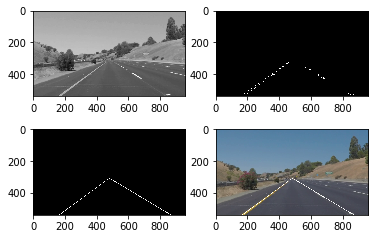

In [51]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [52]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

t:   0%|                                                                             | 0/221 [00:00<?, ?it/s, now=None]

Slope & intercept:  [[0.599250936329588, 16.65168539325839], [0.645320197044335, -6.64039408866995], [0.6470588235294118, -9.058823529411768], [0.5875, 27.149999999999977]]
Slope:  0.6197824892258337 Intercept:  7.025616943794162
Slope & intercept:  [[-0.752, 665.904], [-0.7019607843137254, 642.9686274509804], [-0.7254098360655737, 649.6516393442623], [-0.7251461988304093, 647.6023391812865], [-0.7068965517241379, 647.7241379310344]]
Slope:  -0.7222826741867692 Intercept:  650.7701487815127
Coef:  0.6197824892258337 Intercept:  7.025616943794162 intersection_x:  479.66712003819936
Point one:  (479, 304) Point two:  (960, 602)
Coef:  -0.7222826741867692 Intercept:  650.7701487815127 intersection_x:  479.66712003819936
Point one:  (479, 304) Point two:  (0, 650)
(540, 960, 3)
Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



t:   1%|▌                                                                    | 2/221 [00:00<00:25,  8.72it/s, now=None]

Slope & intercept:  [[0.599250936329588, 16.65168539325839], [0.645320197044335, -6.64039408866995], [0.6470588235294118, -9.058823529411768], [0.5875, 27.149999999999977]]
Slope:  0.6197824892258337 Intercept:  7.025616943794162
Slope & intercept:  [[-0.752, 665.904], [-0.7019607843137254, 642.9686274509804], [-0.7254098360655737, 649.6516393442623], [-0.7251461988304093, 647.6023391812865], [-0.7068965517241379, 647.7241379310344]]
Slope:  -0.7222826741867692 Intercept:  650.7701487815127
Coef:  0.6197824892258337 Intercept:  7.025616943794162 intersection_x:  479.66712003819936
Point one:  (479, 304) Point two:  (960, 602)
Coef:  -0.7222826741867692 Intercept:  650.7701487815127 intersection_x:  479.66712003819936
Point one:  (479, 304) Point two:  (0, 650)
(540, 960, 3)


t:   1%|▉                                                                    | 3/221 [00:00<00:24,  8.76it/s, now=None]

Slope & intercept:  [[0.6465116279069767, -8.302325581395337], [0.6022304832713755, 15.263940520446056], [0.6, 21.19999999999999], [0.589041095890411, 26.83561643835617], [0.660377358490566, -16.396226415094304], [0.6029411764705882, 13.823529411764753]]
Slope:  0.6081448767078703 Intercept:  13.764152157834326
Slope & intercept:  [[-0.7535211267605634, 667.0985915492957], [-0.7241379310344828, 646.6206896551724], [-0.7028985507246377, 643.304347826087], [-0.7049180327868853, 641.8688524590164], [-0.7016393442622951, 643.9475409836066]]
Slope:  -0.7174229971137729 Intercept:  648.5680044946357
Coef:  0.6081448767078703 Intercept:  13.764152157834326 intersection_x:  478.89200158921096
Point one:  (478, 304) Point two:  (960, 597)
Coef:  -0.7174229971137729 Intercept:  648.5680044946357 intersection_x:  478.89200158921096
Point one:  (478, 304) Point two:  (0, 648)
(540, 960, 3)
Slope & intercept:  [[0.601010101010101, 15.590909090909122], [0.6470588235294118, -8.411764705882376], [0.59

t:   2%|█▌                                                                   | 5/221 [00:02<01:18,  2.76it/s, now=None]

Slope & intercept:  [[0.6007326007326007, 16.564102564102598], [0.625, 7.0], [0.6233766233766234, 10.0], [0.6140350877192983, 15.31578947368422], [0.5844155844155844, 25.597402597402606]]
Slope:  0.6095119792488213 Intercept:  14.895458927037884
Slope & intercept:  [[-0.7678571428571429, 668.7678571428571], [-0.6875, 639.75], [-0.7209302325581395, 652.7441860465116], [-0.6991869918699187, 640.1382113821138], [-0.6974789915966386, 638.5882352941176]]
Slope:  -0.7145906717763679 Intercept:  647.99769797312
Coef:  0.6095119792488213 Intercept:  14.895458927037884 intersection_x:  478.1368261410106
Point one:  (478, 306) Point two:  (960, 600)
Coef:  -0.7145906717763679 Intercept:  647.99769797312 intersection_x:  478.1368261410106
Point one:  (478, 306) Point two:  (0, 647)
(540, 960, 3)
Slope & intercept:  [[0.6268656716417911, 6.417910447761187], [0.5977859778597786, 17.926199261992622], [0.6, 15.600000000000023], [0.6241610738255033, 6.979865771812115], [0.6254416961130742, 7.0]]
Slope

t:   5%|███                                                                 | 10/221 [00:02<00:43,  4.80it/s, now=None]


Slope & intercept:  [[0.6227758007117438, 8.017793594306056], [0.6007462686567164, 15.149253731343265], [0.5969387755102041, 18.433673469387713], [0.6122448979591837, 3.5102040816326507]]
Slope:  0.6081764357094621 Intercept:  11.277731219167421
Slope & intercept:  [[-0.6936936936936937, 636.1441441441441], [-0.7232142857142857, 652.8928571428571], [-0.7524271844660194, 663.3155339805826]]
Slope:  -0.7231117212913328 Intercept:  650.7841784225279
Coef:  0.6081764357094621 Intercept:  11.277731219167421 intersection_x:  480.36666129749
Point one:  (480, 303) Point two:  (960, 595)
Coef:  -0.7231117212913328 Intercept:  650.7841784225279 intersection_x:  480.36666129749
Point one:  (480, 303) Point two:  (0, 650)
(540, 960, 3)
Slope & intercept:  [[0.6263345195729537, 6.241992882562272], [0.6, 17.0], [0.5985130111524164, 17.687732342007394], [0.5980861244019139, 17.066985645933016], [0.6078431372549019, 22.54901960784315], [0.6153846153846154, 14.53846153846149]]
Slope:  0.6039653776387

t:   6%|████▎                                                               | 14/221 [00:02<00:27,  7.61it/s, now=None]

(540, 960, 3)
Slope & intercept:  [[0.602112676056338, 20.18309859154931], [0.6455026455026455, -0.7354497354497198], [0.6439393939393939, -0.9772727272726911], [0.6590909090909091, -11.568181818181813]]
Slope:  0.6376614061473217 Intercept:  1.7255485776612716
Slope & intercept:  [[-0.6772151898734177, 634.9050632911392], [-0.7803030303030303, 675.1439393939394], [-0.6756756756756757, 636.7027027027027], [-0.6994535519125683, 642.4535519125683]]
Slope:  -0.7081618619411729 Intercept:  647.3013143250873
Coef:  0.6376614061473217 Intercept:  1.7255485776612716 intersection_x:  479.68836700553777
Point one:  (479, 307) Point two:  (960, 613)
Coef:  -0.7081618619411729 Intercept:  647.3013143250873 intersection_x:  479.68836700553777
Point one:  (479, 307) Point two:  (0, 647)
(540, 960, 3)
Slope & intercept:  [[0.6037735849056604, 20.56603773584908], [0.6470588235294118, -0.41176470588237635], [0.6153846153846154, 12.69230769230768], [0.6205128205128205, 9.548717948717922], [0.6497461928

t:   7%|████▉                                                               | 16/221 [00:02<00:21,  9.34it/s, now=None]

 [[0.6490384615384616, -2.649038461538453], [0.6223021582733813, 6.931654676258972], [0.652542372881356, -5.550847457627128], [0.6239316239316239, 6.239316239316224]]
Slope:  0.6369536541562058 Intercept:  1.2427712491024039
Slope & intercept:  [[-0.6993243243243243, 639.4020270270271], [-0.7258687258687259, 655.8996138996139], [-0.7314814814814815, 657.9629629629629]]
Slope:  -0.7188915105581772 Intercept:  651.0882012965347
Coef:  0.6369536541562058 Intercept:  1.2427712491024039 intersection_x:  479.29177088913855
Point one:  (479, 306) Point two:  (960, 612)
Coef:  -0.7188915105581772 Intercept:  651.0882012965347 intersection_x:  479.29177088913855
Point one:  (479, 306) Point two:  (0, 651)
(540, 960, 3)
Slope & intercept:  [[0.6507936507936508, -5.4126984126984325], [0.6244541484716157, 4.445414847161544], [0.6236162361623616, 4.560885608856097], [0.6379310344827587, 1.36206896551721], [0.6513157894736842, -4.848684210526301]]
Slope:  0.6376221718768142 Intercept:  0.02139735966

t:  10%|██████▊                                                             | 22/221 [00:03<00:14, 13.59it/s, now=None]

(540, 960, 3)
Slope & intercept:  [[0.6538461538461539, -8.461538461538453], [0.6231343283582089, 4.597014925373173], [0.6701030927835051, -19.865979381443253]]
Slope:  0.6490278583292892 Intercept:  -7.910167639202844
Slope & intercept:  [[-0.7025316455696202, 645.1708860759494], [-0.6545454545454545, 621.8909090909091]]
Slope:  -0.6785385500575374 Intercept:  633.5308975834292
Coef:  0.6490278583292892 Intercept:  -7.910167639202844 intersection_x:  483.1706053801633
Point one:  (483, 305) Point two:  (960, 615)
Coef:  -0.6785385500575374 Intercept:  633.5308975834292 intersection_x:  483.1706053801633
Point one:  (483, 305) Point two:  (0, 633)
(540, 960, 3)
Slope & intercept:  [[0.6227106227106227, 6.205128205128176], [0.6492537313432836, -4.932835820895491], [0.6535947712418301, -6.444444444444457], [0.65234375, -6.0078125]]
Slope:  0.6444757188239341 Intercept:  -2.794991140052943
Slope & intercept:  [[-0.7252252252252253, 654.7027027027027], [-0.6976744186046512, 637.79069767441

t:  11%|███████▋                                                            | 25/221 [00:03<00:12, 15.71it/s, now=None]

 [[0.6245487364620939, 5.63537906137185], [0.6498194945848376, -3.4007220216606697], [0.6690140845070423, -16.7042253521127], [0.6379310344827587, 6.120689655172384]]
Slope:  0.6453283375091831 Intercept:  -2.087219664307284
Slope & intercept:  [[-0.723404255319149, 655.6595744680851], [-0.6770833333333334, 633.75], [-0.7272727272727273, 652.6363636363636]]
Slope:  -0.7092534386417366 Intercept:  647.3486460348163
Coef:  0.6453283375091831 Intercept:  -2.087219664307284 intersection_x:  479.4364409246026
Point one:  (479, 307) Point two:  (960, 617)
Coef:  -0.7092534386417366 Intercept:  647.3486460348163 intersection_x:  479.4364409246026
Point one:  (479, 307) Point two:  (0, 647)
(540, 960, 3)
Slope & intercept:  [[0.6254545454545455, 4.861818181818137], [0.6666666666666666, -16.333333333333314], [0.65, -4.75], [0.6538461538461539, -6.653846153846132], [0.6119402985074627, 12.223880597014954]]
Slope:  0.6415815328949657 Intercept:  -2.130296141669271
Slope & intercept:  [[-0.7014218

t:  14%|█████████▌                                                          | 31/221 [00:03<00:10, 18.32it/s, now=None]


Slope & intercept:  [[0.6223021582733813, 6.931654676258972], [0.6502732240437158, -5.202185792349724], [0.6346153846153846, 8.730769230769283], [0.6346153846153846, -4.596153846153811], [0.6363636363636364, 5.636363636363626], [0.6388888888888888, -6.055555555555543], [0.6818181818181818, -29.0], [0.6363636363636364, -3.181818181818187]]
Slope:  0.6362031875948612 Intercept:  0.32329630964494527
Slope & intercept:  [[-0.75, 661.25], [-0.7213114754098361, 657.016393442623], [-0.676056338028169, 635.0], [-0.6764705882352942, 633.1764705882354], [-0.75, 665.5]]
Slope:  -0.7147676803346599 Intercept:  650.3885728061716
Coef:  0.6362031875948612 Intercept:  0.32329630964494527 intersection_x:  481.1837856228592
Point one:  (481, 306) Point two:  (960, 611)
Coef:  -0.7147676803346599 Intercept:  650.3885728061716 intersection_x:  481.1837856228592
Point one:  (481, 306) Point two:  (0, 650)
(540, 960, 3)
Slope & intercept:  [[0.6231343283582089, 5.220149253731336], [0.648936170212766, -3.5

t:  15%|██████████▍                                                         | 34/221 [00:03<00:09, 18.85it/s, now=None]


Slope & intercept:  [[0.6528925619834711, -6.81818181818187], [0.6231343283582089, 4.350746268656735], [0.6666666666666666, -17.333333333333314], [0.6235294117647059, 4.858823529411779], [0.6341463414634146, 4.243902439024396], [0.6474820143884892, -3.9424460431654325]]
Slope:  0.636236931591658 Intercept:  0.5385688751491216
Slope & intercept:  [[-0.728110599078341, 655.5622119815669], [-0.7013574660633484, 639.89592760181]]
Slope:  -0.7147340325708447 Intercept:  647.7290697916884
Coef:  0.636236931591658 Intercept:  0.5385688751491216 intersection_x:  479.05581843333493
Point one:  (479, 305) Point two:  (960, 611)
Coef:  -0.7147340325708447 Intercept:  647.7290697916884 intersection_x:  479.05581843333493
Point one:  (479, 305) Point two:  (0, 647)
(540, 960, 3)
Slope & intercept:  [[0.6213235294117647, 5.904411764705856], [0.6509090909090909, -6.159999999999968], [0.6502242152466368, -6.72645739910314], [0.6417910447761194, -12.014925373134304], [0.6346153846153846, -4.9038461538

t:  18%|████████████▎                                                       | 40/221 [00:03<00:08, 21.27it/s, now=None]


Slope & intercept:  [[0.6218181818181818, 6.9672727272727], [0.6517857142857143, -3.9375], [0.6235955056179775, 7.056179775280896], [0.6524822695035462, -5.517730496453908]]
Slope:  0.6374204178063549 Intercept:  1.142055501524922
Slope & intercept:  [[-0.728110599078341, 657.8433179723502], [-0.675, 633.625], [-0.6746987951807228, 632.3614457831325], [-0.6778846153846154, 634.1826923076924]]
Slope:  -0.6889235024109198 Intercept:  639.5031140157937
Coef:  0.6374204178063549 Intercept:  1.142055501524922 intersection_x:  481.29376459892524
Point one:  (481, 307) Point two:  (960, 613)
Coef:  -0.6889235024109198 Intercept:  639.5031140157937 intersection_x:  481.29376459892524
Point one:  (481, 307) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.6510791366906474, -4.348920863309331], [0.6219512195121951, 7.231707317073187], [0.624390243902439, 6.600000000000023], [0.6222222222222222, 7.46666666666664], [0.6694915254237288, -15.22881355932202], [0.6351351351351351, 8.6081081

t:  19%|█████████████▏                                                      | 43/221 [00:04<00:07, 22.53it/s, now=None]

Coef:  -0.6968356433404148 Intercept:  643.5170231039758 intersection_x:  481.1248763795933
Point one:  (481, 308) Point two:  (0, 643)
(540, 960, 3)
Slope & intercept:  [[0.6268656716417911, 3.0298507462686644], [0.6556291390728477, -8.95364238410599], [0.6502732240437158, -4.327868852459005]]
Slope:  0.6442560115861182 Intercept:  -3.4172201634321104
Slope & intercept:  [[-0.6962962962962963, 638.4592592592593], [-0.675, 635.25], [-0.7570093457943925, 661.9719626168225]]
Slope:  -0.7094352140302297 Intercept:  645.227073958694
Coef:  0.6442560115861182 Intercept:  -3.4172201634321104 intersection_x:  479.1670964896685
Point one:  (479, 305) Point two:  (960, 615)
Coef:  -0.7094352140302297 Intercept:  645.227073958694 intersection_x:  479.1670964896685
Point one:  (479, 305) Point two:  (0, 645)
(540, 960, 3)
Slope & intercept:  [[0.625, 4.25], [0.6687116564417178, -17.15337423312883], [0.6851851851851852, -29.574074074074133], [0.6363636363636364, 7.636363636363626], [0.612903225806

t:  22%|███████████████                                                     | 49/221 [00:04<00:07, 24.07it/s, now=None]


Slope:  0.6689462740709641 Intercept:  -19.807316176922882
Slope & intercept:  [[-0.7567567567567568, 663.6756756756756], [-0.7227722772277227, 645.950495049505], [-0.7553191489361702, 663.968085106383], [-0.7, 637.1]]
Slope:  -0.7337120457301625 Intercept:  652.6735639578909
Coef:  0.6689462740709641 Intercept:  -19.807316176922882 intersection_x:  479.43313823580377
Point one:  (479, 300) Point two:  (960, 622)
Coef:  -0.7337120457301625 Intercept:  652.6735639578909 intersection_x:  479.43313823580377
Point one:  (479, 300) Point two:  (0, 652)
(540, 960, 3)
Slope & intercept:  [[0.6285714285714286, 2.1999999999999886], [0.67, -17.879999999999995], [0.6818181818181818, -28.272727272727252], [0.6119402985074627, 12.208955223880594], [0.6904761904761905, -34.54761904761904], [0.6129032258064516, 12.903225806451587], [0.7209302325581395, -55.441860465116235], [0.6923076923076923, -35.07692307692304]]
Slope:  0.655431002498201 Intercept:  -12.637869766705307
Slope & intercept:  [[-0.75

t:  25%|████████████████▉                                                   | 55/221 [00:04<00:06, 25.30it/s, now=None]


Slope:  0.6454361859848746 Intercept:  -6.736159356448771
Slope & intercept:  [[-0.7013888888888888, 637.8958333333334], [-0.7520325203252033, 660.3739837398374], [-0.7547169811320755, 659.5094339622642], [-0.6739130434782609, 628.8913043478261], [-0.676923076923077, 631.5538461538462]]
Slope:  -0.7117949021495011 Intercept:  643.6448803074215
Coef:  0.6454361859848746 Intercept:  -6.736159356448771 intersection_x:  479.196980786722
Point one:  (479, 302) Point two:  (960, 612)
Coef:  -0.7117949021495011 Intercept:  643.6448803074215 intersection_x:  479.196980786722
Point one:  (479, 302) Point two:  (0, 643)
(540, 960, 3)
Slope & intercept:  [[0.6268656716417911, 3.283582089552226], [0.6711111111111111, -19.693333333333328], [0.65625, -9.1875], [0.6065573770491803, 14.770491803278674], [0.5816326530612245, 32.122448979591866], [0.691358024691358, -32.54320987654319], [0.6730038022813688, -20.266159695817464]]
Slope:  0.6438255199765762 Intercept:  -4.501954290467316
Slope & intercep

t:  26%|█████████████████▊                                                  | 58/221 [00:04<00:06, 25.38it/s, now=None]

 [[0.6720647773279352, -19.0445344129555], [0.626984126984127, 3.182539682539698], [0.6119402985074627, 11.955223880597032], [0.6885245901639344, -33.032786885245855], [0.6428571428571429, -8.714285714285722], [0.6739130434782609, -19.739130434782624]]
Slope:  0.6527139965531438 Intercept:  -10.898828980688828
Slope & intercept:  [[-0.7254901960784313, 648.7058823529412], [-0.6235294117647059, 609.1294117647059], [-0.7704918032786885, 666.8360655737705], [-0.6956521739130435, 633.695652173913], [-0.7235294117647059, 649.6294117647059]]
Slope:  -0.7287908962587173 Intercept:  649.7167529663326
Coef:  0.6527139965531438 Intercept:  -10.898828980688828 intersection_x:  478.1854811982825
Point one:  (478, 301) Point two:  (960, 615)
Coef:  -0.7287908962587173 Intercept:  649.7167529663326 intersection_x:  478.1854811982825
Point one:  (478, 301) Point two:  (0, 649)
(540, 960, 3)
Slope & intercept:  [[0.6254681647940075, 4.6029962546816705], [0.6745562130177515, -20.881656804733723], [0.66

t:  29%|███████████████████▋                                                | 64/221 [00:04<00:06, 24.92it/s, now=None]


Slope & intercept:  [[0.6727272727272727, -16.672727272727286], [0.6284403669724771, 5.082568807339442], [0.6280487804878049, 6.042682926829286], [0.6129032258064516, 14.161290322580612], [0.6904761904761905, -31.64285714285711]]
Slope:  0.6465191672940394 Intercept:  -4.605808471767011
Slope & intercept:  [[-0.6508620689655172, 621.0948275862069], [-0.7239583333333334, 649.0260416666667], [-0.6747572815533981, 628.495145631068], [-0.6990740740740741, 642.3796296296296]]
Slope:  -0.6871629394815807 Intercept:  635.2489111283928
Coef:  0.6465191672940394 Intercept:  -4.605808471767011 intersection_x:  479.76554259028507
Point one:  (479, 305) Point two:  (960, 616)
Coef:  -0.6871629394815807 Intercept:  635.2489111283928 intersection_x:  479.76554259028507
Point one:  (479, 305) Point two:  (0, 635)
(540, 960, 3)
Slope & intercept:  [[0.6739130434782609, -16.30434782608694], [0.6460176991150443, -6.88495575221242], [0.6455026455026455, -5.227513227513214]]
Slope:  0.6551444626986501 In

t:  30%|████████████████████▌                                               | 67/221 [00:04<00:06, 24.62it/s, now=None]

-12.035483674615072
Slope & intercept:  [[-0.6666666666666666, 625.3333333333333], [-0.6486486486486487, 622.972972972973], [-0.6967213114754098, 640.4344262295082], [-0.734375, 649.890625]]
Slope:  -0.6866029066976813 Intercept:  634.6578393839536
Coef:  0.6584288080248967 Intercept:  -12.035483674615072 intersection_x:  480.80154243199655
Point one:  (480, 304) Point two:  (960, 620)
Coef:  -0.6866029066976813 Intercept:  634.6578393839536 intersection_x:  480.80154243199655
Point one:  (480, 304) Point two:  (0, 634)
(540, 960, 3)
Slope & intercept:  [[0.6415094339622641, -1.5283018867924625], [0.6741573033707865, -15.808988764044955], [0.6725978647686833, -14.202846975089017], [0.6623376623376623, -17.090909090909065], [0.6666666666666666, -22.333333333333258], [0.6818181818181818, -32.86363636363632]]
Slope:  0.6665145188207074 Intercept:  -17.304669402300846
Slope & intercept:  [[-0.6923076923076923, 639.3076923076923], [-0.647887323943662, 616.7183098591549], [-0.700729927007299

t:  33%|██████████████████████▍                                             | 73/221 [00:05<00:05, 25.27it/s, now=None]

 [[0.6751824817518248, -17.350364963503637], [0.6262135922330098, 7.597087378640765], [0.6237623762376238, 8.198019801980195]]
Slope:  0.6417194834074862 Intercept:  -0.5184192609608923
Slope & intercept:  [[-0.6736842105263158, 624.1473684210526], [-0.6976744186046512, 639.0697674418604], [-0.6456692913385826, 615.8661417322835]]
Slope:  -0.6723426401565166 Intercept:  626.3610925317322
Coef:  0.6417194834074862 Intercept:  -0.5184192609608923 intersection_x:  477.0546997370784
Point one:  (477, 305) Point two:  (960, 615)
Coef:  -0.6723426401565166 Intercept:  626.3610925317322 intersection_x:  477.0546997370784
Point one:  (477, 305) Point two:  (0, 626)
(540, 960, 3)
Slope & intercept:  [[0.6272189349112426, 8.0], [0.6726618705035972, -14.928057553956876], [0.625, 7.25], [0.675, -15.850000000000023], [0.645, -4.965000000000032]]
Slope:  0.6489761610829679 Intercept:  -4.098611510791386
Slope & intercept:  [[-0.673202614379085, 630.248366013072], [-0.6747967479674797, 625.9918699186

t:  36%|████████████████████████▎                                           | 79/221 [00:05<00:05, 25.69it/s, now=None]

 (0, 626)
(540, 960, 3)
Slope & intercept:  [[0.675, -15.5], [0.6462093862815884, -4.462093862815891], [0.6484375, -5.421875], [0.6590909090909091, -16.295454545454504], [0.6666666666666666, -20.66666666666663]]
Slope:  0.6590808924078329 Intercept:  -12.469218014987405
Slope & intercept:  [[-0.6503267973856209, 617.1928104575163], [-0.6981818181818182, 637.84], [-0.6509433962264151, 618.066037735849], [-0.660377358490566, 620.0], [-0.6737967914438503, 629.144385026738]]
Slope:  -0.6667252323456541 Intercept:  624.4486466440206
Coef:  0.6590808924078329 Intercept:  -12.469218014987405 intersection_x:  480.4004543103412
Point one:  (480, 304) Point two:  (960, 620)
Coef:  -0.6667252323456541 Intercept:  624.4486466440206 intersection_x:  480.4004543103412
Point one:  (480, 304) Point two:  (0, 624)
(540, 960, 3)
Slope & intercept:  [[0.6762589928057554, -16.179856115107896], [0.645320197044335, -3.6699507389162704], [0.6245059288537549, 11.51778656126487], [0.6742081447963801, -15.44343

t:  37%|█████████████████████████▏                                          | 82/221 [00:05<00:05, 26.03it/s, now=None]

Slope:  -0.6243180578286962 Intercept:  608.1248636115657
Coef:  0.6817129123291672 Intercept:  -19.784648614830928 intersection_x:  480.77689317773184
Point one:  (480, 307) Point two:  (960, 634)
Coef:  -0.6243180578286962 Intercept:  608.1248636115657 intersection_x:  480.77689317773184
Point one:  (480, 307) Point two:  (0, 608)
(540, 960, 3)
Slope & intercept:  [[0.6540284360189573, -7.113744075829345], [0.6974169741697417, -28.0], [0.6351351351351351, 3.702702702702709], [0.6995515695067265, -30.035874439461907], [0.64, 2.0399999999999636], [0.6379310344827587, 2.586206896551687]]
Slope:  0.6606771915522199 Intercept:  -9.470118152672816
Slope & intercept:  [[-0.6206896551724138, 605.0], [-0.6458333333333334, 619.0833333333334]]
Slope:  -0.6332614942528736 Intercept:  612.0416666666667
Coef:  0.6606771915522199 Intercept:  -9.470118152672816 intersection_x:  480.32552982418383
Point one:  (480, 307) Point two:  (960, 624)
Coef:  -0.6332614942528736 Intercept:  612.0416666666667 i

t:  40%|███████████████████████████                                         | 88/221 [00:05<00:05, 25.45it/s, now=None]

Coef:  -0.6632644137460539 Intercept:  620.9876585947862 intersection_x:  476.90259366727497
Point one:  (476, 304) Point two:  (0, 620)
(540, 960, 3)
Slope & intercept:  [[0.7, -29.0], [0.6708074534161491, -19.111801242236027], [0.6619718309859155, -11.718309859154942], [0.6851851851851852, -27.5555555555556], [0.6923076923076923, -37.307692307692264], [0.6851851851851852, -28.444444444444457]]
Slope:  0.6825762245133545 Intercept:  -25.522967234847215
Slope & intercept:  [[-0.625, 608.75], [-0.6767241379310345, 630.3146551724137], [-0.6071428571428571, 602.9642857142857], [-0.6977777777777778, 635.2533333333333]]
Slope:  -0.6516611932129173 Intercept:  619.3205685550081
Coef:  0.6825762245133545 Intercept:  -25.522967234847215 intersection_x:  483.304940502088
Point one:  (483, 304) Point two:  (960, 629)
Coef:  -0.6516611932129173 Intercept:  619.3205685550081 intersection_x:  483.304940502088
Point one:  (483, 304) Point two:  (0, 619)
(540, 960, 3)
Slope & intercept:  [[0.69888475

t:  41%|████████████████████████████                                        | 91/221 [00:05<00:05, 25.53it/s, now=None]


Slope & intercept:  [[0.7007874015748031, -28.937007874015762], [0.6494845360824743, -1.7216494845361012], [0.6714975845410628, -17.71014492753625], [0.6875, -26.3125]]
Slope:  0.677317380549585 Intercept:  -18.670325571522028
Slope & intercept:  [[-0.6923076923076923, 631.6923076923076], [-0.6764705882352942, 629.6470588235294], [-0.6422764227642277, 617.9674796747968], [-0.6444444444444445, 614.3333333333334]]
Slope:  -0.6638747869379146 Intercept:  623.4100448809918
Coef:  0.677317380549585 Intercept:  -18.670325571522028 intersection_x:  478.73853279008074
Point one:  (478, 305) Point two:  (960, 631)
Coef:  -0.6638747869379146 Intercept:  623.4100448809918 intersection_x:  478.73853279008074
Point one:  (478, 305) Point two:  (0, 623)
(540, 960, 3)
Slope & intercept:  [[0.7012448132780082, -29.30705394190869], [0.6496062992125984, -2.0866141732283268], [0.6585365853658537, -10.073170731707307], [0.6491228070175439, -0.7719298245614254], [0.6727272727272727, -18.399999999999977]]


t:  44%|█████████████████████████████▊                                      | 97/221 [00:06<00:05, 23.63it/s, now=None]


Slope & intercept:  [[0.7055555555555556, -33.0555555555556], [0.6766917293233082, -21.30075187969925], [0.7105263157894737, -35.10526315789468], [0.6716981132075471, -18.83773584905657], [0.684931506849315, -17.534246575342422], [0.6896551724137931, -21.896551724137964]]
Slope:  0.6898430655231654 Intercept:  -24.621684123614415
Slope & intercept:  [[-0.6727272727272727, 631.4545454545455], [-0.6510067114093959, 618.1879194630873], [-0.625, 609.75]]
Slope:  -0.6495779947122229 Intercept:  619.7974883058777
Coef:  0.6898430655231654 Intercept:  -24.621684123614415 intersection_x:  481.117694473344
Point one:  (481, 307) Point two:  (960, 637)
Coef:  -0.6495779947122229 Intercept:  619.7974883058777 intersection_x:  481.117694473344
Point one:  (481, 307) Point two:  (0, 619)
(540, 960, 3)
Slope & intercept:  [[0.7029702970297029, -31.40594059405936], [0.6532258064516129, -5.193548387096769], [0.6941176470588235, -32.64705882352939], [0.6755725190839694, -21.72519083969462], [0.7123287

t:  45%|██████████████████████████████▎                                    | 100/221 [00:06<00:05, 22.53it/s, now=None]


Slope & intercept:  [[0.7239819004524887, -47.87782805429862], [0.6753246753246753, -23.194805194805213], [0.6758893280632411, -23.988142292490124], [0.7380952380952381, -59.428571428571445]]
Slope:  0.7033227854839108 Intercept:  -38.62233674254135
Slope & intercept:  [[-0.6488294314381271, 615.6454849498327], [-0.7, 637.8], [-0.6733333333333333, 630.3066666666666]]
Slope:  -0.6740542549238201 Intercept:  627.9173838721664
Coef:  0.7033227854839108 Intercept:  -38.62233674254135 intersection_x:  483.919581247992
Point one:  (483, 301) Point two:  (960, 636)
Coef:  -0.6740542549238201 Intercept:  627.9173838721664 intersection_x:  483.919581247992
Point one:  (483, 301) Point two:  (0, 627)
(540, 960, 3)
Slope & intercept:  [[0.6756756756756757, -24.918918918918905], [0.7235772357723578, -48.54471544715449], [0.6532663316582915, -7.4422110552764025], [0.660377358490566, -11.433962264150864], [0.7063492063492064, -35.5555555555556], [0.6666666666666666, -18.333333333333314]]
Slope:  0.

t:  47%|███████████████████████████████▏                                   | 103/221 [00:06<00:05, 21.92it/s, now=None]


Slope & intercept:  [[0.7243589743589743, -48.08974358974359], [0.6745098039215687, -23.19215686274515], [0.6758893280632411, -23.664031620553374], [0.7212121212121212, -46.90303030303028]]
Slope:  0.6989925568889763 Intercept:  -35.4622405940181
Slope & intercept:  [[-0.6989247311827957, 641.516129032258], [-0.65, 618.95]]
Slope:  -0.6744623655913979 Intercept:  630.233064516129
Coef:  0.6989925568889763 Intercept:  -35.4622405940181 intersection_x:  484.6866789832045
Point one:  (484, 303) Point two:  (960, 635)
Coef:  -0.6744623655913979 Intercept:  630.233064516129 intersection_x:  484.6866789832045
Point one:  (484, 303) Point two:  (0, 630)
(540, 960, 3)
Slope & intercept:  [[0.704225352112676, -34.12676056338023], [0.6756756756756757, -23.162162162162133], [0.6745098039215687, -23.19215686274515], [0.6896551724137931, -25.44827586206901], [0.6885245901639344, -25.52459016393442], [0.7008547008547008, -31.094017094017033]]
Slope:  0.6889075491903914 Intercept:  -27.0913271180513

t:  49%|█████████████████████████████████                                  | 109/221 [00:06<00:05, 19.44it/s, now=None]

Slope & intercept:  [[0.6710526315789473, -21.881578947368382], [0.703125, -36.15625], [0.7024390243902439, -34.487804878048735], [0.7032520325203252, -35.853658536585385], [0.6896551724137931, -37.48275862068965]]
Slope:  0.6939047721806619 Intercept:  -33.17241019653843
Slope & intercept:  [[-0.6518987341772152, 620.3544303797469], [-0.660377358490566, 630.7735849056603], [-0.6729559748427673, 631.1949685534591]]
Slope:  -0.6617440225035162 Intercept:  627.4409946129555
Coef:  0.6939047721806619 Intercept:  -33.17241019653843 intersection_x:  487.30423941651884
Point one:  (487, 304) Point two:  (960, 632)
Coef:  -0.6617440225035162 Intercept:  627.4409946129555 intersection_x:  487.30423941651884
Point one:  (487, 304) Point two:  (0, 627)
(540, 960, 3)
Slope & intercept:  [[0.7007874015748031, -35.24409448818898], [0.6504065040650406, -7.430894308943095], [0.6615384615384615, -17.0], [0.6379310344827587, 3.155172413793082], [0.7202797202797203, -47.32167832167835], [0.6739130434782

t:  50%|█████████████████████████████████▋                                 | 111/221 [00:06<00:06, 17.58it/s, now=None]

 [[0.7023809523809523, -36.54761904761904], [0.6733870967741935, -25.29838709677415], [0.6758241758241759, -26.384615384615415], [0.6842105263157895, -22.42105263157896], [0.7045454545454546, -37.31818181818187]]
Slope:  0.6880696411681131 Intercept:  -29.593971195753888
Slope & intercept:  [[-0.673728813559322, 627.7245762711864], [-0.6764705882352942, 637.3823529411765], [-0.6688741721854304, 629.682119205298], [-0.6785714285714286, 632.0], [-0.698744769874477, 643.8200836820083]]
Slope:  -0.6792779544851905 Intercept:  634.1218264199339
Coef:  0.6880696411681131 Intercept:  -29.593971195753888 intersection_x:  485.40385760401443
Point one:  (485, 304) Point two:  (960, 630)
Coef:  -0.6792779544851905 Intercept:  634.1218264199339 intersection_x:  485.40385760401443
Point one:  (485, 304) Point two:  (0, 634)
(540, 960, 3)
Slope & intercept:  [[0.7007874015748031, -35.24409448818898], [0.672, -24.136000000000024], [0.6756756756756757, -25.945945945945937], [0.6857142857142857, -22.22

t:  52%|███████████████████████████████████▏                               | 116/221 [00:07<00:05, 18.21it/s, now=None]

 [[0.7007874015748031, -35.24409448818898], [0.6733870967741935, -25.29838709677415], [0.6705202312138728, -22.58381502890171], [0.703125, -36.15625]]
Slope:  0.6869549323907174 Intercept:  -29.82063665346621
Slope & intercept:  [[-0.6511627906976745, 624.2093023255813], [-0.7279411764705882, 651.1029411764706], [-0.7254901960784313, 650.9411764705883], [-0.673728813559322, 632.6101694915254], [-0.7265625, 649.1640625], [-0.6483516483516484, 624.2307692307693]]
Slope:  -0.6922061875262774 Intercept:  638.7097368658225
Coef:  0.6869549323907174 Intercept:  -29.82063665346621 intersection_x:  484.736963553268
Point one:  (484, 303) Point two:  (960, 629)
Coef:  -0.6922061875262774 Intercept:  638.7097368658225 intersection_x:  484.736963553268
Point one:  (484, 303) Point two:  (0, 638)
(540, 960, 3)
Slope & intercept:  [[0.6711111111111111, -24.639999999999986], [0.6980392156862745, -33.69411764705882], [0.7, -35.599999999999966], [0.6851851851851852, -32.259259259259295], [0.6536312849

t:  53%|███████████████████████████████████▊                               | 118/221 [00:07<00:05, 18.62it/s, now=None]

 [[0.6708074534161491, -26.15527950310559], [0.7, -37.099999999999966], [0.6717171717171717, -27.9292929292929], [0.6995708154506438, -37.746781115879855]]
Slope:  0.6855238601459912 Intercept:  -32.23283838706958
Slope & intercept:  [[-0.6981132075471698, 641.5471698113207], [-0.676056338028169, 628.7887323943662], [-0.6735751295336787, 627.2279792746114], [-0.6710526315789473, 631.0263157894736]]
Slope:  -0.6796993266719912 Intercept:  632.147549317443
Coef:  0.6855238601459912 Intercept:  -32.23283838706958 intersection_x:  486.6459888166921
Point one:  (486, 301) Point two:  (960, 625)
Coef:  -0.6796993266719912 Intercept:  632.147549317443 intersection_x:  486.6459888166921
Point one:  (486, 301) Point two:  (0, 632)
(540, 960, 3)
Slope & intercept:  [[0.6967213114754098, -35.70491803278691], [0.649402390438247, -11.745019920318725], [0.6363636363636364, -0.36363636363637397], [0.6379310344827587, -2.6034482758620925], [0.6865671641791045, -28.417910447761187], [0.6982758620689655

t:  56%|█████████████████████████████████████▎                             | 123/221 [00:07<00:05, 19.51it/s, now=None]

 [[0.6487804878048781, -12.165853658536605], [0.6751269035532995, -21.121827411167544], [0.6885245901639344, -29.721311475409834], [0.6746987951807228, -20.180722891566234], [0.6610169491525424, -20.016949152542395], [0.6666666666666666, -22.66666666666663]]
Slope:  0.6652579604716219 Intercept:  -19.23040395609588
Slope & intercept:  [[-0.722972972972973, 648.3581081081081], [-0.6521739130434783, 620.7826086956522], [-0.6744186046511628, 634.2790697674418], [-0.6285714285714286, 613.2285714285714]]
Slope:  -0.6695342298097606 Intercept:  629.1620894999434
Coef:  0.6652579604716219 Intercept:  -19.23040395609588 intersection_x:  485.76287618176286
Point one:  (485, 303) Point two:  (960, 619)
Coef:  -0.6695342298097606 Intercept:  629.1620894999434 intersection_x:  485.76287618176286
Point one:  (485, 303) Point two:  (0, 629)
(540, 960, 3)
Slope & intercept:  [[0.6458333333333334, -9.041666666666686], [0.6742424242424242, -19.92424242424238], [0.6666666666666666, -27.0], [0.6666666666

t:  58%|██████████████████████████████████████▊                            | 128/221 [00:07<00:04, 19.56it/s, now=None]

 [[0.6706349206349206, -18.626984126984098], [0.6274509803921569, 3.4117647058823763], [0.6071428571428571, 15.035714285714334], [0.6012658227848101, 20.886075949367125], [0.671875, -18.59375]]
Slope:  0.6356739161909489 Intercept:  0.4225641627959476
Slope & intercept:  [[-0.6497005988023952, 622.7604790419161], [-0.7003257328990228, 644.7491856677525], [-0.6777777777777778, 637.7555555555556], [-0.6993464052287581, 642.9019607843137], [-0.632183908045977, 618.3563218390805], [-0.6551724137931034, 622.2413793103449]]
Slope:  -0.6690844727578392 Intercept:  631.4608136998272
Coef:  0.6356739161909489 Intercept:  0.4225641627959476 intersection_x:  483.64375725182595
Point one:  (483, 307) Point two:  (960, 610)
Coef:  -0.6690844727578392 Intercept:  631.4608136998272 intersection_x:  483.64375725182595
Point one:  (483, 307) Point two:  (0, 631)
(540, 960, 3)
Slope & intercept:  [[0.6730769230769231, -21.000000000000057], [0.6259842519685039, 3.4094488188976584], [0.625, 2.75], [0.6733

t:  59%|███████████████████████████████████████▍                           | 130/221 [00:07<00:04, 18.45it/s, now=None]

Slope & intercept:  [[0.623574144486692, 2.973384030418231], [0.6496350364963503, -6.094890510948915], [0.65, -6.050000000000011]]
Slope:  0.6410697269943474 Intercept:  -3.057168826843565
Slope & intercept:  [[-0.6711711711711712, 630.0540540540541], [-0.6986301369863014, 645.5616438356165], [-0.6986301369863014, 646.2602739726027], [-0.6995305164319249, 641.7887323943662]]
Slope:  -0.6989302634681759 Intercept:  644.5368834008617
Coef:  0.6410697269943474 Intercept:  -3.057168826843565 intersection_x:  483.2791468932604
Point one:  (483, 306) Point two:  (960, 612)
Coef:  -0.6989302634681759 Intercept:  644.5368834008617 intersection_x:  483.2791468932604
Point one:  (483, 306) Point two:  (0, 644)
(540, 960, 3)
Slope & intercept:  [[0.6231343283582089, 4.350746268656735], [0.6502242152466368, -7.026905829596387], [0.6507352941176471, -6.665441176470608], [0.6376811594202898, -7.565217391304316], [0.64, -10.840000000000032]]
Slope:  0.6403549994285564 Intercept:  -5.549363625742922
S

t:  61%|████████████████████████████████████████▉                          | 135/221 [00:08<00:04, 19.02it/s, now=None]

 [[0.6211453744493393, 5.524229074889831], [0.6521739130434783, -7.52173913043481], [0.6326530612244898, -5.081632653061206], [0.6204379562043796, 6.664233576642346], [0.6496350364963503, -6.394160583941584]]
Slope:  0.6352090682836075 Intercept:  -1.3618139431810845
Slope & intercept:  [[-0.6737967914438503, 634.6631016042782], [-0.711864406779661, 654.1525423728814], [-0.7261146496815286, 658.7515923566879], [-0.6935483870967742, 639.741935483871], [-0.7235294117647059, 653.929411764706]]
Slope:  -0.7137642138306675 Intercept:  651.6438704945365
Coef:  0.6352090682836075 Intercept:  -1.3618139431810845 intersection_x:  484.0760696270038
Point one:  (484, 306) Point two:  (960, 608)
Coef:  -0.7137642138306675 Intercept:  651.6438704945365 intersection_x:  484.0760696270038
Point one:  (484, 306) Point two:  (0, 651)
(540, 960, 3)
Slope & intercept:  [[0.6525096525096525, -6.498069498069526], [0.6226415094339622, 4.773584905660414], [0.6193181818181818, 7.937500000000057], [0.636363636

t:  62%|█████████████████████████████████████████▊                         | 138/221 [00:08<00:04, 20.25it/s, now=None]

Coef:  -0.7197208520443854 Intercept:  650.7393894681406 intersection_x:  481.2626292093629
Point one:  (481, 304) Point two:  (0, 650)
(540, 960, 3)
Slope & intercept:  [[0.6231155778894473, 1.6381909547738474], [0.6502242152466368, -9.780269058295971], [0.6404494382022472, -12.853932584269671], [0.6619718309859155, -17.718309859154942], [0.6417910447761194, -14.865671641791039], [0.6208333333333333, 2.220833333333303], [0.6346153846153846, 2.942307692307736]]
Slope:  0.635171499010528 Intercept:  -5.1164235506569655
Slope & intercept:  [[-0.725752508361204, 655.8461538461538], [-0.6995073891625616, 639.8817733990147], [-0.7, 638.4], [-0.7254237288135593, 654.793220338983]]
Slope:  -0.7126709065843312 Intercept:  647.2302868960378
Coef:  0.635171499010528 Intercept:  -5.1164235506569655 intersection_x:  483.9933123774859
Point one:  (483, 302) Point two:  (960, 604)
Coef:  -0.7126709065843312 Intercept:  647.2302868960378 intersection_x:  483.9933123774859
Point one:  (483, 302) Point

t:  65%|███████████████████████████████████████████▋                       | 144/221 [00:08<00:03, 22.88it/s, now=None]

Slope & intercept:  [[0.6468401486988847, -5.992565055762043], [0.6210045662100456, 4.260273972602761], [0.625, 0.875], [0.6666666666666666, -19.0]]
Slope:  0.6398778453938992 Intercept:  -4.9643227707898205
Slope & intercept:  [[-0.722488038277512, 655.9569377990431], [-0.6995305164319249, 642.586854460094]]
Slope:  -0.7110092773547184 Intercept:  649.2718961295685
Coef:  0.6398778453938992 Intercept:  -4.9643227707898205 intersection_x:  484.30117356452376
Point one:  (484, 304) Point two:  (960, 609)
Coef:  -0.7110092773547184 Intercept:  649.2718961295685 intersection_x:  484.30117356452376
Point one:  (484, 304) Point two:  (0, 649)
(540, 960, 3)
Slope & intercept:  [[0.6509090909090909, -7.112727272727284], [0.6211453744493393, 5.039647577092467], [0.6119402985074627, 12.119402985074657], [0.6503067484662577, -6.300613496932556], [0.6304347826086957, 3.9130434782608745]]
Slope:  0.6329472589881693 Intercept:  1.5317506541536319
Slope & intercept:  [[-0.6737588652482269, 634.64539

t:  67%|████████████████████████████████████████████▌                      | 147/221 [00:08<00:03, 23.49it/s, now=None]

Coef:  -0.7083760807064544 Intercept:  650.5166281665622 intersection_x:  485.2226884876116
Point one:  (485, 306) Point two:  (0, 650)
(540, 960, 3)
Slope & intercept:  [[0.622568093385214, 2.346303501945499], [0.649402390438247, -8.705179282868528], [0.6526717557251909, -9.896946564885525], [0.6179775280898876, 6.067415730337132], [0.6363636363636364, -10.0]]
Slope:  0.6357966808004352 Intercept:  -4.037681323094285
Slope & intercept:  [[-0.7017543859649122, 645.8070175438596], [-0.7528089887640449, 667.7865168539325], [-0.752, 665.112], [-0.6770833333333334, 637.6875], [-0.75, 669.5]]
Slope:  -0.7391408436822393 Intercept:  662.0513835994481
Coef:  0.6357966808004352 Intercept:  -4.037681323094285 intersection_x:  484.4504227005957
Point one:  (484, 303) Point two:  (960, 606)
Coef:  -0.7391408436822393 Intercept:  662.0513835994481 intersection_x:  484.4504227005957
Point one:  (484, 303) Point two:  (0, 662)
(540, 960, 3)
Slope & intercept:  [[0.6463878326996197, -7.55133079847905

t:  69%|██████████████████████████████████████████████▍                    | 153/221 [00:08<00:03, 21.78it/s, now=None]

 [[0.6023622047244095, 13.342519685039349], [0.6458333333333334, -9.041666666666686], [0.6456692913385826, -8.362204724409423], [0.6065573770491803, 11.295081967213093], [0.6619718309859155, -22.7042253521127]]
Slope:  0.6324788074862842 Intercept:  -3.0940990181872734
Slope & intercept:  [[-0.7, 643.7], [-0.7608695652173914, 667.3478260869565], [-0.751937984496124, 666.8837209302326], [-0.75, 667.0], [-0.7222222222222222, 650.8333333333334], [-0.7013888888888888, 646.1458333333333], [-0.752, 665.4]]
Slope:  -0.7340598086892323 Intercept:  658.1872448119793
Coef:  0.6324788074862842 Intercept:  -3.0940990181872734 intersection_x:  483.90973808034164
Point one:  (483, 302) Point two:  (960, 604)
Coef:  -0.7340598086892323 Intercept:  658.1872448119793 intersection_x:  483.90973808034164
Point one:  (483, 302) Point two:  (0, 658)
(540, 960, 3)
Slope & intercept:  [[0.603112840466926, 12.085603112840488], [0.6446700507614214, -8.64467005076142], [0.6463414634146342, -11.39024390243901], 

t:  71%|███████████████████████████████████████████████▎                   | 156/221 [00:09<00:03, 21.01it/s, now=None]

 -0.7358287378702788 Intercept:  661.6053096031793
Coef:  0.6268454460577386 Intercept:  1.3408150510932302 intersection_x:  484.53585041790456
Point one:  (484, 305) Point two:  (960, 603)
Coef:  -0.7358287378702788 Intercept:  661.6053096031793 intersection_x:  484.53585041790456
Point one:  (484, 305) Point two:  (0, 661)
(540, 960, 3)
Slope & intercept:  [[0.6484375, -10.875], [0.6190476190476191, 2.2857142857142776], [0.6326530612244898, -10.061224489795961], [0.6349206349206349, -10.23809523809524], [0.5367647058823529, 69.8235294117647]]
Slope:  0.6143647042150193 Intercept:  8.186984793917555
Slope & intercept:  [[-0.7, 644.0], [-0.7284768211920529, 659.4701986754967], [-0.7803030303030303, 678.6969696969697]]
Slope:  -0.736259950498361 Intercept:  660.7223894574888
Coef:  0.6143647042150193 Intercept:  8.186984793917555 intersection_x:  483.1360085027084
Point one:  (483, 305) Point two:  (960, 597)
Coef:  -0.736259950498361 Intercept:  660.7223894574888 intersection_x:  483.1

t:  72%|████████████████████████████████████████████████▏                  | 159/221 [00:09<00:02, 21.69it/s, now=None]

 [[0.6224489795918368, -3.153061224489818], [0.6465863453815262, -11.598393574297233], [0.6470588235294118, -11.0], [0.5925925925925926, 18.259259259259295], [0.6206896551724138, -2.6206896551724412]]
Slope:  0.6258752792535562 Intercept:  -2.0225770389400397
Slope & intercept:  [[-0.6974789915966386, 644.327731092437], [-0.7766497461928934, 675.9390862944163], [-0.6763005780346821, 637.2485549132948], [-0.7533632286995515, 669.0538116591928]]
Slope:  -0.7259481361309414 Intercept:  656.6422959898352
Coef:  0.6258752792535562 Intercept:  -2.0225770389400397 intersection_x:  487.24179913796803
Point one:  (487, 302) Point two:  (960, 598)
Coef:  -0.7259481361309414 Intercept:  656.6422959898352 intersection_x:  487.24179913796803
Point one:  (487, 302) Point two:  (0, 656)
(540, 960, 3)
Slope & intercept:  [[0.6032388663967612, 10.37246963562751], [0.6446700507614214, -10.446700507614253], [0.6019900497512438, 11.860696517412919], [0.6612903225806451, -24.790322580645125], [0.6666666666

t:  75%|██████████████████████████████████████████████████                 | 165/221 [00:09<00:02, 21.24it/s, now=None]

(540, 960, 3)
Slope & intercept:  [[0.5974025974025974, 11.675324675324703], [0.6264591439688716, -0.38132295719844933], [0.6234309623430963, 2.3179916317991456], [0.5945945945945946, 12.972972972972968]]
Slope:  0.61047182457729 Intercept:  6.646241580724592
Slope & intercept:  [[-0.7777777777777778, 684.0], [-0.7297297297297297, 659.4864864864865], [-0.8117647058823529, 696.035294117647], [-0.7534246575342466, 668.068493150685]]
Slope:  -0.7681742177310267 Intercept:  676.8975684387046
Coef:  0.61047182457729 Intercept:  6.646241580724592 intersection_x:  486.16635908645134
Point one:  (486, 303) Point two:  (960, 592)
Coef:  -0.7681742177310267 Intercept:  676.8975684387046 intersection_x:  486.16635908645134
Point one:  (486, 303) Point two:  (0, 676)
(540, 960, 3)
Slope & intercept:  [[0.6244725738396625, 0.08016877637129483], [0.5765765765765766, 25.56756756756755], [0.582089552238806, 22.85074626865668], [0.5686274509803921, 32.470588235294144], [0.6382978723404256, -8.382978723

t:  76%|██████████████████████████████████████████████████▉                | 168/221 [00:09<00:02, 20.35it/s, now=None]


Slope & intercept:  [[0.6166666666666667, 6.5166666666666515], [0.5764705882352941, 26.670588235294133], [0.6078431372549019, 13.215686274509835], [0.5769230769230769, 26.846153846153868], [0.6, 18.400000000000034]]
Slope:  0.5955806938159879 Intercept:  18.329819004524904
Slope & intercept:  [[-0.7272727272727273, 660.4545454545455], [-0.7761194029850746, 683.5671641791045], [-0.7285714285714285, 659.1428571428571]]
Slope:  -0.7439878529430768 Intercept:  667.7215222588358
Coef:  0.5955806938159879 Intercept:  18.329819004524904 intersection_x:  484.7767625071827
Point one:  (484, 307) Point two:  (960, 590)
Coef:  -0.7439878529430768 Intercept:  667.7215222588358 intersection_x:  484.7767625071827
Point one:  (484, 307) Point two:  (0, 667)
(540, 960, 3)
Slope & intercept:  [[0.5993031358885017, 20.202090592334514], [0.5757575757575758, 28.45454545454544], [0.5892857142857143, 24.857142857142833]]
Slope:  0.5881154753105973 Intercept:  24.504592968007596
Slope & intercept:  [[-0.721

t:  77%|███████████████████████████████████████████████████▊               | 171/221 [00:09<00:02, 20.42it/s, now=None]

(540, 960, 3)
Slope & intercept:  [[0.5986159169550173, 20.79584775086505], [0.575091575091575, 30.043956043956086], [0.6020761245674741, 19.010380622837374]]
Slope:  0.5919278722046887 Intercept:  23.28339480588617
Slope & intercept:  [[-0.7286245353159851, 662.453531598513], [-0.808, 694.296], [-0.8363636363636363, 703.3090909090909], [-0.7049180327868853, 658.8688524590164], [-0.8095238095238095, 696.3333333333334], [-0.7272727272727273, 660.6363636363636]]
Slope:  -0.7691171235438407 Intercept:  679.3161953227195
Coef:  0.5919278722046887 Intercept:  23.28339480588617 intersection_x:  482.00669527169987
Point one:  (482, 308) Point two:  (960, 591)
Coef:  -0.7691171235438407 Intercept:  679.3161953227195 intersection_x:  482.00669527169987
Point one:  (482, 308) Point two:  (0, 679)
(540, 960, 3)
Slope & intercept:  [[0.5757575757575758, 29.030303030303003], [0.6, 20.19999999999999], [0.5833333333333334, 24.833333333333314]]
Slope:  0.5863636363636364 Intercept:  24.68787878787877


t:  80%|█████████████████████████████████████████████████████▋             | 177/221 [00:10<00:02, 20.60it/s, now=None]


Slope & intercept:  [[0.6021505376344086, 18.344086021505348], [0.5763358778625954, 27.94274809160305], [0.5897435897435898, 19.435897435897402], [0.6086956521739131, 8.0], [0.5671641791044776, 36.46268656716421], [0.5652173913043478, 37.08695652173918], [0.5849056603773585, 28.24528301886795]]
Slope:  0.5809195393377963 Intercept:  27.919609609462857
Slope & intercept:  [[-0.781021897810219, 679.5839416058394], [-0.7819548872180451, 684.5714285714286], [-0.8083333333333333, 696.9416666666666], [-0.75, 668.0]]
Slope:  -0.7803275295903993 Intercept:  682.2742592109837
Coef:  0.5809195393377963 Intercept:  27.919609609462857 intersection_x:  480.7023387141172
Point one:  (480, 307) Point two:  (960, 585)
Coef:  -0.7803275295903993 Intercept:  682.2742592109837 intersection_x:  480.7023387141172
Point one:  (480, 307) Point two:  (0, 682)
(540, 960, 3)
Slope & intercept:  [[0.6021505376344086, 18.139784946236546], [0.5762081784386617, 28.47955390334573], [0.5543071161048689, 45.838951310

t:  81%|██████████████████████████████████████████████████████▌            | 180/221 [00:10<00:01, 21.21it/s, now=None]


Slope & intercept:  [[0.5756457564575646, 29.553505535055365], [0.6035714285714285, 16.514285714285734], [0.5909090909090909, 26.545454545454504], [0.5862068965517241, 19.79310344827593], [0.5882352941176471, 29.70588235294116]]
Slope:  0.5852492595090067 Intercept:  26.39948647043174
Slope & intercept:  [[-0.7571428571428571, 672.0714285714286], [-0.8076923076923077, 697.7692307692307], [-0.8085106382978723, 691.5744680851064], [-0.8632478632478633, 717.7777777777778]]
Slope:  -0.8091484165952251 Intercept:  694.7982263008859
Coef:  0.5852492595090067 Intercept:  26.39948647043174 intersection_x:  479.34585038744075
Point one:  (479, 306) Point two:  (960, 588)
Coef:  -0.8091484165952251 Intercept:  694.7982263008859 intersection_x:  479.34585038744075
Point one:  (479, 306) Point two:  (0, 694)
(540, 960, 3)
Slope & intercept:  [[0.6022304832713755, 17.070631970260195], [0.5767790262172284, 27.973782771535582]]
Slope:  0.589504754744302 Intercept:  22.52220737089789
Slope & intercep

t:  84%|████████████████████████████████████████████████████████▍          | 186/221 [00:10<00:01, 21.81it/s, now=None]

(540, 960, 3)
Slope & intercept:  [[0.5714285714285714, 29.428571428571445], [0.6007462686567164, 15.951492537313413], [0.5770750988142292, 25.403162055335997], [0.6193548387096774, 3.670967741935442]]
Slope:  0.5921511944022986 Intercept:  18.613548440789074
Slope & intercept:  [[-0.7806691449814126, 679.3011152416357], [-0.8359375, 705.1875], [-0.8372093023255814, 706.4418604651163], [-0.7818181818181819, 685.8909090909091]]
Slope:  -0.808908532281294 Intercept:  694.2053461994153
Coef:  0.5921511944022986 Intercept:  18.613548440789074 intersection_x:  482.2005692489641
Point one:  (482, 304) Point two:  (960, 587)
Coef:  -0.808908532281294 Intercept:  694.2053461994153 intersection_x:  482.2005692489641
Point one:  (482, 304) Point two:  (0, 694)
(540, 960, 3)
Slope & intercept:  [[0.6010928961748634, 16.6502732240437], [0.5793650793650794, 23.9444444444444], [0.6481481481481481, 1.5740740740740762], [0.589041095890411, 23.219178082191775], [0.5918367346938775, 22.30612244897958], 

t:  86%|█████████████████████████████████████████████████████████▎         | 189/221 [00:10<00:01, 21.16it/s, now=None]


Slope & intercept:  [[0.5758754863813229, 27.198443579766547], [0.6037735849056604, 14.509433962264154], [0.6036585365853658, 15.231707317073187], [0.5909090909090909, 21.863636363636317], [0.5777777777777777, 26.088888888888903]]
Slope:  0.5903988953118435 Intercept:  20.978422022325823
Slope & intercept:  [[-0.8378378378378378, 708.2432432432432], [-0.7530864197530864, 668.9135802469136], [-0.7839506172839507, 685.320987654321], [-0.8413793103448276, 707.8275862068965], [-0.7792207792207793, 677.6493506493507]]
Slope:  -0.7990949928880964 Intercept:  689.590949600145
Coef:  0.5903988953118435 Intercept:  20.978422022325823 intersection_x:  481.1914131151686
Point one:  (481, 305) Point two:  (960, 587)
Coef:  -0.7990949928880964 Intercept:  689.590949600145 intersection_x:  481.1914131151686
Point one:  (481, 305) Point two:  (0, 689)
(540, 960, 3)
Slope & intercept:  [[0.5761316872427984, 24.66666666666663], [0.6, 15.600000000000023], [0.5748031496062992, 26.850393700787436], [0.60

t:  87%|██████████████████████████████████████████████████████████▏        | 192/221 [00:10<00:01, 20.82it/s, now=None]


Slope & intercept:  [[0.5530973451327433, 36.893805309734546], [0.5963855421686747, 12.71686746987956], [0.58, 25.28000000000003], [0.553921568627451, 35.88725490196077]]
Slope:  0.5708511139822172 Intercept:  27.694481920393727
Slope & intercept:  [[-0.7517241379310344, 666.0275862068966], [-0.8653846153846154, 711.4615384615385], [-0.8412698412698413, 704.6825396825398], [-0.7032967032967034, 648.901098901099]]
Slope:  -0.7904188244705487 Intercept:  682.7681908130185
Coef:  0.5708511139822172 Intercept:  27.694481920393727 intersection_x:  481.22248966813197
Point one:  (481, 302) Point two:  (960, 575)
Coef:  -0.7904188244705487 Intercept:  682.7681908130185 intersection_x:  481.22248966813197
Point one:  (481, 302) Point two:  (0, 682)
(540, 960, 3)
Slope & intercept:  [[0.5797101449275363, 26.275362318840564], [0.5555555555555556, 35.77777777777777]]
Slope:  0.567632850241546 Intercept:  31.026570048309168
Slope & intercept:  [[-0.7528735632183908, 668.3103448275863], [-0.807228

t:  90%|████████████████████████████████████████████████████████████       | 198/221 [00:11<00:01, 20.71it/s, now=None]

(540, 960, 3)
Slope & intercept:  [[0.6021897810218978, 15.697080291970792], [0.5793650793650794, 23.9444444444444], [0.5897435897435898, 22.56410256410254]]
Slope:  0.590432816710189 Intercept:  20.73520910017258
Slope & intercept:  [[-0.7508896797153025, 670.9074733096086], [-0.8361344537815126, 704.5546218487395], [-0.7545787545787546, 673.3150183150183], [-0.8378378378378378, 705.6756756756756]]
Slope:  -0.7948601814783518 Intercept:  688.6131972872606
Coef:  0.590432816710189 Intercept:  20.73520910017258 intersection_x:  482.12038107492737
Point one:  (482, 305) Point two:  (960, 587)
Coef:  -0.7948601814783518 Intercept:  688.6131972872606 intersection_x:  482.12038107492737
Point one:  (482, 305) Point two:  (0, 688)
(540, 960, 3)
Slope & intercept:  [[0.599290780141844, 19.014184397163092], [0.5769230769230769, 26.846153846153868], [0.6007326007326007, 17.36630036630038], [0.5773584905660377, 27.460377358490575]]
Slope:  0.5885762370908899 Intercept:  22.67175399202698
Slope &

t:  91%|████████████████████████████████████████████████████████████▉      | 201/221 [00:11<00:00, 20.81it/s, now=None]


Slope & intercept:  [[0.5985401459854015, 17.67153284671531], [0.5609756097560976, 36.75609756097555], [0.5990566037735849, 16.221698113207538], [0.5428571428571428, 48.514285714285734], [0.5591397849462365, 39.24731182795705], [0.51, 70.55000000000001]]
Slope:  0.5617615478864105 Intercept:  38.16015434385687
Slope & intercept:  [[-0.8391608391608392, 707.979020979021], [-0.8068965517241379, 689.6482758620689], [-0.7029702970297029, 648.990099009901]]
Slope:  -0.7830092293048935 Intercept:  682.205798616997
Coef:  0.5617615478864105 Intercept:  38.16015434385687 intersection_x:  478.9259665638314
Point one:  (478, 307) Point two:  (960, 577)
Coef:  -0.7830092293048935 Intercept:  682.205798616997 intersection_x:  478.9259665638314
Point one:  (478, 307) Point two:  (0, 682)
(540, 960, 3)
Slope & intercept:  [[0.5736434108527132, 28.45736434108528], [0.5985401459854015, 17.8686131386861], [0.589041095890411, 15.20547945205476], [0.6101694915254238, 11.559322033898297]]
Slope:  0.59284

t:  94%|██████████████████████████████████████████████████████████████▊    | 207/221 [00:11<00:00, 22.78it/s, now=None]

Slope & intercept:  [[0.5782312925170068, 32.04761904761904], [0.5574468085106383, 38.08510638297872], [0.5833333333333334, 26.75], [0.5686274509803921, 37.60784313725492], [0.5555555555555556, 39.111111111111086], [0.5652173913043478, 37.304347826086996], [0.5765765765765766, 33.225225225225245]]
Slope:  0.5692840583968357 Intercept:  34.87589324718228
Slope & intercept:  [[-0.8357142857142857, 706.4285714285714], [-0.7286821705426356, 660.2945736434108], [-0.7777777777777778, 677.2222222222222], [-0.7835820895522388, 679.9925373134329]]
Slope:  -0.7814390808967345 Intercept:  680.9844761519093
Coef:  0.5692840583968357 Intercept:  34.87589324718228 intersection_x:  478.3427218420516
Point one:  (478, 307) Point two:  (960, 581)
Coef:  -0.7814390808967345 Intercept:  680.9844761519093 intersection_x:  478.3427218420516
Point one:  (478, 307) Point two:  (0, 680)
(540, 960, 3)
Slope & intercept:  [[0.5551020408163265, 38.40816326530614], [0.5972850678733032, 15.669683257918564], [0.555

t:  95%|███████████████████████████████████████████████████████████████▋   | 210/221 [00:11<00:00, 22.43it/s, now=None]

Coef:  -0.7997070566369235 Intercept:  687.3011072879696 intersection_x:  477.5202028480458
Point one:  (477, 305) Point two:  (0, 687)
(540, 960, 3)
Slope & intercept:  [[0.5763358778625954, 27.94274809160305], [0.5511111111111111, 38.142222222222244], [0.5531914893617021, 37.361702127659555], [0.5633802816901409, 39.6056338028169]]
Slope:  0.5558942940543181 Intercept:  38.36985271756623
Slope & intercept:  [[-0.8379446640316206, 704.7509881422925], [-0.7884615384615384, 679.3461538461538], [-0.6756756756756757, 634.1891891891892], [-0.6785714285714286, 636.2142857142858], [-0.78125, 677.28125]]
Slope:  -0.7523806613480527 Intercept:  666.3563733783842
Coef:  0.5558942940543181 Intercept:  38.36985271756623 intersection_x:  480.01111545216077
Point one:  (480, 305) Point two:  (960, 572)
Coef:  -0.7523806613480527 Intercept:  666.3563733783842 intersection_x:  480.01111545216077
Point one:  (480, 305) Point two:  (0, 666)
(540, 960, 3)
Slope & intercept:  [[0.5762081784386617, 28.631

t:  98%|█████████████████████████████████████████████████████████████████▍ | 216/221 [00:11<00:00, 22.90it/s, now=None]


Slope & intercept:  [[0.5774647887323944, 30.253521126760575], [0.5524193548387096, 39.7177419354839], [0.5671641791044776, 35.791044776119406], [0.5551181102362205, 38.283464566929126]]
Slope:  0.5630416082279505 Intercept:  36.01144310132325
Slope & intercept:  [[-0.7043478260869566, 650.3391304347826], [-0.8357487922705314, 706.4444444444445], [-0.7549019607843137, 668.6666666666667], [-0.8064516129032258, 693.5806451612902]]
Slope:  -0.7753625480112569 Intercept:  679.7577216767961
Coef:  0.5630416082279505 Intercept:  36.01144310132325 intersection_x:  480.98048379074123
Point one:  (480, 306) Point two:  (960, 576)
Coef:  -0.7753625480112569 Intercept:  679.7577216767961 intersection_x:  480.98048379074123
Point one:  (480, 306) Point two:  (0, 679)
(540, 960, 3)
Slope & intercept:  [[0.5774647887323944, 30.408450704225345], [0.5525291828793775, 40.72373540856029], [0.5758620689655173, 32.39310344827584], [0.5534351145038168, 40.46183206106872]]
Slope:  0.5648227887702764 Interc

t:  99%|██████████████████████████████████████████████████████████████████▍| 219/221 [00:11<00:00, 23.13it/s, now=None]

 [[0.5833333333333334, 27.999999999999943], [0.5514705882352942, 42.779411764705856], [0.576271186440678, 33.18644067796612], [0.5641025641025641, 39.84615384615387]]
Slope:  0.5687944180279674 Intercept:  35.953001572206446
Slope & intercept:  [[-0.7534246575342466, 671.8493150684932], [-0.84, 707.0799999999999], [-0.7272727272727273, 662.5454545454545], [-0.7555555555555555, 670.8222222222222]]
Slope:  -0.7690632350906323 Intercept:  678.0742479590424
Coef:  0.5687944180279674 Intercept:  35.953001572206446 intersection_x:  479.96230756689675
Point one:  (479, 308) Point two:  (960, 581)
Coef:  -0.7690632350906323 Intercept:  678.0742479590424 intersection_x:  479.96230756689675
Point one:  (479, 308) Point two:  (0, 678)
(540, 960, 3)
Slope & intercept:  [[0.5757575757575758, 33.636363636363626], [0.5516014234875445, 43.76512455516013], [0.5535055350553506, 41.50553505535049]]
Slope:  0.560288178100157 Intercept:  39.63567441562475
Slope & intercept:  [[-0.7537878787878788, 672.0189


Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 12.6 s


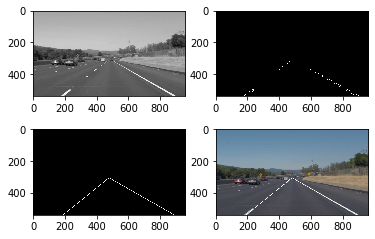

In [53]:
yellow_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidWhiteRight.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [54]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


### Pipeline Description

#### Pipeline Steps:
1. Read in and grayscale the image
2. Define a kernel size and apply Gaussian smoothing
3. Define our parameters for Canny and apply to get edges image
4. Mask edges image using cv2.fillPoly() (ignore everything outside region of interest)
5. Define Hough transform parameters and run Hough transform on masked edge-detected image
6. Draw line segments
7. Draw lines extrapolated from line segments
8. Combine line image with original image to see how accurate the line annotations are.

#### Focus on Step 7 (Drawing lines extrapolated from line segments)
The time I spent the most time on was Step 7, drawing lines extrapolated from line segments. This step required custom code in addition to the helper functions provided.
1. Divide the hough line segments into those with positive slopes (left lane line) and negative slopes (negative lane line). Take only those with length greater than 50 to remove noise.
    * For each Hough line segment (two points), if (1) the slope of the line is positive and (2) if the line segment length is greater than 50 pixels (length chosen by observation), add the slope and intercept to an array `positive_slope_intercept`. I also added the clause that if the array is empty, we should go through the Hough lines again and add at least one pair of points to the array `positive_slope_intercept`. 
    * Do the same for Hough line segments with negative slope.
    * Line segments with positive slope belong to the negative 
2. Fit a line to the points belonging to the left lane line and to the points belonging to the right lane line separately using `find_line_fit`. Get the intercept and coefficient of the fitted lines.
    * If there is only one slope and intercept, return those.
    * Remove noise: remove points with slope not within 1.5 standard deviations of the mean. (1.5 chosen arbitrarily) This may fail if there is only one datapoint (it failed on one frame of the yellow lane line video), which is why I added the clause above.
    * Take the estimate of the slope and intercept to be that of the remaining values.
3. Calculate where the lane lines intersect.
4. Draw the lines from the intersection point to the bottom of the image.


### Shortcomings

* There are a few instances in the yellow lane line video where the lane lines are marked incorrectly. The error is always (to my knowledge) in the lane line that is not solid.
    * I tried adjusting the Hough parameters further but this often resulted in no hough lines being created in at least one frame in the yellow lane line video.
* Image dimensions were hard-coded in at least one case.
* If the lane lines are not straight lines but have high curvature, this algorithm may give weird results.
* The algorithm was trained on a specific type of lane and type of day (daytime, moderately bright with no snow, rain or hail), so it may not generalise well.

### Possible Improvements

* Tune Hough transform parameters more systematically with more test images instead of by 'feel'.
* Currently the lane lines are drawn in solid white. It would be nice if they were drawn in thicker, semi-transparent red (say).

Reflection describes the current pipeline, identifies its potential shortcomings and suggests possible improvements. There is no minimum length. Writing in English is preferred but you may use any language.



I have included some debugging plots below for fun.


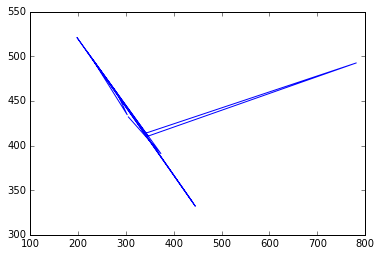

In [95]:
# Debugging plot 1: Plotting the midpoints of the Hough line segments
# for a test image to see why the final line plotted was wrong.
plt.plot([305.0, 373.0, 229.0, 302.5, 281.5, 197.5, 445.0, 339.5, 781.5, 346.0, 217.0, 439.5],
         [432.0, 391.0, 497.5, 434.5, 458.5, 521.0, 332.0, 413.5, 492.5, 410.5, 506.5, 336.5])
plt.show()

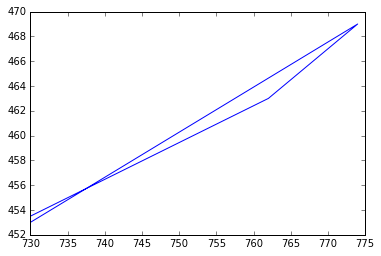

In [96]:
# Debugging plot 2: Plotting the midpoints of the Hough line segments
# for a test image to see why the final line plotted was wrong.
plt.plot([730.0, 762.0, 774.0, 730.0],[453.5, 463.0, 469.0, 453.0])
plt.show()

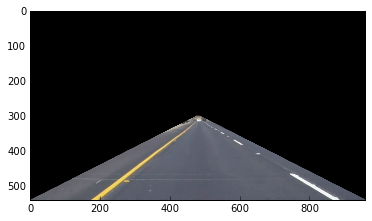

In [97]:
# Debugging mask
border = 80
imshape = [540, 960]
vertices = np.array([[(0,imshape[0]),(475, 300), (485, 300), 
                      (imshape[1],imshape[0])]], 
                    dtype=np.int32)    
plt.imshow(region_of_interest(test_images[5], vertices))

## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

Slope & intercept:  [[0.5757575757575758, 46.272727272727252], [0.60509554140127386, 27.547770700636988], [0.55621301775147924, 63.834319526627269], [0.061403508771929821, 619.32456140350882], [0.34061135371179041, 219.96506550218339], [0.59259259259259256, 27.296296296296305], [0.64792899408284022, -14.76035502958581], [0.32653061224489793, 208.20408163265307], [0.028571428571428571, 673.51428571428573], [0.14035087719298245, 547.70175438596493], [0.36363636363636365, 189.0], [0.48466257668711654, 129.36196319018407], [0.64864864864864868, -14.081081081081095], [0.06363636363636363, 616.56363636363642], [0.55172413793103448, 67.655172413793139], [0.28813559322033899, 240.9830508474576]]
Slope:  0.392218699115 Intercept:  228.023953071
Slope & intercept:  [[-0.72628726287262868, 890.53929539295393], [-0.6718146718146718, 855.96911196911196], [-0.070287539936102233, 461.96805111821084], [-0.2620689655172414, 593.97931034482758], [-0.067073170731707321, 463.0], [-0.25409836065573771, 590








  0%|          | 0/251 [00:00<?, ?it/s]






  0%|          | 1/251 [00:00<00:28,  8.67it/s]

Slope & intercept:  [[0.5757575757575758, 46.272727272727252], [0.60509554140127386, 27.547770700636988], [0.55621301775147924, 63.834319526627269], [0.061403508771929821, 619.32456140350882], [0.34061135371179041, 219.96506550218339], [0.59259259259259256, 27.296296296296305], [0.64792899408284022, -14.76035502958581], [0.32653061224489793, 208.20408163265307], [0.028571428571428571, 673.51428571428573], [0.14035087719298245, 547.70175438596493], [0.36363636363636365, 189.0], [0.48466257668711654, 129.36196319018407], [0.64864864864864868, -14.081081081081095], [0.06363636363636363, 616.56363636363642], [0.55172413793103448, 67.655172413793139], [0.28813559322033899, 240.9830508474576]]
Slope:  0.392218699115 Intercept:  228.023953071
Slope & intercept:  [[-0.72628726287262868, 890.53929539295393], [-0.6718146718146718, 855.96911196911196], [-0.070287539936102233, 461.96805111821084], [-0.2620689655172414, 593.97931034482758], [-0.067073170731707321, 463.0], [-0.25409836065573771, 590








  1%|          | 2/251 [00:00<00:28,  8.79it/s]

(720, 1280, 3)









  1%|          | 3/251 [00:00<00:28,  8.56it/s]

Slope & intercept:  [[0.57894736842105265, 43.10526315789474], [0.59649122807017541, 23.035087719298303], [0.032051282051282048, 671.84615384615381], [0.59909909909909909, 21.779279279279308], [0.21686746987951808, 273.91566265060243], [0.63636363636363635, -5.5454545454545041], [0.061403508771929821, 618.46491228070181], [0.5761316872427984, 42.646090534979407], [0.64864864864864868, -15.540540540540576], [0.14141414141414141, 573.59595959595958], [0.038461538461538464, 673.76923076923072], [0.625, 4.125], [0.022727272727272728, 355.40909090909093], [0.60256410256410253, 26.807692307692321], [0.59649122807017541, 35.368421052631561]]
Slope:  0.398177480786 Intercept:  222.852123268
Slope & intercept:  [[-0.67226890756302526, 856.42857142857144], [-0.72602739726027399, 889.64383561643831], [-0.26250000000000001, 593.5625], [-0.24890829694323144, 588.94323144104806], [-0.070063694267515922, 460.19108280254778], [-0.069565217391304349, 463.53913043478263], [-0.051671732522796353, 699.331








  2%|▏         | 4/251 [00:00<00:28,  8.74it/s]

(720, 1280, 3)









  2%|▏         | 5/251 [00:00<00:28,  8.76it/s]

Slope & intercept:  [[0.67521367521367526, -36.444444444444457], [0.061946902654867256, 618.07964601769913], [0.72388059701492535, -70.067164179104452], [0.016393442622950821, 678.93442622950818], [0.14136125654450263, 573.22513089005236], [0.092307692307692313, 616.12307692307695], [0.25, 261.75], [0.57718120805369133, 42.261744966442905], [0.32380952380952382, 210.50476190476189], [0.34188034188034189, 202.84615384615384], [0.57777777777777772, 47.466666666666697], [0.36206896551724138, 192.13793103448276], [0.625, 3.5], [0.068181818181818177, 336.63636363636363]]
Slope:  0.316394046505 Intercept:  288.232419821
Slope & intercept:  [[-0.69870129870129871, 879.93766233766235], [-0.67346938775510201, 858.75510204081638], [-0.26839826839826841, 596.82683982683989], [-0.071216617210682495, 462.28783382789317], [-0.068965517241379309, 464.27586206896552], [-0.26989619377162632, 600.59861591695505], [-0.67317073170731712, 860.31219512195116], [-0.045454545454545456, 696.09090909090912], [-








  2%|▏         | 6/251 [00:00<00:27,  8.95it/s]

(720, 1280, 3)









  3%|▎         | 7/251 [00:00<00:27,  9.00it/s]

Slope & intercept:  [[0.625, 2.0], [0.64953271028037385, -11.504672897196258], [0.046783625730994149, 631.41520467836256], [0.10062893081761007, 608.47798742138366], [0.048484848484848485, 629.16363636363633], [0.12, 593.12], [0.24107142857142858, 267.91071428571428], [0.60185185185185186, 22.416666666666686], [0.34210526315789475, 201.65789473684211], [0.025974025974025976, 677.98701298701303]]
Slope:  0.239099997177 Intercept:  403.794346349
Slope & intercept:  [[-0.67241379310344829, 861.13793103448279], [-0.69973890339425593, 883.72584856396873], [-0.069364161849710976, 464.40462427745666], [-0.04878048780487805, 696.92682926829264], [-0.071641791044776124, 462.42686567164179], [-0.27064220183486237, 602.85779816513764], [-0.2680115273775216, 597.88760806916423], [-0.64925373134328357, 853.35074626865674], [-0.031847133757961783, 693.70700636942672], [-0.69724770642201839, 869.07339449541291], [-0.25268817204301075, 594.6559139784946], [-0.25225225225225223, 589.24324324324323], [-








  3%|▎         | 8/251 [00:00<00:26,  9.03it/s]

(720, 1280, 3)









  4%|▎         | 9/251 [00:01<00:26,  9.02it/s]

Slope & intercept:  [[0.035714285714285712, 641.85714285714289], [0.60215053763440862, 20.043010752688133], [0.016666666666666666, 655.61666666666667], [0.67346938775510201, -32.979591836734699], [0.32110091743119268, 213.77064220183485], [0.60073260073260071, 22.934065934065927], [0.014285714285714285, 424.68571428571431], [0.34710743801652894, 200.0], [0.32743362831858408, 211.57522123893804], [0.30630630630630629, 221.76576576576576], [0.67592592592592593, -37.277777777777771]]
Slope:  0.356444855344 Intercept:  231.09007819
Slope & intercept:  [[-0.72554347826086951, 895.85869565217388], [-0.67901234567901236, 865.61728395061732], [-0.069486404833836862, 460.79154078549851], [-0.27333333333333332, 599.60666666666668], [-0.27091633466135456, 597.24302788844625], [-0.67713004484304928, 862.90582959641256], [-0.28755364806866951, 607.93562231759654], [-0.032051282051282048, 693.62820512820508], [-0.069364161849710976, 464.40462427745666], [-0.28665207877461707, 608.77024070021878], [-








  4%|▍         | 10/251 [00:01<00:26,  9.06it/s]

(720, 1280, 3)









  4%|▍         | 11/251 [00:01<00:25,  9.24it/s]

Slope & intercept:  [[0.62631578947368416, 8.0789473684210975], [0.57684210526315793, 43.934736842105224], [0.061403508771929821, 618.28070175438597], [0.59999999999999998, 21.400000000000034], [0.59957627118644063, 23.661016949152554], [0.10084033613445378, 610.53781512605042], [0.33050847457627119, 209.37288135593221], [0.30555555555555558, 222.30555555555554], [0.26923076923076922, 256.53846153846155], [0.57796257796257799, 41.553014553014521], [0.34108527131782945, 208.34883720930233], [0.30434782608695654, 224.86956521739128]]
Slope:  0.391139040463 Intercept:  207.406794456
Slope & intercept:  [[-0.69946808510638303, 875.25531914893622], [-0.069182389937106917, 464.55345911949684], [-0.26736842105263159, 600.7410526315789], [-0.72807017543859653, 898.15789473684208], [-0.051446945337620578, 451.08038585209005], [-0.72932330827067671, 900.1503759398496], [-0.065727699530516437, 705.04694835680755], [-0.29896907216494845, 613.28865979381442], [-0.24822695035460993, 586.326241134751








  5%|▍         | 12/251 [00:01<00:25,  9.28it/s]

(720, 1280, 3)









  5%|▌         | 13/251 [00:01<00:25,  9.21it/s]

Slope & intercept:  [[0.62272727272727268, 9.795454545454561], [0.59183673469387754, 26.938775510204096], [0.59740259740259738, 23.233766233766232], [0.64885496183206104, -18.328244274809151], [0.046783625730994149, 632.30409356725147], [0.57971014492753625, 36.840579710144937], [0.17808219178082191, 300.97260273972603], [0.6470588235294118, -14.764705882352985], [0.26000000000000001, 261.13999999999999], [0.32000000000000001, 217.31999999999999], [0.59999999999999998, 21.399999999999977], [0.31192660550458717, 217.66055045871559], [0.26865671641791045, 259.88059701492534], [0.53416149068322982, 73.093167701863365], [0.061946902654867256, 617.89380530973449], [0.21568627450980393, 284.56862745098039], [0.0703125, 636.171875], [0.23999999999999999, 272.36000000000001], [0.30841121495327101, 221.63551401869159], [0.049019607843137254, 659.46078431372553]]
Slope:  0.35762888326 Intercept:  236.978862171
Slope & intercept:  [[-0.70026525198938994, 875.47214854111405], [-0.72499999999999998








  6%|▌         | 14/251 [00:01<00:25,  9.22it/s]

(720, 1280, 3)









  6%|▌         | 15/251 [00:01<00:25,  9.27it/s]

Slope & intercept:  [[0.012903225806451613, 663.27096774193546], [0.57751937984496127, 39.135658914728651], [0.59322033898305082, 33.322033898305108], [0.55555555555555558, 63.444444444444457], [0.59999999999999998, 28.199999999999989], [0.40000000000000002, 179.0], [0.60159362549800799, 25.027888446215115], [0.10294117647058823, 606.07352941176475], [0.34615384615384615, 200.69230769230771], [0.34722222222222221, 204.09722222222223], [0.43103448275862066, 167.13793103448276], [0.18478260869565216, 298.23913043478262], [0.38461538461538464, 184.69230769230768], [0.62173913043478257, 5.8173913043478365], [0.014925373134328358, 680.98507462686564], [0.077777777777777779, 603.82222222222219]]
Slope:  0.365749007997 Intercept:  248.93488188
Slope & intercept:  [[-0.75297619047619047, 908.38690476190482], [-0.69889502762430944, 874.79834254143645], [-0.30420711974110032, 612.01618122977345], [-0.068750000000000006, 462.34375], [-0.070063694267515922, 460.05095541401272], [-0.051282051282051








  6%|▋         | 16/251 [00:01<00:25,  9.15it/s]

(720, 1280, 3)









  7%|▋         | 17/251 [00:01<00:26,  8.98it/s]

Slope & intercept:  [[0.1875, 296.1875], [0.55665024630541871, 58.433497536945822], [0.074999999999999997, 605.47500000000002], [0.59932659932659937, 23.023569023568996], [0.57638888888888884, 46.569444444444457], [0.23134328358208955, 279.73880597014926], [0.3188405797101449, 219.56521739130437], [0.10344827586206896, 604.51724137931035], [0.12437810945273632, 588.51243781094524], [0.34931506849315069, 201.9041095890411]]
Slope:  0.312219105162 Intercept:  292.392682315
Slope & intercept:  [[-0.75211267605633803, 907.37746478873237], [-0.70292887029288698, 875.25104602510464], [-0.28508771929824561, 604.87280701754389], [-0.26779661016949152, 595.51864406779657], [-0.070588235294117646, 462.94117647058823], [-0.067114093959731544, 458.14765100671138], [-0.036529680365296802, 690.10958904109589], [-0.6767676767676768, 867.40404040404042], [-0.73750000000000004, 903.67499999999995], [-0.070588235294117646, 462.08235294117645], [-0.020618556701030927, 688.24742268041234], [-0.01716738197








  7%|▋         | 18/251 [00:02<00:29,  7.87it/s]






  8%|▊         | 19/251 [00:02<00:28,  8.05it/s]

(720, 1280, 3)
Slope & intercept:  [[0.59615384615384615, 33.865384615384642], [0.60301507537688437, 20.613065326633205], [0.5791505791505791, 42.088803088803104], [0.034090909090909088, 641.72727272727275], [0.3263888888888889, 216.40972222222223], [0.60377358490566035, 26.792452830188722], [0.23134328358208955, 278.12686567164178], [0.10328638497652583, 609.40845070422529], [0.24822695035460993, 271.03546099290782], [0.64893617021276595, -16.489361702127667], [0.15238095238095239, 560.35238095238094], [0.28654970760233917, 254.94736842105263], [0.21052631578947367, 285.63157894736844], [0.22689075630252101, 279.0924369747899], [0.03669724770642202, 640.37614678899081], [0.24475524475524477, 271.79720279720277], [0.44444444444444442, 185.88888888888889], [0.017064846416382253, 411.34470989761093]]
Slope:  0.290867001052 Intercept:  295.852834815
Slope & intercept:  [[-0.72432432432432436, 883.91351351351352], [-0.75297619047619047, 909.13988095238096], [-0.06725146198830409, 461.85672








  8%|▊         | 20/251 [00:02<00:28,  8.24it/s]






  8%|▊         | 21/251 [00:02<00:27,  8.49it/s]

(720, 1280, 3)
Slope & intercept:  [[0.57692307692307687, 45.26923076923083], [0.69696969696969702, -51.060606060606119], [0.061946902654867256, 618.2035398230089], [0.67391304347826086, -33.521739130434753], [0.67136150234741787, -28.342723004694847], [0.21212121212121213, 285.33333333333331], [0.24832214765100671, 270.96644295302013]]
Slope:  0.448793940307 Intercept:  158.121068383
Slope & intercept:  [[-0.7528089887640449, 909.33707865168537], [-0.72448979591836737, 884.23469387755108], [-0.28603104212860309, 606.35254988913528], [-0.28368794326241137, 601.87234042553189], [-0.034810126582278479, 444.62658227848101], [-0.070336391437308868, 463.42201834862385], [-0.050632911392405063, 698.4683544303798], [-0.67632850241545894, 862.96618357487921], [-0.018018018018018018, 689.89189189189187], [-0.0695970695970696, 460.1062271062271], [-0.53278688524590168, 782.03278688524597], [-0.016949152542372881, 688.45762711864404], [-0.14492753623188406, 832.95652173913049], [-0.21511627906976








  9%|▉         | 22/251 [00:02<00:25,  8.82it/s]






  9%|▉         | 23/251 [00:02<00:25,  8.95it/s]

(720, 1280, 3)
Slope & intercept:  [[0.60227272727272729, 32.488636363636374], [0.59999999999999998, 32.199999999999989], [0.59999999999999998, 33.800000000000068], [0.60079840319361277, 23.532934131736511], [0.57727272727272727, 52.968181818181847], [0.57581573896353166, 45.057581573896357], [0.12440191387559808, 353.55502392344499], [0.6333333333333333, -6.3333333333333144], [0.18803418803418803, 298.94017094017096], [0.5544554455445545, 67.871287128712822], [0.55092592592592593, 69.666666666666686], [0.34591194968553457, 209.0251572327044], [1.5272727272727273, -499.4909090909091], [0.32575757575757575, 220.52272727272728], [0.62666666666666671, 3.3333333333332575], [0.44311377245508982, 188.76646706586826], [0.15306122448979592, 559.5]]
Slope:  0.468863849529 Intercept:  136.555927132
Slope & intercept:  [[-0.75423728813559321, 909.51694915254234], [-0.69895287958115182, 874.11518324607323], [-0.069767441860465115, 463.60465116279067], [-0.26771653543307089, 600.48031496062993], [-








 10%|▉         | 24/251 [00:02<00:24,  9.13it/s]






 10%|▉         | 25/251 [00:02<00:24,  9.26it/s]

(720, 1280, 3)
Slope & intercept:  [[0.62295081967213117, 11.18032786885243], [0.59999999999999998, 23.200000000000045], [0.026666666666666668, 649.91999999999996], [0.55555555555555558, 67.777777777777715], [0.27027027027027029, 252.59459459459458], [0.3411764705882353, 212.8235294117647], [0.2608695652173913, 248.43478260869566], [0.64668769716088326, -9.5331230283911736], [0.19008264462809918, 297.51239669421489], [0.65000000000000002, -18.200000000000045], [0.08771929824561403, 622.50877192982455], [0.51030927835051543, 93.448453608247462], [0.24539877300613497, 275.10429447852761], [0.066666666666666666, 612.79999999999995], [0.08461538461538462, 622.53076923076924], [0.55223880597014929, 72.044776119402968], [0.67307692307692313, -34.730769230769283], [0.59893048128342241, 24.026737967914471], [0.57692307692307687, 46.153846153846189], [0.027777777777777776, 422.69444444444446]]
Slope:  0.379395807784 Intercept:  224.614580531
Slope & intercept:  [[-0.69895287958115182, 872.71727








 10%|█         | 26/251 [00:02<00:23,  9.43it/s]






 11%|█         | 27/251 [00:03<00:23,  9.39it/s]

(720, 1280, 3)
Slope & intercept:  [[0.013986013986013986, 661.30069930069931], [0.62589928057553956, 8.9784172661870798], [0.64676616915422891, -14.452736318407972], [0.57928802588996764, 42.336569579288039], [0.076923076923076927, 604.30769230769226], [0.62605042016806722, 4.2226890756302282], [0.52000000000000002, 106.15999999999997], [0.62295081967213117, 8.393442622950829], [0.57746478873239437, 57.605633802816897], [0.546875, 96.828125], [0.21052631578947367, 289.63157894736844], [0.54794520547945202, 86.479452054794535], [0.23376623376623376, 279.4545454545455], [0.26911314984709478, 264.00917431192659], [0.092783505154639179, 614.89690721649481], [0.076923076923076927, 603.53846153846155], [0.60204081632653061, 30.663265306122469], [0.48677248677248675, 154.63492063492063], [0.64824120603015079, -14.7286432160804]]
Slope:  0.421279767957 Intercept:  204.434747099
Slope & intercept:  [[-0.7528089887640449, 906.0786516853932], [-0.053691275167785234, 455.24161073825502], [-0.7224








 11%|█         | 28/251 [00:03<00:23,  9.49it/s]






 12%|█▏        | 29/251 [00:03<00:23,  9.49it/s]

(720, 1280, 3)
Slope & intercept:  [[0.60171919770773641, 23.604584527220595], [0.032000000000000001, 643.45600000000002], [0.64983164983164987, -10.595959595959641], [0.60465116279069764, 28.302325581395394], [0.77380952380952384, -108.59523809523807], [0.21656050955414013, 286.29299363057328], [0.58088235294117652, 39.485294117647015], [0.10000000000000001, 608.60000000000002], [0.58088235294117652, 45.264705882352928], [0.19047619047619047, 300.76190476190476], [0.22981366459627328, 284.38509316770188], [0.53439153439153442, 64.428571428571388], [1.5925925925925926, -517.48148148148141], [0.1875, 299.875], [0.061403508771929821, 618.32456140350882], [0.2129032258064516, 290.34838709677422]]
Slope:  0.370454991575 Intercept:  227.595881594
Slope & intercept:  [[-0.69946808510638303, 870.35904255319156], [-0.77941176470588236, 915.04411764705878], [-0.70285714285714285, 879.58857142857141], [-0.033149171270718231, 693.39226519337012], [-0.053459119496855348, 455.08490566037733], [-0.0








 12%|█▏        | 30/251 [00:03<00:23,  9.57it/s]






 12%|█▏        | 31/251 [00:03<00:22,  9.60it/s]

(720, 1280, 3)
Slope & intercept:  [[0.59861591695501726, 27.387543252595208], [0.061403508771929821, 619.14035087719299], [0.57928802588996764, 42.398058252427177], [0.67045454545454541, -25.545454545454504], [0.21518987341772153, 288.27848101265823], [0.64835164835164838, -15.582417582417577], [0.18965517241379309, 300.60344827586209], [0.23076923076923078, 283.69230769230768], [0.64739884393063585, -10.820809248554895], [1.8, -626.20000000000005], [0.57761732851985559, 42.285198555956697]]
Slope:  0.441874409447 Intercept:  155.183670654
Slope & intercept:  [[-0.75433526011560692, 904.51156069364163], [-0.69402985074626866, 868.81343283582089], [-0.051987767584097858, 452.25993883792052], [-0.28444444444444444, 600.88], [-0.72142857142857142, 878.82142857142856], [-0.049450549450549448, 698.26373626373629], [-0.72180451127819545, 879.79699248120301], [-0.052795031055900624, 455.74223602484471], [-0.578125, 811.765625], [-0.23076923076923078, 577.15384615384619], [-0.0173410404624277








 13%|█▎        | 32/251 [00:03<00:22,  9.64it/s]






 13%|█▎        | 33/251 [00:03<00:22,  9.74it/s]

(720, 1280, 3)
Slope & intercept:  [[0.032520325203252036, 642.41463414634143], [0.62333333333333329, 5.7800000000000296], [0.69950738916256161, -52.16748768472911], [0.015228426395939087, 418.62944162436548], [0.62318840579710144, 11.724637681159436], [0.61194029850746268, 23.970149253731392], [0.58156028368794321, 42.546099290780205], [0.5280898876404494, 92.573033707865193], [0.57794676806083645, 42.733840304182536], [0.11627906976744186, 354.62790697674416], [0.081081081081081086, 371.05405405405406], [0.052419354838709679, 400.24596774193549], [0.15625, 325.90625], [0.60240963855421692, 31.012048192771033]]
Slope:  0.378696733002 Intercept:  193.646469664
Slope & intercept:  [[-0.69834710743801653, 869.06198347107443], [-0.70124481327800825, 880.40663900414938], [-0.2670299727520436, 597.30790190735695], [-0.72535211267605637, 891.65492957746483], [-0.26815642458100558, 594.35195530726253], [-0.069486404833836862, 462.58308157099697], [-0.75366568914956011, 902.5777126099706], [-0








 14%|█▎        | 34/251 [00:03<00:22,  9.48it/s]






 14%|█▍        | 35/251 [00:03<00:22,  9.50it/s]

(720, 1280, 3)
Slope & intercept:  [[0.59957173447537471, 27.237687366167052], [0.625, 14.375], [0.59763313609467461, 27.568047337278017], [0.59701492537313428, 36.985074626865696], [0.64921465968586389, -10.513089005235599], [0.037735849056603772, 403.07547169811323], [0.59999999999999998, 24.0], [0.032258064516129031, 409.38709677419354], [0.64516129032258063, -5.8387096774193878], [0.578125, 54.859375], [0.57885304659498205, 45.629032258064512], [0.67479674796747968, -31.260162601626007], [1.6712328767123288, -531.72602739726028], [0.12101910828025478, 344.13375796178343], [0.1404494382022472, 340.01685393258424], [0.60129310344827591, 26.681034482758605], [0.59589041095890416, 33.116438356164338]]
Slope:  0.479626032186 Intercept:  108.715806782
Slope & intercept:  [[-0.69841269841269837, 879.15873015873012], [-0.67519181585677746, 859.19948849104856], [-0.052307692307692305, 452.09846153846155], [-0.26748971193415638, 595.17283950617286], [-0.03125, 693.53125], [-0.052795031055900








 14%|█▍        | 36/251 [00:03<00:22,  9.59it/s]






 15%|█▍        | 37/251 [00:04<00:22,  9.53it/s]

(720, 1280, 3)
Slope & intercept:  [[0.57534246575342463, 50.60273972602738], [0.59868421052631582, 37.671052631578959], [0.031578947368421054, 644.06315789473683], [0.6029411764705882, 34.264705882352928], [0.57342657342657344, 51.111888111888106], [0.036231884057971016, 676.85507246376812], [0.033707865168539325, 408.48314606741576], [0.57763975155279501, 42.248447204968954], [0.57499999999999996, 63.950000000000045], [0.21465968586387435, 293.44502617801049], [0.052631578947368418, 626.1052631578948], [0.140625, 341.890625], [0.55737704918032782, 61.672131147540995], [0.57499999999999996, 62.800000000000011], [0.4642857142857143, 134.5], [0.65116279069767447, -14.883720930232585], [0.57894736842105265, 43.157894736842081], [0.034722222222222224, 679.31944444444446], [0.83823529411764708, -152.92647058823536], [0.28440366972477066, 264.55045871559633], [0.57746478873239437, 45.225352112676035], [0.52542372881355937, 88.322033898305051], [0.24878048780487805, 279.13658536585365], [0.1








 15%|█▌        | 38/251 [00:04<00:22,  9.44it/s]






 16%|█▌        | 39/251 [00:04<00:22,  9.45it/s]

(720, 1280, 3)
Slope & intercept:  [[0.032467532467532464, 643.62337662337666], [0.034013605442176874, 409.08843537414964], [0.57627118644067798, 48.474576271186436], [0.60162601626016265, 23.57723577235771], [0.029411764705882353, 647.61764705882354], [0.48739495798319327, 118.73109243697479], [0.13775510204081631, 341.95408163265307], [0.57742782152230976, 45.905511811023587], [0.031914893617021274, 681.97872340425533], [0.57599999999999996, 63.296000000000049], [0.55223880597014929, 73.626865671641781], [0.5368421052631579, 95.199999999999989], [0.51320754716981132, 91.158490566037756], [0.65217391304347827, -11.52173913043481], [0.012987012987012988, 660.25974025974028], [0.054054054054054057, 655.29729729729729], [0.25, 275.25], [0.61538461538461542, 19.230769230769226], [0.57861635220125784, 50.955974842767318], [0.90322580645161288, -107.0]]
Slope:  0.360515120345 Intercept:  259.668635743
Slope & intercept:  [[-0.26732673267326734, 598.06930693069307], [-0.72602739726027399, 88








 16%|█▌        | 40/251 [00:04<00:22,  9.24it/s]






 16%|█▋        | 41/251 [00:04<00:22,  9.36it/s]

(720, 1280, 3)
Slope & intercept:  [[0.014285714285714285, 658.57142857142856], [0.017341040462427744, 659.35838150289021], [0.55654761904761907, 60.065476190476204], [0.088541666666666671, 371.578125], [0.57309941520467833, 53.31578947368422], [0.625, 36.375], [0.62318840579710144, 37.550724637681185], [0.036363636363636362, 676.85454545454547], [0.04790419161676647, 630.67664670658678], [0.19387755102040816, 305.79591836734693], [0.53333333333333333, 97.933333333333337], [0.50793650793650791, 106.82539682539687], [0.57668711656441718, 52.539877300613512], [0.19811320754716982, 311.57547169811323], [0.62204724409448819, 39.755905511811022], [0.21674876847290642, 296.42364532019701], [0.6216216216216216, 13.89189189189193], [0.052264808362369339, 398.09407665505228], [0.5089285714285714, 114.74107142857144], [0.55350553505535061, 57.228782287822867], [0.57831325301204817, 52.734939759036138]]
Slope:  0.368840438471 Intercept:  239.613639425
Slope & intercept:  [[-0.72527472527472525, 8








 17%|█▋        | 42/251 [00:04<00:22,  9.46it/s]






 17%|█▋        | 43/251 [00:04<00:22,  9.38it/s]

(720, 1280, 3)
Slope & intercept:  [[0.625, 11.125], [0.57783641160949872, 43.860158311345629], [0.032786885245901641, 642.57377049180332], [0.53333333333333333, 104.26666666666665], [0.17488789237668162, 319.90582959641256], [0.57541899441340782, 56.223463687150854], [0.088669950738916259, 372.31034482758622], [0.085227272727272721, 376.70454545454544], [0.48076923076923078, 118.0], [0.55244755244755239, 81.804195804195842], [0.030534351145038167, 646.64122137404581], [0.55434782608695654, 77.010869565217376], [0.42460317460317459, 136.28571428571428], [0.64864864864864868, -14.081081081081095], [0.15555555555555556, 546.02222222222224], [0.60106382978723405, 35.090425531914889], [0.57714285714285718, 56.817142857142812], [0.55555555555555558, 79.222222222222229], [0.57763975155279501, 53.689440993788821], [0.60344827586206895, 30.482758620689651], [0.53543307086614178, 100.71653543307082], [0.625, 7.25], [0.6033519553072626, 34.994413407821241], [0.052631578947368418, 653.31578947368








 18%|█▊        | 44/251 [00:04<00:21,  9.48it/s]






 18%|█▊        | 45/251 [00:04<00:21,  9.38it/s]

(720, 1280, 3)
Slope & intercept:  [[0.013793103448275862, 663.44827586206895], [0.57692307692307687, 44.307692307692321], [0.60227272727272729, 30.909090909090878], [0.34399999999999997, 195.976], [0.1050228310502283, 366.59360730593608], [0.44486692015209123, 127.1406844106464], [0.62658227848101267, 55.25316455696202], [0.20000000000000001, 497.60000000000002], [0.90410958904109584, -107.45205479452051], [0.36575875486381321, 191.43579766536965], [0.48936170212765956, 104.97872340425533], [0.086538461538461536, 664.45192307692309], [0.90140845070422537, -102.07042253521126], [0.80769230769230771, -36.307692307692321], [0.44400000000000001, 124.876], [0.8660714285714286, -72.1875], [0.02, 652.96000000000004], [0.578125, 49.8125], [0.53061224489795922, 90.0], [0.57435897435897432, 69.092307692307713], [0.48823529411764705, 116.52941176470588], [0.42574257425742573, 159.51485148514851], [0.67400881057268724, -32.651982378854655], [0.84126984126984128, -83.0], [0.5770925110132159, 45.57








 18%|█▊        | 46/251 [00:05<00:22,  9.25it/s]






 19%|█▊        | 47/251 [00:05<00:22,  9.23it/s]

(720, 1280, 3)
Slope & intercept:  [[0.57635467980295563, 45.044334975369452], [0.59798994974874375, 35.356783919598001], [0.034482758620689655, 642.0344827586207], [0.55555555555555558, 64.111111111111086], [0.4456140350877193, 134.80000000000001], [0.46745562130177515, 137.08875739644969], [0.57936507936507942, 40.293650793650784], [0.53000000000000003, 91.439999999999998], [0.57711442786069655, 50.910447761194007], [0.44654088050314467, 152.74842767295596], [0.19047619047619047, 507.14285714285717], [0.10480349344978165, 368.33187772925766], [0.013513513513513514, 662.74324324324323], [0.5311475409836065, 76.016393442622984], [0.01834862385321101, 689.60550458715602], [0.58620689655172409, 34.517241379310349], [0.32579185520361992, 219.52036199095022], [0.57530864197530862, 47.577777777777783], [0.93006993006993011, -99.692307692307736], [0.08666666666666667, 373.5333333333333], [0.46743295019157088, 109.11111111111111], [0.55614973262032086, 71.946524064171115], [0.3417721518987341








 19%|█▉        | 48/251 [00:05<00:22,  9.08it/s]

(720, 1280, 3)
Slope & intercept:  [[0.59649122807017541, 36.157894736842138], [0.020408163265306121, 653.24489795918362], [0.5714285714285714, 49.85714285714289], [0.59999999999999998, 33.199999999999989], [0.57731958762886593, 57.546391752577335], [0.61333333333333329, 20.786666666666747], [0.62385321100917435, 7.7064220183485759], [0.011764705882352941, 660.47058823529414], [0.48797250859106528, 103.99656357388318], [0.65088757396449703, -19.443786982248525], [0.57638888888888884, 41.986111111111143], [0.44736842105263158, 155.0], [0.53066666666666662, 82.301333333333361], [0.5074626865671642, 129.28358208955223], [0.14473684210526316, 557.0526315789474], [0.56000000000000005, 75.439999999999941], [0.10416666666666667, 366.20833333333331], [0.46376811594202899, 141.53623188405797], [0.44137931034482758, 161.19310344827588], [0.75147928994082835, -32.443786982248525], [0.016, 691.03999999999996], [0.016574585635359115, 655.81215469613255], [0.1111111111111111, 577.55555555555554], [0

ValueError: cannot convert float NaN to integer

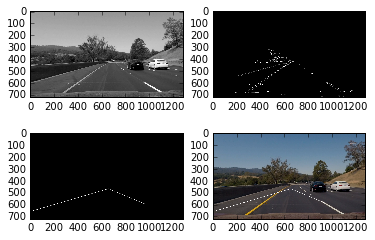

In [98]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Misc